In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import uproot
import root_pandas as rpd
from root_pandas import read_root
from matplotlib import rc
import R2h_module as r2h
import cupy as cp, math, pylab
import os, os.path
mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 13}) 
mpl.rcParams.update({'ytick.labelsize': 13}) 
mpl.rcParams.update({'text.usetex' : False})
rc('font', weight='bold')
colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

Welcome to JupyROOT 6.22/09


**Definition of some constants**

In [2]:
#some general variables:

dpionMassBinsEdges=11
maxmass=1.7
minmass=0.3

dpiondphiBinsEdges=9
maxdphi=3.14
mindphi=0.0

dpionz2BinsEdges=9
maxz2=0.45
minz2=0.05

y_axis_min=-14
y_axis_max=14.01

outdir_sys='/home/seba/di-hadron/systematicsPlots_images/'

## nominal cuts:

p_thr=2.7
Nphe_thr=15
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)





# Get data from Ntuples to dataframes

In [3]:
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    file = uproot.open(filename) 
    tree=file[treename]
    df=tree.arrays(filter_name='*',library='pd')
    return df


# Getting Data

In [4]:
%%time
df = {}
df_trigger = {}
#path_data="/home/seba/CreatePairTuples"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 5.33 s, sys: 456 ms, total: 5.78 s
Wall time: 6.25 s


# Apply selection to datasets


In [5]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    df[key] = r2h.applyCuts(df[key],isMC=isMC)
    df[key] = r2h.applyCutsPair(df[key],isMC=isMC)

for key in df_trigger.keys():
    print (key)
    df_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True)
    print (' ')    


key:  C
Entries before cut  131591
Q2>1.0 and Q2<4.0 131591  (100.00  %)
0.2<h1_p<5.0  131585  (100.00  %)
inelasticity < 0.85 131585  (100.00  %)
h1_pid = pions (trigger) 131585  (100.00  %)
2.2 < nu <4.2 129258  (98.23  %)
10< h1_th<90 129256  (100.00  %)
Theta/P fiducial region selected for trigger 129256  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 129256  (100.00  %)
2.2 < nu < 4.2 129256  (100.00  %)
secondary hadrons are pions 129256  (100.00  %)
(h1_z+h2_z)<1.0 128768  (99.62  %)
(h1_pid*h2_pid)<0, opposite charge pions 95659  (74.29  %)
kinematic limits for h2_z 94552  (98.84  %)
kinematic limits for dphi 94455  (99.90  %)
kinematic limits for pair_mass 94100  (99.62  %)
leading hadrons are pions 94100  (100.00  %)
0.2<h2_p<5.0 94100  (100.00  %)
0.2<h1_p<5.0 94100  (100.00  %)
10<h2_th<90 93947  (99.84  %)
Theta/P fiducial region selected for secondary hadron 93947  (100.00  %)
10< h1_th<90 93947  (100.00  %)
Theta/P fiducial region selected f

In [6]:
# Testing some distributions
#print (df['Pb'].keys())
#df_mc['Fe'].eval('Xb=Q2/(2*0.938272*nu)', inplace=True)
#df['Pb'].hist(figsize=(12,12),bins=100,column=['h1_StatCC','h2_StatCC', 'h1_Nphe', 'h2_Chi2CC'])
#plt.show()

#df['Pb'].eval('h1_P=sqrt(h1_z*nu*h2_z*nu-0.13957*0.13957)', inplace=True)
#df['Pb'].eval('h2_P=sqrt(h2_z*nu*h2_z*nu-0.13957*0.13957)', inplace=True)
#df['Pb'].query('Q2>1').hist(figsize=(15,5),bins=1000,column=['ZC'])
#plt.xlim(0.5,3)
#plt.show()



# Nominal case result plot
**The idea here is to make sure the code is working fine, I should reproduce what I had before**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

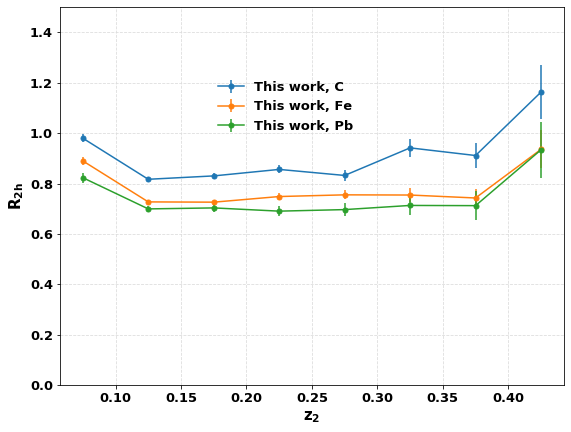

In [7]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    print('for target ',target, ' : ',(err_nom/r_nom)*100)
    plt.errorbar(x_nom,r_nom,yerr = err_nom  ,  fmt='-o',ms=5, label='This work, %s'%target)  
plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=1.0, top=1.0)    
fig.legend(loc='upper center',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
plt.ylim([0.,1.5])
plt.ylabel('R$_{\mathrm{2h}}$',fontsize=15,fontweight="bold")
plt.xlabel('z$_{2}$',fontsize=15,fontweight="bold")

#print('for target ',target, ' : ',(err_nom/r_nom)*100)

plt.show()

# $\color{red}{\textbf{Getting the ratio of nominal case and variations}}$

**$\Delta Z$ Variations**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

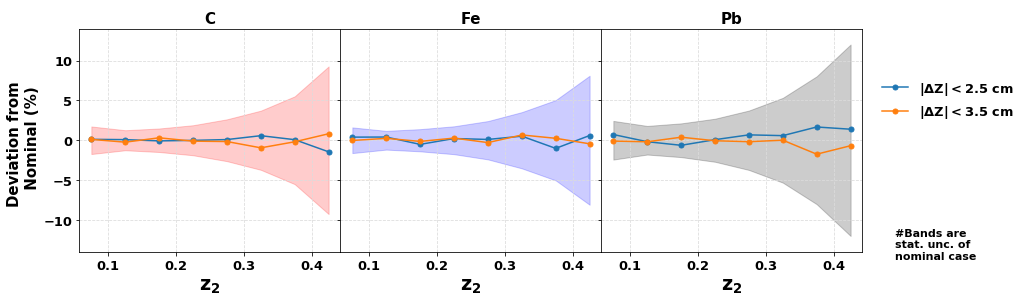

In [8]:
## next line is just to skip this cell while running all cells
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta \mathrm{Z}|<2.5$ cm','$|\Delta \mathrm{Z}|<3.5$ cm']

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max ) 
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

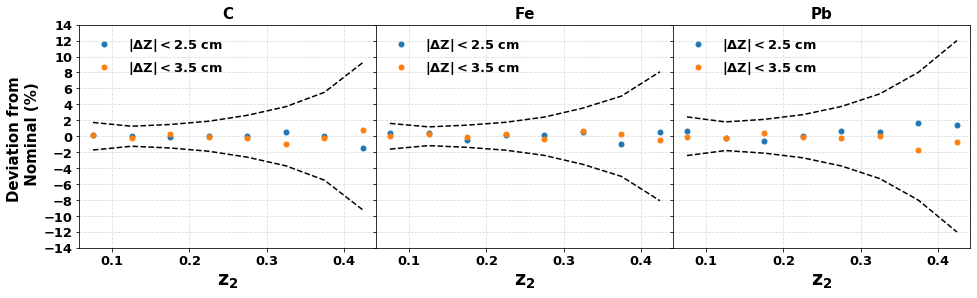

In [9]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta \mathrm{Z}|<2.5$ cm','$|\Delta \mathrm{Z}|<3.5$ cm']
sys_band=np.array([0,0,0,0,0,0,0,0])
pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))
axs[0].set_ylim(y_axis_min , y_axis_max ) 
plt.subplots_adjust(right=0.95, top=0.9)    
#fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')


outname='sys_diH_DeltaZ'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

del sys_band
plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

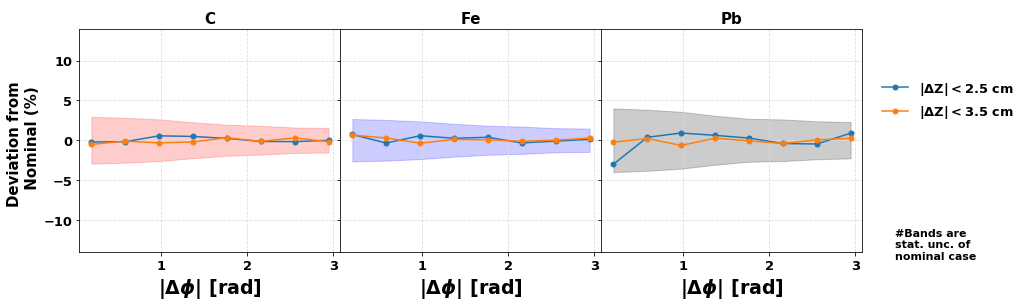

In [10]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta \mathrm{Z}|<2.5$ cm','$|\Delta \mathrm{Z}|<3.5$ cm']

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    #axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='gray')
    #axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='gray')
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')


plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

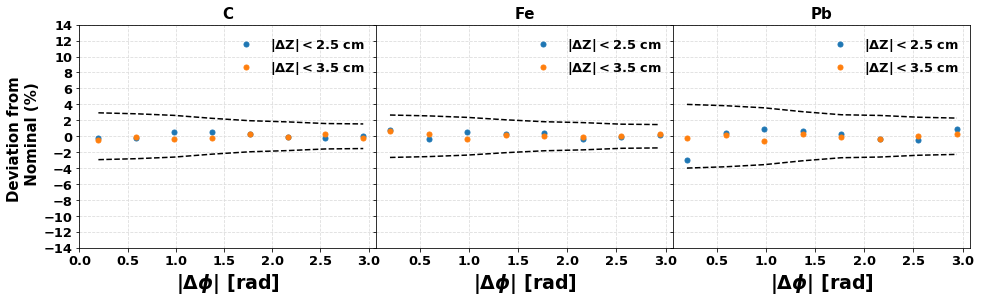

In [11]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta \mathrm{Z}|<2.5$ cm','$|\Delta \mathrm{Z}|<3.5$ cm']
sys_band=np.array([0,0,0,0,0,0,0,0])
pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.01, lw=5)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))
axs[0].set_xticks(np.arange(mindphi,maxdphi,0.5))
print(np.arange(y_axis_min,y_axis_max+4,2))
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
#fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#fig.text(0.88, 0.15, '#Dashed lines\nare stat. unc. of \nnominal case', fontsize=10, va='center')
#fig.text(0.88, 0.30, '#Shaded band\nare systematic \nunc. applied', fontsize=10, va='center')

outname='sys_diH_DeltaZ_dphi'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>0.05 and h2_z<0.45 and pair_mass<1.7 and pair_mass>0.3  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211

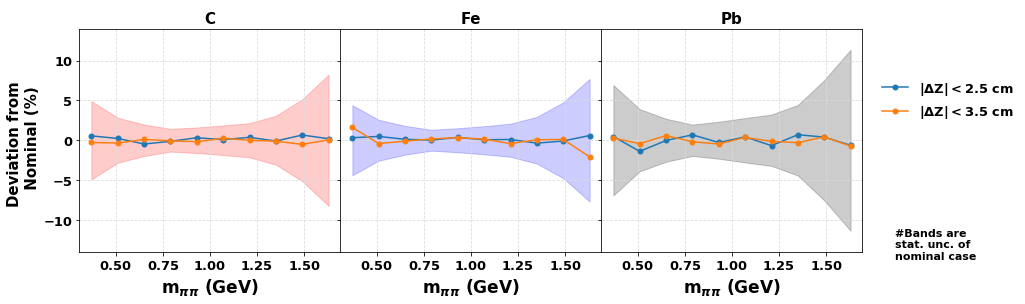

In [12]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta \mathrm{Z}|<2.5$ cm','$|\Delta \mathrm{Z}|<3.5$ cm']

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                        variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                           variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                           variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ (GeV)',fontsize=17,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')


plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

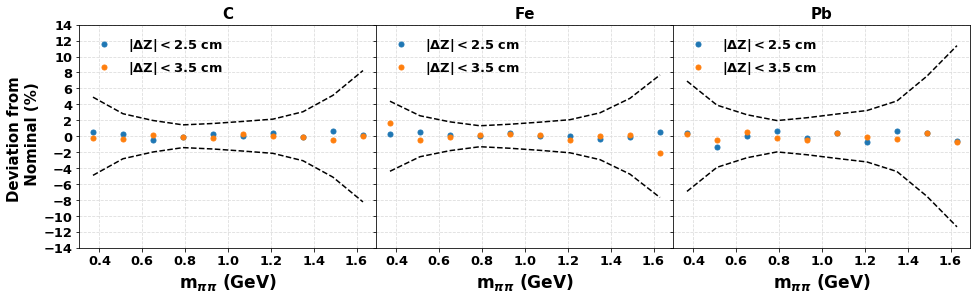

In [13]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\Delta \mathrm{Z}|<2.5$ cm','$|\Delta \mathrm{Z}|<3.5$ cm']
sys_band=np.array([0,0,0,0,0,0,0,0,0,0])
pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                        variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)

    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                           variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                           variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)    
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
#fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ (GeV)',fontsize=17,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

outname='sys_diH_DeltaZ_dpionMass'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band

plt.show()

**Vertex selection variation**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.70000

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( 

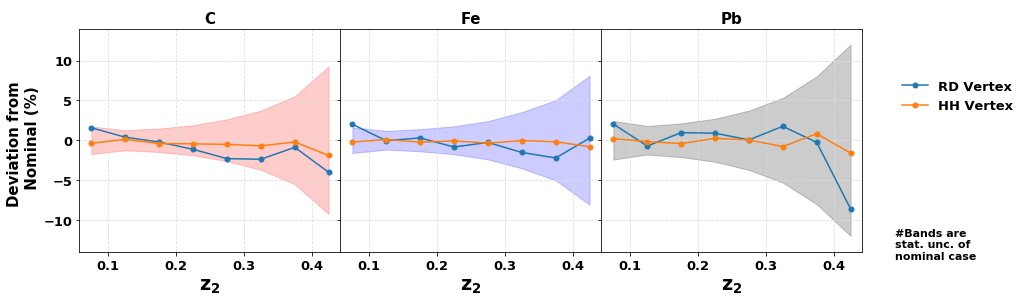

In [14]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['RD Vertex','HH Vertex']

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#outname='sys_diH_VertexCuts'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()


**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.70000

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( 

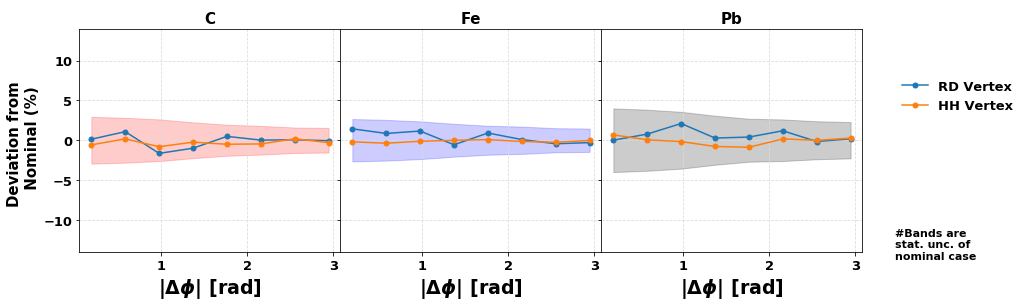

In [15]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['RD Vertex','HH Vertex']

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')


#outname='sys_diH_VertexCuts_dphi'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()


**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.70000

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( 

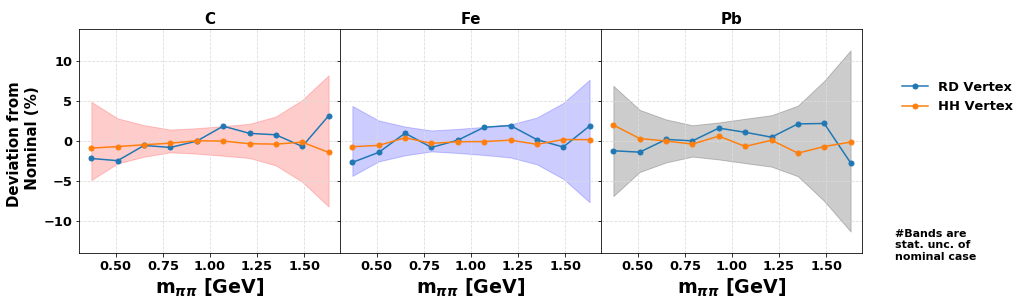

In [16]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['RD Vertex','HH Vertex']

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                        variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass',  
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass',  
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#outname='sys_diH_VertexCuts_dpionMass'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()


# Fiducial Cuts Variations

**With respect to the z$_{2}$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

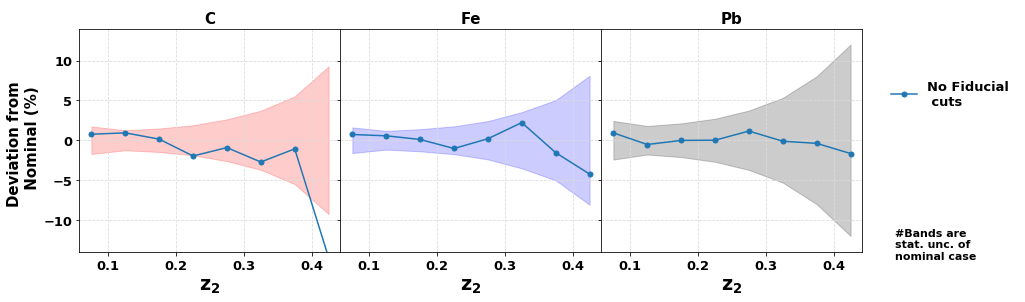

In [17]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['No Fiducial \n cuts']

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
 
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.

    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#outname='sys_diH_FidCuts'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()




**looking the outlier in Carbon**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

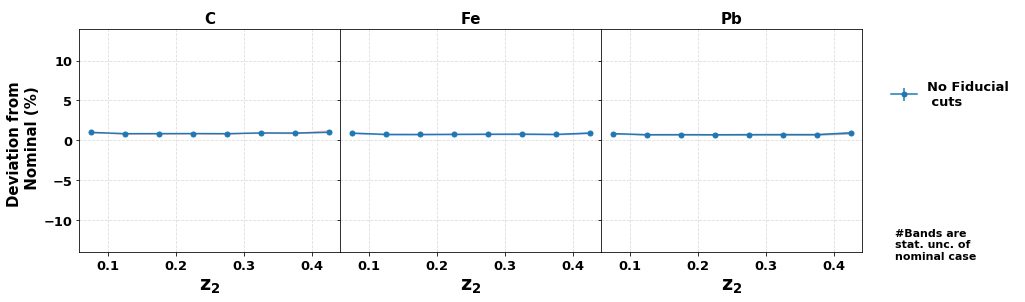

In [18]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['No Fiducial \n cuts']

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, err_nom+r_nom,-err_nom+r_nom,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
 
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.

    axs[i].errorbar(x_nom,r_var1,yerr =err_var1  ,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#plt.savefig('sys_diH_FidCuts.pdf', bbox_inches='tight')

plt.show()




**With respect to the $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

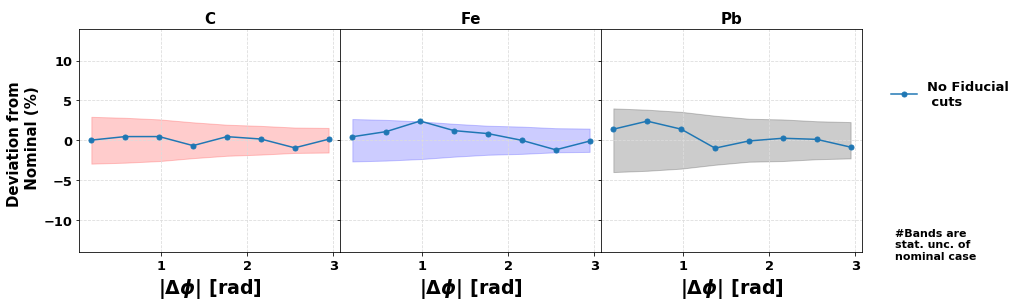

In [19]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['No Fiducial \n cuts']

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and  %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
  
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')


#outname='sys_diH_FidCuts_dphi'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()



**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

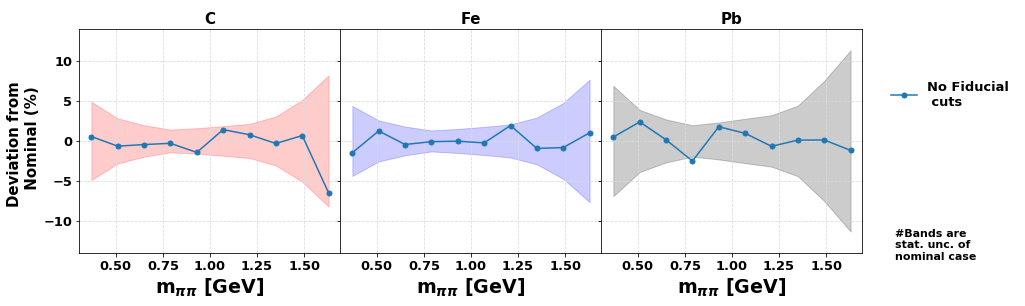

In [20]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['No Fiducial \n cuts']

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and  %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                        variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass',  
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
     
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#outname='sys_diH_FidCuts_dpionMass'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()


# Sector variations

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==3
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==0
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==2
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

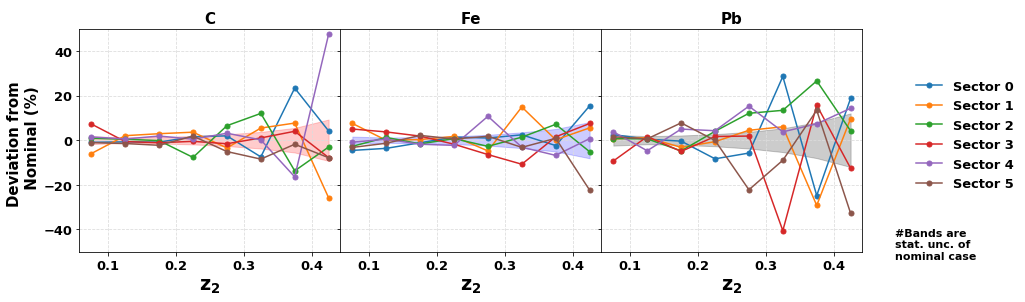

In [21]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    y_dev_nom_var4 =  ((r_var4 - r_nom)/ r_nom )*100.
    y_dev_nom_var5 =  ((r_var5 - r_nom)/ r_nom )*100.
    y_dev_nom_var6 =  ((r_var6 - r_nom)/ r_nom )*100.    
    
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
axs[0].set_ylim(-50,50)
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#outname='sys_diH_Sectors_z2'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')



plt.show()

**each ratio on top of each other. just to see the errors of the variation**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==3
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==0
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==2
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

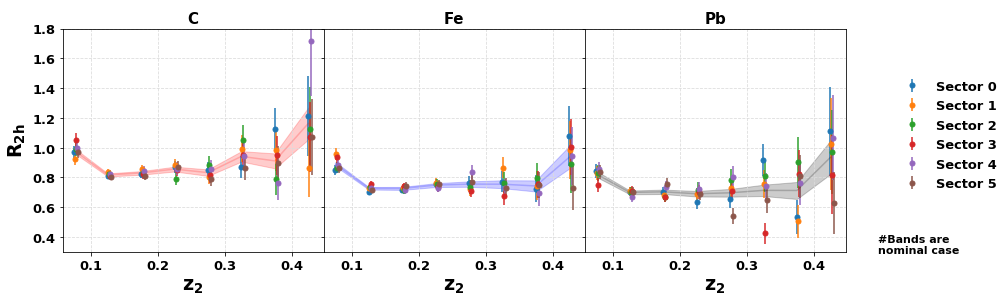

In [22]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].errorbar(x_nom,r_nom,yerr=err_nom,fmt='-o',ms=5)
    axs[i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var6,
                                       trig_cut=trigger_cut_var6)
    shift=0.001
    axs[i].errorbar(x_nom+shift*0,r_var1,yerr=err_var1,fmt='o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*1,r_var2,yerr=err_var2,fmt='o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*2,r_var3,yerr=err_var3,fmt='o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*3,r_var4,yerr=err_var4,fmt='o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*4,r_var5,yerr=err_var5,fmt='o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*5,r_var6,yerr=err_var6,fmt='o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
axs[0].set_ylim(0.3,1.8)
fig.text(0.88, 0.15, '#Bands are \nnominal case', fontsize=11, va='center')
outname='sys_diH_Sectors_z2_R2h'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')



plt.show()

**Calculating the standar deviation**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==3
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==0
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==0
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

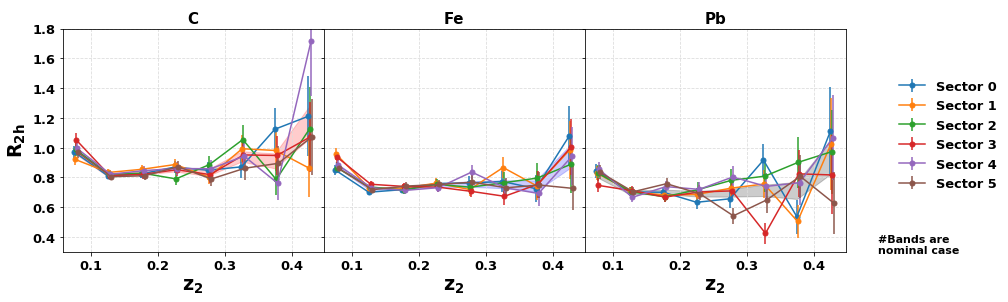

In [23]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].errorbar(x_nom,r_nom,yerr=err_nom,fmt='-o',ms=5)
    axs[i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var6,
                                       trig_cut=trigger_cut_var6)
    for ii in range(dpionz2BinsEdges-1):
        print('sector[\'%s_0\'] =  np.array(['%(target)if ii==0 else "", r_var1[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    for ii in range(dpionz2BinsEdges-1):        
        print('sector[\'%s_1\'] =  np.array(['%(target)if ii==0 else "", r_var2[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    for ii in range(dpionz2BinsEdges-1):        
        print('sector[\'%s_2\'] =  np.array(['%(target)if ii==0 else "", r_var3[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    for ii in range(dpionz2BinsEdges-1):        
        print('sector[\'%s_3\'] =  np.array(['%(target)if ii==0 else "", r_var4[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    for ii in range(dpionz2BinsEdges-1):        
        print('sector[\'%s_4\'] =  np.array(['%(target)if ii==0 else "", r_var5[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    for ii in range(dpionz2BinsEdges-1):        
        print('sector[\'%s_5\'] =  np.array(['%(target)if ii==0 else "", r_var6[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    
    
    
    print('\n\n ERRORS \n\n')    
    
    for ii in range(dpionz2BinsEdges-1):
        print('sector_err[\'%s_0\'] =  np.array(['%(target)if ii==0 else "", err_var1[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    for ii in range(dpionz2BinsEdges-1):        
        print('sector_err[\'%s_1\'] =  np.array(['%(target)if ii==0 else "", err_var2[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    for ii in range(dpionz2BinsEdges-1):        
        print('sector_err[\'%s_2\'] =  np.array(['%(target)if ii==0 else "", err_var3[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    for ii in range(dpionz2BinsEdges-1):        
        print('sector_err[\'%s_3\'] =  np.array(['%(target)if ii==0 else "", err_var4[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    for ii in range(dpionz2BinsEdges-1):        
        print('sector_err[\'%s_4\'] =  np.array(['%(target)if ii==0 else "", err_var5[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    for ii in range(dpionz2BinsEdges-1):        
        print('sector_err[\'%s_5\'] =  np.array(['%(target)if ii==0 else "", err_var6[ii], ',', '])'if ii==dpionz2BinsEdges-2 else ""    )
    
        
    
    
    print('\n\nsector 0, r: ', r_var1)
    print('\n\nsector 0, errr: ', err_var1)    
    print('\n\nsector 1, r: ', r_var2)
    print('\n\nsector 1, errr: ', err_var2)
    print('\n\nsector 2, r: ', r_var3)
    print('\n\nsector 2, errr: ', err_var3)
    print('\n\nsector 3, r: ', r_var4)
    print('\n\nsector 3, errr: ', err_var4)
    print('\n\nsector 4, r: ', r_var5)
    print('\n\nsector 4, errr: ', err_var5)
    print('\n\nsector 5, r: ', r_var6)
    print('\n\nsector 5, errr: ', err_var6)

    
    shift=0.001
    axs[i].errorbar(x_nom+shift*0,r_var1,yerr=err_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*1,r_var2,yerr=err_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*2,r_var3,yerr=err_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*3,r_var4,yerr=err_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*4,r_var5,yerr=err_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*5,r_var6,yerr=err_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
axs[0].set_ylim(0.3,1.8)
fig.text(0.88, 0.15, '#Bands are \nnominal case', fontsize=11, va='center')
#plt.savefig('sys_diH_Sectors_z2_R2h.pdf', bbox_inches='tight')
#plt.savefig('sys_diH_Sectors_z2_R2h.png', bbox_inches='tight')

plt.show()

For  C
variance associated with bin  0  is  0.00018856551397997324
variance associated with bin  1  is  5.118702543076142e-05
variance associated with bin  2  is  5.099258545309215e-05
variance associated with bin  3  is  9.709441898264312e-05
variance associated with bin  4  is  0.00025359495638650764
variance associated with bin  5  is  0.0007698978395382616
variance associated with bin  6  is  0.0024496210419088903
variance associated with bin  7  is  0.013980303662576936
For  Fe
variance associated with bin  0  is  0.00032007888634376114
variance associated with bin  1  is  7.712013356522447e-05
variance associated with bin  2  is  2.2038794193320898e-05
variance associated with bin  3  is  3.536818985861191e-05
variance associated with bin  4  is  0.00029693722917673086
variance associated with bin  5  is  0.000792455470828717
variance associated with bin  6  is  0.00030202045517324237
variance associated with bin  7  is  0.0022110107701247537
For  Pb
variance associated with bin 

<ipython-input-24-eda3a088eaaf>:355: RuntimeWarning: invalid value encountered in sqrt
  sys=(np.sqrt(sys2)/r_nom)


Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

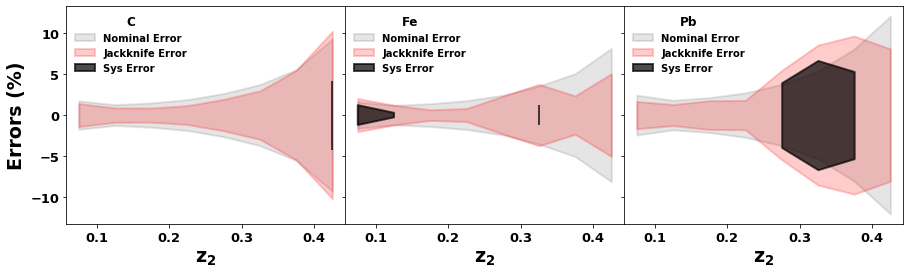

In [24]:
##%%script false --no-raise-error
## Jacknife calculations:
sector={}
sector_err={}
mean_bin={}
mean_subsample={}

sector['C_0'] =  np.array([ 1.0640767789974024 , 
 0.8665221581713372 , 
 0.8666208442928333 , 
 0.8988984400311985 , 
 0.8961192712509469 , 
 0.8874685091774533 , 
 1.087259918970043 , 
 1.1931855773691402 , ])
sector['C_1'] =  np.array([ 1.0289074066664 , 
 0.897829980084636 , 
 0.9004631312678706 , 
 0.9224401241323775 , 
 0.8214211410480067 , 
 1.050376573354426 , 
 1.0516101336284769 , 
 0.9276830135039091 , ])
sector['C_2'] =  np.array([ 1.0690534019608973 , 
 0.8764360243812632 , 
 0.8625437930144797 , 
 0.8496950710400917 , 
 0.8976344788104298 , 
 1.051694881686581 , 
 0.7835126868565029 , 
 1.0843255934174816 , ])
sector['C_3'] =  np.array([ 1.1320236604820864 , 
 0.8641832038115319 , 
 0.8967827377913921 , 
 0.8896200700976871 , 
 0.8784269872742867 , 
 0.990332778911542 , 
 0.9848763999643709 , 
 1.1996238856708878 , ])
sector['C_4'] =  np.array([ 1.0619775608887556 , 
 0.8817923262669269 , 
 0.8869700074442181 , 
 0.8852092907708764 , 
 0.9140086619479074 , 
 0.9694971214402202 , 
 0.8395645175358607 , 
 1.7394727347696113 , ])
sector['C_5'] =  np.array([ 1.0653716961841717 , 
 0.8462721029989573 , 
 0.8626896115952788 , 
 0.9020004954232954 , 
 0.8272109950023464 , 
 0.9146763119190284 , 
 0.8874419409759057 , 
 0.9965861868472716 , ])

sector['Fe_0'] =  np.array([ 0.9410631792004558 , 
 0.7703425727024485 , 
 0.7578161461563188 , 
 0.7896560689135815 , 
 0.8318770189058227 , 
 0.8744252186937238 , 
 0.7511644279217076 , 
 1.1089807426264677 , ])
sector['Fe_1'] =  np.array([ 1.0301524952572032 , 
 0.8072564347938674 , 
 0.7719160605767964 , 
 0.8091673362536366 , 
 0.7616951987541424 , 
 0.910748690253464 , 
 0.8219342975238286 , 
 0.9843914177551286 , ])
sector['Fe_2'] =  np.array([ 0.9334469958895739 , 
 0.7974715663708313 , 
 0.7757460097654022 , 
 0.7953285646126245 , 
 0.8029896470413082 , 
 0.8380262323510761 , 
 0.8024476250440995 , 
 0.8873218930776099 , ])
sector['Fe_3'] =  np.array([ 1.0223092119025197 , 
 0.8283630551713624 , 
 0.7892416642173447 , 
 0.780437494163793 , 
 0.7483807017645571 , 
 0.7102997444570355 , 
 0.783982290562537 , 
 1.0216483439026527 , ])
sector['Fe_4'] =  np.array([ 0.9908716755352833 , 
 0.7819092717219972 , 
 0.783855944115064 , 
 0.7688011580984735 , 
 0.8612437124545448 , 
 0.8409647892796033 , 
 0.7075046904315196 , 
 0.949056796861675 , ])
sector['Fe_5'] =  np.array([ 0.940312479068682 , 
 0.7785357675046892 , 
 0.7853349158198064 , 
 0.8013138540750415 , 
 0.7981221640862196 , 
 0.802274799510509 , 
 0.8065006045616708 , 
 0.7741629700563915 , ])

sector['Pb_0'] =  np.array([ 0.891335504517228 , 
 0.7511208273560017 , 
 0.7519811142589635 , 
 0.6626198354816559 , 
 0.6794822331868275 , 
 0.9154056203386185 , 
 0.6173393903820711 , 
 1.1240329477646291 , ])
sector['Pb_1'] =  np.array([ 0.896183118700248 , 
 0.7630689501316678 , 
 0.6926171076229108 , 
 0.7264296452488335 , 
 0.738798570426709 , 
 0.7698747204405947 , 
 0.4791736883774333 , 
 0.9363232444940405 , ])
sector['Pb_2'] =  np.array([ 0.8772859171277567 , 
 0.7736630618122866 , 
 0.7256242479655699 , 
 0.7388088546774685 , 
 0.7826541278378815 , 
 0.8722002016661466 , 
 0.9038703388589009 , 
 1.0553005892261778 , ])
sector['Pb_3'] =  np.array([ 0.8469871788873866 , 
 0.755196150928878 , 
 0.7313360428637653 , 
 0.7257636447012776 , 
 0.7953026700230015 , 
 0.5026884524511858 , 
 0.8491233382288429 , 
 0.7709500785188859 , ])
sector['Pb_4'] =  np.array([ 0.9293391124444046 , 
 0.7090880515047605 , 
 0.7604394963967398 , 
 0.7475009663622799 , 
 0.8461188879759012 , 
 0.8131570844386864 , 
 0.7452388802606561 , 
 1.0409270595775597 , ])
sector['Pb_5'] =  np.array([ 0.9370542215744115 , 
 0.7497036560664732 , 
 0.7780716869518157 , 
 0.7101719160474722 , 
 0.5885255573498113 , 
 0.6938516584777273 , 
 0.8774648047823137 , 
 0.6500981891901907 , ])

## ERRORS


sector_err['C_0'] =  np.array([ 0.03668359267175695 , 
 0.02252292708292325 , 
 0.02691968431076595 , 
 0.036470203440522014 , 
 0.051515470872446345 , 
 0.07074245664267685 , 
 0.13568834301027521 , 
 0.2566780296668049 , ])
sector_err['C_1'] =  np.array([ 0.03654223996020852 , 
 0.023477799179011494 , 
 0.028606621083812275 , 
 0.03767242128759218 , 
 0.04693981123750584 , 
 0.09096109950495855 , 
 0.14004429942105243 , 
 0.20539247145543882 , ])
sector_err['C_2'] =  np.array([ 0.03935080314378699 , 
 0.025043282422882288 , 
 0.02909176533471036 , 
 0.03773402294936808 , 
 0.05572164583038991 , 
 0.09300212474107085 , 
 0.09885423837215211 , 
 0.25946455639350374 , ])
sector_err['C_3'] =  np.array([ 0.04224265696633849 , 
 0.023864549185904183 , 
 0.029818981819796513 , 
 0.0383319367515741 , 
 0.05312579610752423 , 
 0.08318917962332259 , 
 0.13189154689850094 , 
 0.25225693542334043 , ])
sector_err['C_4'] =  np.array([ 0.04277853407493338 , 
 0.027562950398172383 , 
 0.03246107619981164 , 
 0.042127890169863354 , 
 0.05847524634828675 , 
 0.09103801415637088 , 
 0.11930181571096216 , 
 0.3673865377373001 , ])
sector_err['C_5'] =  np.array([ 0.038713103687779714 , 
 0.023072187477013468 , 
 0.028301682257002362 , 
 0.03787988307556605 , 
 0.04930073056428353 , 
 0.07931303213904463 , 
 0.11150814502624873 , 
 0.2348094917546458 , ])


sector_err['Fe_0'] =  np.array([ 0.031021030106785294 , 
 0.019447275672889085 , 
 0.023365310142226006 , 
 0.031036820584798563 , 
 0.044962932881025076 , 
 0.07038999312990796 , 
 0.09000294458894152 , 
 0.1977688148378093 , ])
sector_err['Fe_1'] =  np.array([ 0.035318669813898806 , 
 0.02087455281742101 , 
 0.023991188753342794 , 
 0.03192481282596215 , 
 0.0436023909047336 , 
 0.07170780256241348 , 
 0.09990443954268353 , 
 0.19165005608257726 , ])
sector_err['Fe_2'] =  np.array([ 0.033370561329986594 , 
 0.02148403243468701 , 
 0.025586791266917465 , 
 0.03348452799989767 , 
 0.04624106972891004 , 
 0.0711916754780622 , 
 0.09482205032582465 , 
 0.18369308353899527 , ])
sector_err['Fe_3'] =  np.array([ 0.03432248035186227 , 
 0.02072930818884758 , 
 0.02391787932374459 , 
 0.030346174372747788 , 
 0.04061831647236667 , 
 0.057690510176672954 , 
 0.09137124361708325 , 
 0.18691339907655813 , ])
sector_err['Fe_4'] =  np.array([ 0.03297202226572827 , 
 0.019834193813148843 , 
 0.024091147493616027 , 
 0.02994367446321544 , 
 0.0449822818072023 , 
 0.06454293359463831 , 
 0.08406237860308052 , 
 0.1858148831695804 , ])
sector_err['Fe_5'] =  np.array([ 0.03168959485119067 , 
 0.01976931982281381 , 
 0.023708974541885693 , 
 0.030964261716256353 , 
 0.04297628762774909 , 
 0.06486873261348619 , 
 0.09048974025688206 , 
 0.15080030254930757 , ])

sector_err['Pb_0'] =  np.array([ 0.044288642597293114 , 
 0.02830777901806315 , 
 0.03419748017271387 , 
 0.04143817554683913 , 
 0.05683836110421175 , 
 0.10201847656801295 , 
 0.12139294186289246 , 
 0.2849362241601536 , ])
sector_err['Pb_1'] =  np.array([ 0.04471911985284058 , 
 0.029335857863980713 , 
 0.03347193933720094 , 
 0.043503781033125716 , 
 0.06158543313248333 , 
 0.0912790927530501 , 
 0.10455487778704253 , 
 0.2827770470909168 , ])
sector_err['Pb_2'] =  np.array([ 0.047652234500217154 , 
 0.03181842900098154 , 
 0.037049523083756836 , 
 0.04840437197954847 , 
 0.06946742830778725 , 
 0.10739375982623077 , 
 0.16792005149521266 , 
 0.2893106668297258 , ])
sector_err['Pb_3'] =  np.array([ 0.04429509844457601 , 
 0.029352923741683187 , 
 0.03431660422481025 , 
 0.04345896015285497 , 
 0.06543563720769842 , 
 0.07310009338916722 , 
 0.15513444088765715 , 
 0.24957593821230886 , ])
sector_err['Pb_4'] =  np.array([ 0.046478102064282996 , 
 0.028814976008562785 , 
 0.03565767518962065 , 
 0.045143415038584635 , 
 0.07023256915830484 , 
 0.09491128922833286 , 
 0.1409563480057823 , 
 0.2690177471411623 , ])
sector_err['Pb_5'] =  np.array([ 0.04703211198936388 , 
 0.028504365533836874 , 
 0.035302697458799014 , 
 0.04202115496546419 , 
 0.052572422523882945 , 
 0.08547327047673083 , 
 0.15036892988939804 , 
 0.20830935175436582 , ])


jackknife_var={}
for tar in ['C', 'Fe','Pb']:
    print('For ', tar)
    for i in range(dpionz2BinsEdges-1):
        mean=0
        for j in range(6):
            mean = mean + sector['%s_%d'%(tar,j)][i]
        #print('bin =', i , '; total mean:',mean/6.)
        mean_bin['%s_%d'%(tar,i)]=mean/6.
    
    for i in range(dpionz2BinsEdges-1):    
        for j in range(6):
            mean=0
            for jj in range (6):
                if jj==j:    mean = mean + 0
                else: mean = mean + sector['%s_%d'%(tar,jj)][i]
            if False:    print('bin =', i ,j, 'without value ',j , '; mean:',mean/5.)
            mean_subsample['%s_%d_%d'%(tar,i,j)] = mean/5.0
    
    tmp = np.empty(dpionz2BinsEdges-1)        
    for i in range(8):
        sum=0
        for j in range(6):
            sum = sum + (mean_subsample['%s_%d_%d'%(tar,i,j)] - mean_bin['%s_%d'%(tar,i)] )*(mean_subsample['%s_%d_%d'%(tar,i,j)] - mean_bin['%s_%d'%(tar,i)] )
            #if i==0:    print(mean_subsample['%s_%d_%d'%(tar,i,j)] , ' - ',mean_bin['%s_%d'%(tar,i)] )
        print('variance associated with bin ',i, ' is ', ((6-1)/6.)*sum )   
        #jackknife_var['%s_%d'%(tar,i)] = ((6-1)/6.)*sum
        tmp[i] = ( ((6.-1.)/6.)*sum )
    jackknife_var['%s'%(tar)] = tmp

        
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['black','black','black']
colorBands_jack=['red','red','red']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']
colorBandssys=['black','black','black']        
        
for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)    
    #axs[i].errorbar(x_nom,r_nom,yerr=err_nom,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],lw=2,alpha=0.1, label='Nominal Error')
    axs[i].fill_between(x_nom,(  np.sqrt(jackknife_var['%s'%(target)] )/r_nom  )*100,-(np.sqrt(jackknife_var['%s'%(target)])/r_nom )*100,color=colorBands_jack[i],alpha=0.2, label='Jackknife Error', lw=2)
            
    sys2= ( (jackknife_var['%s'%(target)] )  -  (err_nom*err_nom) )
    sys=(np.sqrt(sys2)/r_nom)
    axs[i].fill_between(x_nom,sys*100,-sys*100,color=colorBandssys[i],alpha=0.7, label='Sys Error', lw=2)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=10, title='%s'%target, title_fontsize=12)
        
for i,j in enumerate(['C','Fe','Pb']):
    #axs[0][i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$\mathrm{z}_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Errors (%)',fontsize=19,fontweight="bold")
#axs[0][0].set_ylim(0.45,1.45)
#fig.text(0.88, 0.15, '#Bands are \nnominal case', fontsize=11, va='center')
#plt.savefig('sys_diH_Sectors_z2_R2h.pdf', bbox_inches='tight')
#plt.savefig('sys_diH_Sectors_z2_R2h_exclusion_jack_comparison.png', bbox_inches='tight')
#plt.savefig('sys_diH_Sectors_z2_R2h_exclusion_jack_comparison.pdf', bbox_inches='tight')
        
#for i in range(8):    print(mean_bin['%s_%d'%(tar,i)])  
#for i in range(8):    print( sqrt(    )  )
print(jackknife_var['C'])
print(jackknife_var['Fe'])
print(jackknife_var['Pb'])

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=3
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=0
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=1
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=5
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

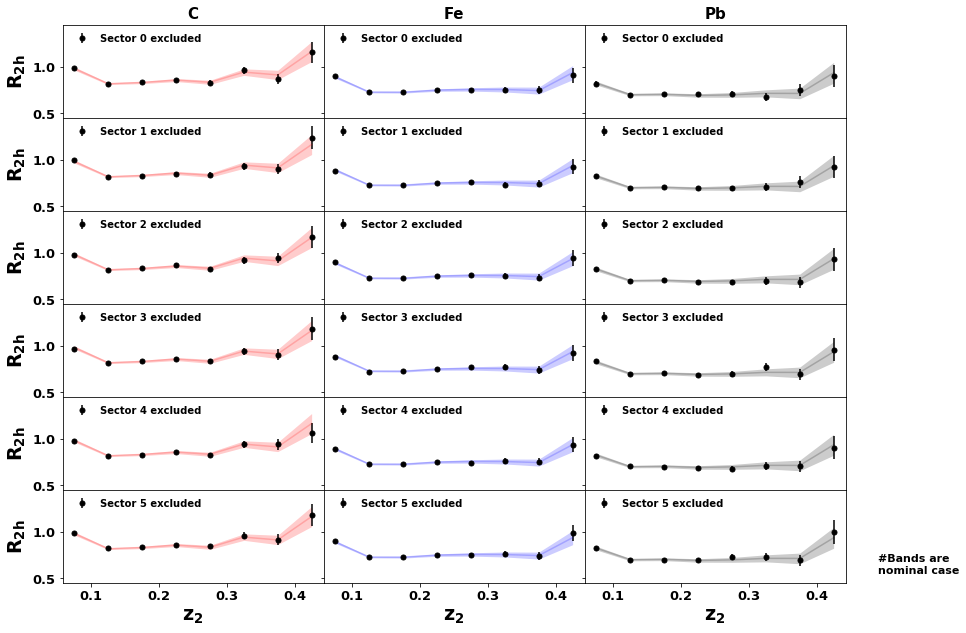

In [25]:
fig, axs = plt.subplots(6, 3,sharex=True, sharey=True,figsize=(15,10),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0 excluded','Sector 1 excluded','Sector 2 excluded','Sector 3 excluded','Sector 4 excluded','Sector 5 excluded']

pair_cut_var1='%s and h1_Sector!=0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector!=1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector!=2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector!=3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector!=4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector!=5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector!=0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector!=1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector!=2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector!=3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector!=4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector!=5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[0][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[1][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[2][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[3][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[4][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[5][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    
    axs[0][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[1][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[2][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[3][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[4][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[5][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    
    shift=0.001
    axs[0][i].errorbar(x_nom+shift*0,r_var1,yerr=err_var1,fmt='o',ms=5,label=tmp_label[0], color='black')  
    axs[1][i].errorbar(x_nom+shift*0,r_var2,yerr=err_var2,fmt='o',ms=5,label=tmp_label[1], color='black')
    axs[2][i].errorbar(x_nom+shift*0,r_var3,yerr=err_var3,fmt='o',ms=5,label=tmp_label[2], color='black')  
    axs[3][i].errorbar(x_nom+shift*0,r_var4,yerr=err_var4,fmt='o',ms=5,label=tmp_label[3], color='black')
    axs[4][i].errorbar(x_nom+shift*0,r_var5,yerr=err_var5,fmt='o',ms=5,label=tmp_label[4], color='black')  
    axs[5][i].errorbar(x_nom+shift*0,r_var6,yerr=err_var6,fmt='o',ms=5,label=tmp_label[5], color='black')    
    
    #axs[0][i].grid(axis="x",color='gainsboro', linestyle='dashed')
    #axs[0][i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
for i in range (3):
    for ii in range(6):
        axs[ii][i].legend(loc='upper left',ncol=1,frameon=False,fontsize=10, title='', title_fontsize=20)
for i,j in enumerate(['C','Fe','Pb']):
    axs[0][i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[5][i].set_xlabel('$\mathrm{z}_{2}$',fontsize=19,fontweight="bold")
for j in range (6):    axs[j][0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=19,fontweight="bold")
axs[0][0].set_ylim(0.45,1.45)
fig.text(0.88, 0.15, '#Bands are \nnominal case', fontsize=11, va='center')
#plt.savefig('sys_diH_Sectors_z2_R2h.pdf', bbox_inches='tight')

outname='sys_diH_Sectors_z2_R2h_exclusion'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')



plt.show()

**Plotting the jackknife variance with the nominal**

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==2
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

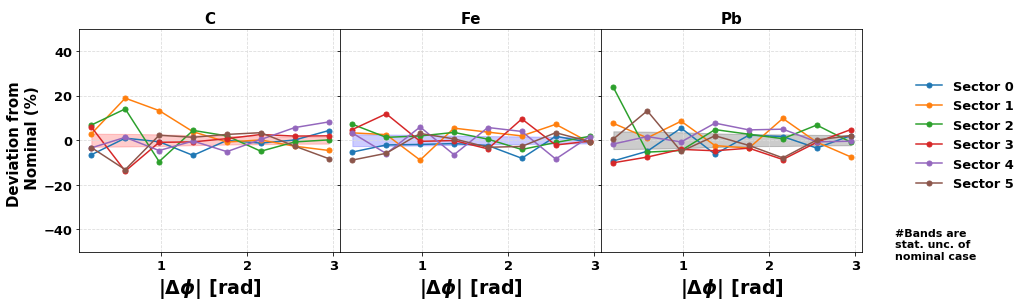

In [26]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    y_dev_nom_var4 =  ((r_var4 - r_nom)/ r_nom )*100.
    y_dev_nom_var5 =  ((r_var5 - r_nom)/ r_nom )*100.
    y_dev_nom_var6 =  ((r_var6 - r_nom)/ r_nom )*100.    
    
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
axs[0].set_ylim(-50,50)
#plt.savefig('sys_diH_Sectors_dphi.pdf', bbox_inches='tight')
#plt.savefig('sys_diH_Sectors_dphi.png', bbox_inches='tight')
plt.show()

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==1
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==5
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==2
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

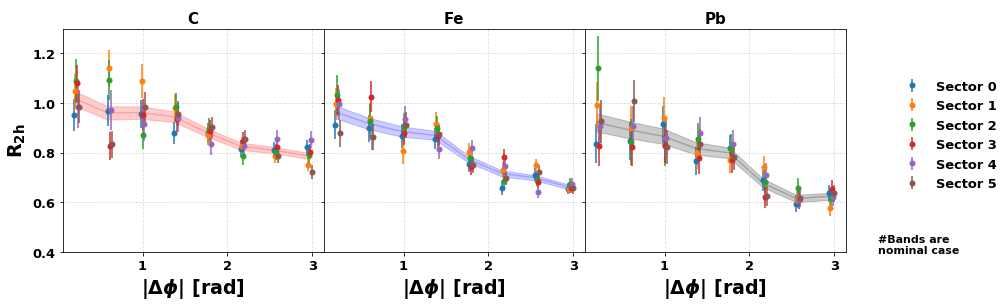

In [27]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].errorbar(x_nom,r_nom,yerr=err_nom,fmt='-o',ms=5)
    axs[i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)
    shift=0.01
    axs[i].errorbar(x_nom+shift*0,r_var1,yerr=err_var1,fmt='o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*1,r_var2,yerr=err_var2,fmt='o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*2,r_var3,yerr=err_var3,fmt='o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*3,r_var4,yerr=err_var4,fmt='o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*4,r_var5,yerr=err_var5,fmt='o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*5,r_var6,yerr=err_var6,fmt='o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
axs[0].set_ylim(0.4,1.3)
fig.text(0.88, 0.15, '#Bands are \nnominal case', fontsize=11, va='center')

outname='sys_diH_Sectors_dphi_R2h'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()

**Excluding sector one by one, as a function of $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=3
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=0
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=1
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=5
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

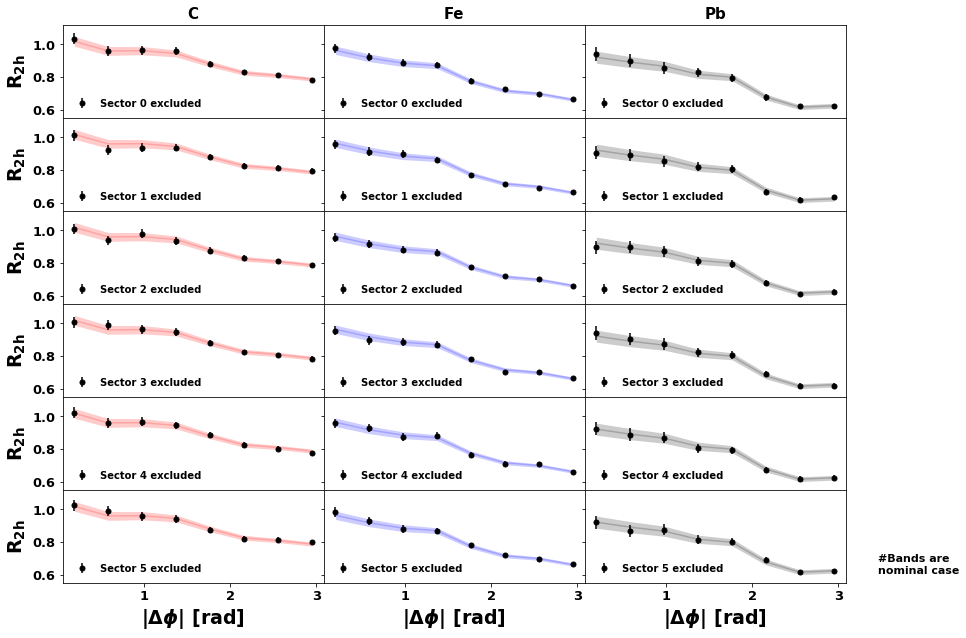

In [28]:
fig, axs = plt.subplots(6, 3,sharex=True, sharey=True,figsize=(15,10),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0 excluded','Sector 1 excluded','Sector 2 excluded','Sector 3 excluded','Sector 4 excluded','Sector 5 excluded']

pair_cut_var1='%s and h1_Sector!=0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector!=1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector!=2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector!=3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector!=4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector!=5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector!=0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector!=1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector!=2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector!=3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector!=4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector!=5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
                                    
    axs[0][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[1][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[2][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[3][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[4][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[5][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    
    axs[0][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[1][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[2][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[3][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[4][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[5][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut=trigger_cut_var1)
                                       
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
                                       
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
                                       
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    
    shift=0.001
    axs[0][i].errorbar(x_nom+shift*0,r_var1,yerr=err_var1,fmt='o',ms=5,label=tmp_label[0], color='black')  
    axs[1][i].errorbar(x_nom+shift*0,r_var2,yerr=err_var2,fmt='o',ms=5,label=tmp_label[1], color='black')
    axs[2][i].errorbar(x_nom+shift*0,r_var3,yerr=err_var3,fmt='o',ms=5,label=tmp_label[2], color='black')  
    axs[3][i].errorbar(x_nom+shift*0,r_var4,yerr=err_var4,fmt='o',ms=5,label=tmp_label[3], color='black')
    axs[4][i].errorbar(x_nom+shift*0,r_var5,yerr=err_var5,fmt='o',ms=5,label=tmp_label[4], color='black')  
    axs[5][i].errorbar(x_nom+shift*0,r_var6,yerr=err_var6,fmt='o',ms=5,label=tmp_label[5], color='black')    
    
    #axs[0][i].grid(axis="x",color='gainsboro', linestyle='dashed')
    #axs[0][i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
for i in range (3):
    for ii in range(6):
        axs[ii][i].legend(loc='lower left',ncol=1,frameon=False,fontsize=10, title='', title_fontsize=20)
for i,j in enumerate(['C','Fe','Pb']):
    axs[0][i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[5][i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
for j in range (6):    axs[j][0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=19,fontweight="bold")
axs[0][0].set_ylim(0.55,1.12)
#axs[0][0].set_xlim([-0.01,3.155])
fig.text(0.88, 0.15, '#Bands are \nnominal case', fontsize=11, va='center')
#plt.savefig('sys_diH_Sectors_z2_R2h.pdf', bbox_inches='tight')

outname='sys_diH_Sectors_dphi_R2h_exclusion'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()




**Calculating the error Jackknife**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==3
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==0
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==5
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==2
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

sector['Pb_0'] =  np.array([ 0.8360650349859103 , 
 0.8469388356879641 , 
 0.9134256364542573 , 
 0.7654346458511286 , 
 0.8171040289131698 , 
 0.6887358889912071 , 
 0.5935629673446483 , 
 0.6363767991177537 , ])
sector['Pb_1'] =  np.array([ 0.991353478396888 , 
 0.9003108120135004 , 
 0.9399855257632479 , 
 0.7969336000198127 , 
 0.7706527908358655 , 
 0.7437494097773292 , 
 0.6098879694285002 , 
 0.5772238530839466 , ])
sector['Pb_2'] =  np.array([ 1.1398700231928875 , 
 0.8435752135024212 , 
 0.8263577475758961 , 
 0.8553798499001903 , 
 0.8202861881189 , 
 0.6822740909371244 , 
 0.6568988633282539 , 
 0.6183953446330127 , ])
sector['Pb_3'] =  np.array([ 0.8285247537357845 , 
 0.8237809218903704 , 
 0.8306476520491385 , 
 0.7780516303776732 , 
 0.7703818490602032 , 
 0.6190656426372955 , 
 0.6093711608196735 , 
 0.6532103857561491 , ])
sector['Pb_4'] =  np.array([ 0.9060669204251935 , 
 0.9056251789806569 , 
 0.8596657733710613 , 
 0.8791044871195971 , 
 0.8357981743896961 , 
 0.71

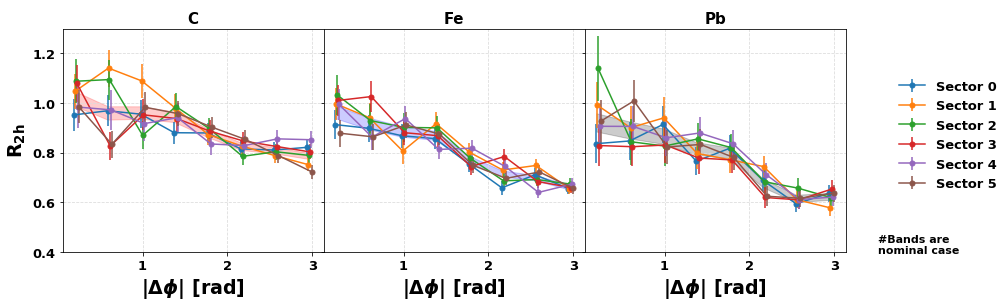

In [29]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].errorbar(x_nom,r_nom,yerr=err_nom,fmt='-o',ms=5)
    axs[i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)
    shift=0.01
    axs[i].errorbar(x_nom+shift*0,r_var1,yerr=err_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*1,r_var2,yerr=err_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*2,r_var3,yerr=err_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*3,r_var4,yerr=err_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*4,r_var5,yerr=err_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*5,r_var6,yerr=err_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    
    for ii in range(dpiondphiBinsEdges-1):
        print('sector[\'%s_0\'] =  np.array(['%(target)if ii==0 else "", r_var1[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    for ii in range(dpiondphiBinsEdges-1):        
        print('sector[\'%s_1\'] =  np.array(['%(target)if ii==0 else "", r_var2[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    for ii in range(dpiondphiBinsEdges-1):        
        print('sector[\'%s_2\'] =  np.array(['%(target)if ii==0 else "", r_var3[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    for ii in range(dpiondphiBinsEdges-1):        
        print('sector[\'%s_3\'] =  np.array(['%(target)if ii==0 else "", r_var4[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    for ii in range(dpiondphiBinsEdges-1):        
        print('sector[\'%s_4\'] =  np.array(['%(target)if ii==0 else "", r_var5[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    for ii in range(dpiondphiBinsEdges-1):        
        print('sector[\'%s_5\'] =  np.array(['%(target)if ii==0 else "", r_var6[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    
    
    
    print('\n\n ERRORS \n\n')    
    
    for ii in range(dpiondphiBinsEdges-1):
        print('sector_err[\'%s_0\'] =  np.array(['%(target)if ii==0 else "", err_var1[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    for ii in range(dpiondphiBinsEdges-1):        
        print('sector_err[\'%s_1\'] =  np.array(['%(target)if ii==0 else "", err_var2[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    for ii in range(dpiondphiBinsEdges-1):        
        print('sector_err[\'%s_2\'] =  np.array(['%(target)if ii==0 else "", err_var3[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    for ii in range(dpiondphiBinsEdges-1):        
        print('sector_err[\'%s_3\'] =  np.array(['%(target)if ii==0 else "", err_var4[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    for ii in range(dpiondphiBinsEdges-1):        
        print('sector_err[\'%s_4\'] =  np.array(['%(target)if ii==0 else "", err_var5[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    for ii in range(dpiondphiBinsEdges-1):        
        print('sector_err[\'%s_5\'] =  np.array(['%(target)if ii==0 else "", err_var6[ii], ',', '])'if ii==dpiondphiBinsEdges-2 else ""    )
    
     
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
axs[0].set_ylim(0.4,1.3)
fig.text(0.88, 0.15, '#Bands are \nnominal case', fontsize=11, va='center')
#plt.savefig('sys_diH_Sectors_dphi_R2h.pdf', bbox_inches='tight')
#plt.savefig('sys_diH_Sectors_dphi_R2h.png', bbox_inches='tight')

plt.show()

For  C
variance associated with bin  0  is  0.0004689167871555124
variance associated with bin  1  is  0.00233591176484635
variance associated with bin  2  is  0.0005030269544292479
variance associated with bin  3  is  0.00044788502309509525
variance associated with bin  4  is  0.0001828297236452909
variance associated with bin  5  is  3.93366984861519e-05
variance associated with bin  6  is  0.00011615278316745088
variance associated with bin  7  is  0.0003338054989574056
For  Fe
variance associated with bin  0  is  0.0005907967308582103
variance associated with bin  1  is  0.0003342528316824683
variance associated with bin  2  is  0.00020860323653994068
variance associated with bin  3  is  0.00021824738858724086
variance associated with bin  4  is  0.00019946869503256707
variance associated with bin  5  is  0.0002772831261497351
variance associated with bin  6  is  0.00015977652911960608
variance associated with bin  7  is  1.3797629169669868e-05
For  Pb
variance associated with bin 

<ipython-input-30-a8d4a994a906>:368: RuntimeWarning: invalid value encountered in sqrt
  sys=(np.sqrt(sys2)/r_nom)


Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

(-11, 14)

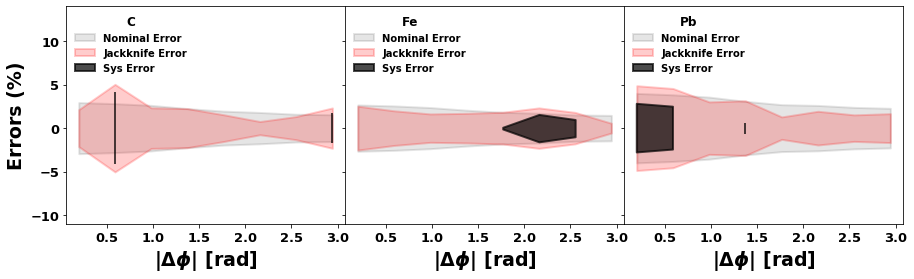

In [30]:
##%%script false --no-raise-error
## Jacknife calculations:
sector={}
sector_err={}
mean_bin={}
mean_subsample={}


sector['C_0'] =  np.array([ 0.9468005036007072 , 
 0.9678604139196946 , 
 0.9756559845359065 , 
 0.9550695036321545 , 
 0.874617957467062 , 
 0.8504499116056976 , 
 0.8095708328155456 , 
 0.8705492238900348 , ])
sector['C_1'] =  np.array([ 1.0877613713434608 , 
 1.1692459863856708 , 
 1.0618867044267168 , 
 1.0732923501405311 , 
 0.9107721252369108 , 
 0.8574902292510571 , 
 0.8451969130421083 , 
 0.7956025844512223 , ])
sector['C_2'] =  np.array([ 1.0241468838079029 , 
 1.054567982043001 , 
 0.9185700104661915 , 
 0.9993784271128864 , 
 0.8885083712105273 , 
 0.8373336185480689 , 
 0.8077534240536828 , 
 0.8309892786169099 , ])
sector['C_3'] =  np.array([ 1.0360759803306168 , 
 0.8934468176798556 , 
 0.9281040761569009 , 
 0.9508892057703499 , 
 0.9398612736502099 , 
 0.8830438967227718 , 
 0.850419119110559 , 
 0.8216960519340204 , ])
sector['C_4'] =  np.array([ 1.0130883720265647 , 
 1.0601507363151872 , 
 1.0205615433942412 , 
 0.9291113709811728 , 
 0.8656520075103716 , 
 0.8486445071950032 , 
 0.8773860471484366 , 
 0.8662965382800708 , ])
sector['C_5'] =  np.array([ 0.9539871084569521 , 
 0.8501523132637451 , 
 0.9633260430762088 , 
 0.9622320140558885 , 
 0.9437398482113728 , 
 0.8596369057271719 , 
 0.8358093140409579 , 
 0.75184754535788 , ])


#ERRORS 


sector_err['C_0'] =  np.array([ 0.06423286316123447 , 
 0.0646369623318227 , 
 0.05823635438639208 , 
 0.049574153428889024 , 
 0.03925747421765514 , 
 0.035558624679598576 , 
 0.03050525343457722 , 
 0.030751889958550844 , ])
sector_err['C_1'] =  np.array([ 0.07487857698894212 , 
 0.0809431634202404 , 
 0.06863753842980454 , 
 0.0613006410722746 , 
 0.04266377359109655 , 
 0.03625731877925424 , 
 0.030516651763527993 , 
 0.027933970647872057 , ])
sector_err['C_2'] =  np.array([ 0.08457030331272428 , 
 0.08022963181947355 , 
 0.061713307050031016 , 
 0.056571107674173365 , 
 0.04435823611175027 , 
 0.037881302874961276 , 
 0.0321932525707675 , 
 0.03140496737583038 , ])
sector_err['C_3'] =  np.array([ 0.07183691452820826 , 
 0.061480514962437824 , 
 0.06172584934527229 , 
 0.05430075923191888 , 
 0.046292701541674315 , 
 0.039003052606654445 , 
 0.033778420361842657 , 
 0.030315546899036983 , ])
sector_err['C_4'] =  np.array([ 0.08915623466152163 , 
 0.0904742479031907 , 
 0.07950970145858498 , 
 0.05829621695069671 , 
 0.04680914714494083 , 
 0.041356734748952274 , 
 0.03709931576454329 , 
 0.034315376267952294 , ])
sector_err['C_5'] =  np.array([ 0.06509493562859177 , 
 0.056243173955772836 , 
 0.06101370311823184 , 
 0.052580970761084665 , 
 0.04506377964614385 , 
 0.03772817885206698 , 
 0.03273618328285679 , 
 0.028532515215563256 , ])


sector['Fe_0'] =  np.array([ 0.9767443043221788 , 
 0.9109893406921241 , 
 0.9171686878503181 , 
 0.8294331236002163 , 
 0.8057060014207208 , 
 0.7016995626389506 , 
 0.7475788531841134 , 
 0.7048184698588712 , ])
sector['Fe_1'] =  np.array([ 0.9921128879978129 , 
 0.9899537467732715 , 
 0.9008332888144462 , 
 0.8818570461550048 , 
 0.857888442225755 , 
 0.7602477569126029 , 
 0.755472312628986 , 
 0.6897871393408034 , ])
sector['Fe_2'] =  np.array([ 1.07565936272428 , 
 0.967987519721029 , 
 0.9439047384332837 , 
 0.9234491995484957 , 
 0.8378250255726004 , 
 0.7240231854823957 , 
 0.7262963200601574 , 
 0.7102554166562931 , ])
sector['Fe_3'] =  np.array([ 1.1101225565885113 , 
 0.9980782324168824 , 
 0.8680490833058502 , 
 0.9246139895765008 , 
 0.78301660618193 , 
 0.8218870947053012 , 
 0.70284665703445 , 
 0.6967083148144285 , ])
sector['Fe_4'] =  np.array([ 1.060581904326987 , 
 0.9360560188224738 , 
 0.9448574305038798 , 
 0.8832985373043846 , 
 0.8390964265242714 , 
 0.7457726462776102 , 
 0.673389400171149 , 
 0.7109203027961994 , ])
sector['Fe_5'] =  np.array([ 0.9666499517219552 , 
 0.8859688121512151 , 
 0.9654169798447588 , 
 0.9120679120466391 , 
 0.7709873678190026 , 
 0.7454998513234266 , 
 0.7392569661812771 , 
 0.6925573956733745 , ])


#ERRORS 


sector_err['Fe_0'] =  np.array([ 0.06201134274670984 , 
 0.056129511425427416 , 
 0.05135617335643534 , 
 0.04165217021533712 , 
 0.03542580936795115 , 
 0.02990972962170966 , 
 0.02732918006164592 , 
 0.024657906907373284 , ])
sector_err['Fe_1'] =  np.array([ 0.06629607965471385 , 
 0.06337138172755585 , 
 0.05550208467820594 , 
 0.046292853675079154 , 
 0.039372552443743804 , 
 0.031802300888327834 , 
 0.027623537323384528 , 
 0.02384208239821451 , ])
sector_err['Fe_2'] =  np.array([ 0.08190771436984816 , 
 0.07243414448396084 , 
 0.06098290131014394 , 
 0.049741654402289136 , 
 0.03858722559224919 , 
 0.03166738181631339 , 
 0.027655197252749043 , 
 0.025681395022750755 , ])
sector_err['Fe_3'] =  np.array([ 0.06851719356761121 , 
 0.06046792728787569 , 
 0.052149579847630585 , 
 0.04903477088561756 , 
 0.03500896069219073 , 
 0.033319708202925014 , 
 0.02523058861487816 , 
 0.02356284075689441 , ])
sector_err['Fe_4'] =  np.array([ 0.06802140992501463 , 
 0.05900888293153249 , 
 0.05336167997292493 , 
 0.043499657454349236 , 
 0.036283612344086606 , 
 0.030763038766889544 , 
 0.02487689631166949 , 
 0.02489809201193942 , ])
sector_err['Fe_5'] =  np.array([ 0.06020693181850826 , 
 0.05428899693861943 , 
 0.05453879703514405 , 
 0.0451683968477339 , 
 0.03414976432530865 , 
 0.03015936589017684 , 
 0.027152847581048155 , 
 0.02441164801108905 , ])



sector['Pb_0'] =  np.array([ 0.8106095255968263 , 
 0.8314575071320583 , 
 0.931779544190012 , 
 0.8410709149635974 , 
 0.8113417835241947 , 
 0.7072949026436987 , 
 0.6373637374137897 , 
 0.6550865566229221 , ])
sector['Pb_1'] =  np.array([ 0.9333834540874657 , 
 0.9457707937766645 , 
 0.9445286088566952 , 
 0.7830975719154077 , 
 0.7917593851010356 , 
 0.7358085100200592 , 
 0.6371137013500409 , 
 0.6177562161653737 , ])
sector['Pb_2'] =  np.array([ 1.0905795333427504 , 
 0.8684244432173753 , 
 0.9324885414875096 , 
 0.9564565100640682 , 
 0.8304637244486266 , 
 0.7199518771189208 , 
 0.67392607618274 , 
 0.6426597430604211 , ])
sector['Pb_3'] =  np.array([ 0.9567970841679738 , 
 0.8375174683339437 , 
 0.9101768690511867 , 
 0.8494544665292051 , 
 0.7871717179181706 , 
 0.6803608291298282 , 
 0.6457418604207595 , 
 0.6773337308809118 , ])
sector['Pb_4'] =  np.array([ 0.833973197166692 , 
 0.9264250830240282 , 
 0.9707498892897091 , 
 0.9192237906548427 , 
 0.8552646308224979 , 
 0.7348734532355872 , 
 0.6033383608084616 , 
 0.6253297226294307 , ])
sector['Pb_5'] =  np.array([ 1.0386110310614283 , 
 1.0974585815859939 , 
 0.788944917825508 , 
 0.8345468689677593 , 
 0.8145410086978809 , 
 0.6550301811423211 , 
 0.650012506210298 , 
 0.60980637228679 , ])


#ERRORS 


sector_err['Pb_0'] =  np.array([ 0.07869769541694627 , 
 0.07989577591506442 , 
 0.07639683671091119 , 
 0.06066385754622937 , 
 0.052492079966697476 , 
 0.04394962316106531 , 
 0.036559780526575804 , 
 0.03506315807210182 , ])
sector_err['Pb_1'] =  np.array([ 0.09016571946400893 , 
 0.08937025686486967 , 
 0.08460034472117114 , 
 0.06308956892191347 , 
 0.054746944951021004 , 
 0.04517618873393918 , 
 0.035736790513096535 , 
 0.03366432305863679 , ])
sector_err['Pb_2'] =  np.array([ 0.12641643312656628 , 
 0.09726665022295529 , 
 0.08846219542873696 , 
 0.07339435192164474 , 
 0.05808441774594255 , 
 0.04791162088561075 , 
 0.040481092520653746 , 
 0.0372703213661398 , ])
sector_err['Pb_3'] =  np.array([ 0.08981619804025588 , 
 0.08290179884501257 , 
 0.08155974486739526 , 
 0.06750530529417516 , 
 0.05396092877848673 , 
 0.04402701790139229 , 
 0.03634811123218481 , 
 0.03558210126520284 , ])
sector_err['Pb_4'] =  np.array([ 0.08773389869002685 , 
 0.08661326785105333 , 
 0.08393224911764154 , 
 0.06774461188441179 , 
 0.055097133391757175 , 
 0.04754589339302405 , 
 0.03616189819360058 , 
 0.03555033536914761 , ])
sector_err['Pb_5'] =  np.array([ 0.09410292159655899 , 
 0.09346308747928012 , 
 0.06999456510228966 , 
 0.06278999172398193 , 
 0.05238298538464164 , 
 0.041996181088016865 , 
 0.036560361285476156 , 
 0.03357141480123794 , ])


jackknife_var={}
for tar in ['C', 'Fe','Pb']:
    print('For ', tar)
    for i in range(dpiondphiBinsEdges-1):
        mean=0
        for j in range(6):
            mean = mean + sector['%s_%d'%(tar,j)][i]
        #print('bin =', i , '; total mean:',mean/6.)
        mean_bin['%s_%d'%(tar,i)]=mean/6.
    
    for i in range(dpiondphiBinsEdges-1):    
        for j in range(6):
            mean=0
            for jj in range (6):
                if jj==j:    mean = mean + 0
                else: mean = mean + sector['%s_%d'%(tar,jj)][i]
            if False:    print('bin =', i ,j, 'without value ',j , '; mean:',mean/5.)
            mean_subsample['%s_%d_%d'%(tar,i,j)] = mean/5.0
    
    tmp = np.empty(dpiondphiBinsEdges-1)        
    for i in range(dpiondphiBinsEdges-1):
        sum=0
        for j in range(6):
            sum = sum + (mean_subsample['%s_%d_%d'%(tar,i,j)] - mean_bin['%s_%d'%(tar,i)] )*(mean_subsample['%s_%d_%d'%(tar,i,j)] - mean_bin['%s_%d'%(tar,i)] )
            #if i==0:    print(mean_subsample['%s_%d_%d'%(tar,i,j)] , ' - ',mean_bin['%s_%d'%(tar,i)] )
        print('variance associated with bin ',i, ' is ', ((6-1)/6.)*sum )   
        #jackknife_var['%s_%d'%(tar,i)] = ((6-1)/6.)*sum
        tmp[i] = ( ((6.-1.)/6.)*sum )
    jackknife_var['%s'%(tar)] = tmp

        
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['black','black','black']
colorBands_jack=['red','red','red']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']
colorBandssys=['black','black','black']        
        
for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                       trig_cut=trigger_cut_nom)
  
    #axs[i].errorbar(x_nom,r_nom,yerr=err_nom,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],lw=2,alpha=0.1, label='Nominal Error')
    axs[i].fill_between(x_nom,(  np.sqrt(jackknife_var['%s'%(target)] )/r_nom  )*100,-(np.sqrt(jackknife_var['%s'%(target)])/r_nom )*100,color=colorBands_jack[i],alpha=0.2, label='Jackknife Error', lw=2)
            
    sys2= ( (jackknife_var['%s'%(target)] )  -  (err_nom*err_nom) )
    sys=(np.sqrt(sys2)/r_nom)
    axs[i].fill_between(x_nom,sys*100,-sys*100,color=colorBandssys[i],alpha=0.7, label='Sys Error', lw=2)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=10, title='%s'%target, title_fontsize=12)
        
for i,j in enumerate(['C','Fe','Pb']):
    #axs[0][i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Errors (%)',fontsize=19,fontweight="bold")
axs[0].set_ylim(-11,14)


#plt.savefig('sys_diH_Sectors_dphi_R2h_exclusion_jack_comparison.png', bbox_inches='tight')
#plt.savefig('sys_diH_Sectors_dphi_R2h_exclusion_jack_comparison.pdf', bbox_inches='tight')
        
#for i in range(8):    print(mean_bin['%s_%d'%(tar,i)])  
#for i in range(8):    print( sqrt(    )  )
#print(jackknife_var['C'])
#print(jackknife_var['Fe'])
#print(jackknife_var['Pb'])

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==3
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==0
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==2
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

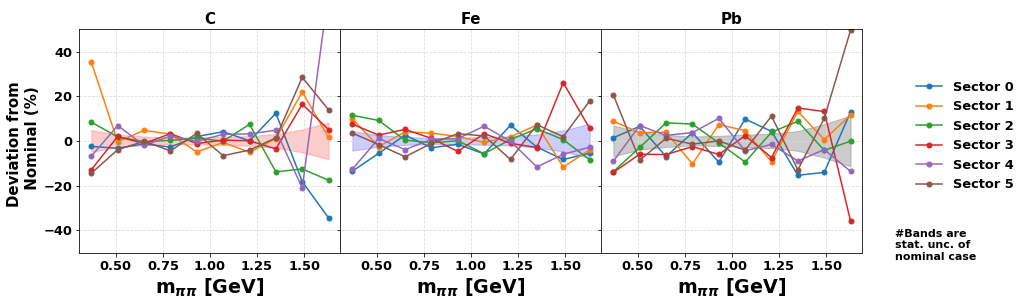

In [31]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass',  
                                    pair_cut = '%s  '%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s  '%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s  '%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s  '%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    y_dev_nom_var4 =  ((r_var4 - r_nom)/ r_nom )*100.
    y_dev_nom_var5 =  ((r_var5 - r_nom)/ r_nom )*100.
    y_dev_nom_var6 =  ((r_var6 - r_nom)/ r_nom )*100.    
    
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom,y_dev_nom_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
axs[0].set_ylim(-50,50)
#plt.savefig('sys_diH_Sectors_dpionMass.pdf', bbox_inches='tight')
#plt.savefig('sys_diH_Sectors_dpionMass.png', bbox_inches='tight')
plt.show()

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==2
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

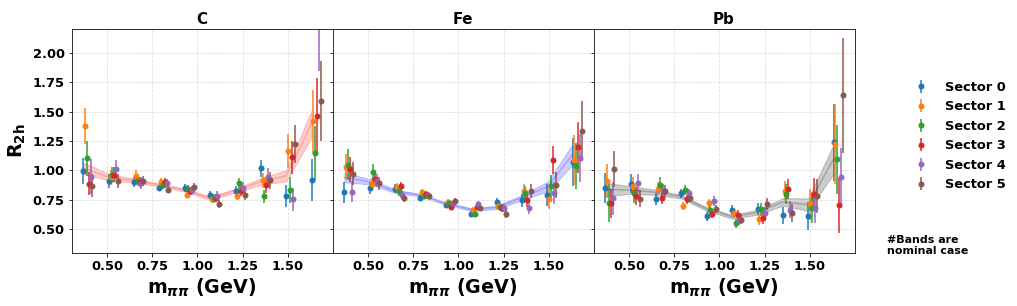

In [32]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass', 
                                    pair_cut = '%s   and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].errorbar(x_nom,r_nom,yerr=err_nom,fmt='-o',ms=5)
    axs[i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s  '%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s  '%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)
    shift=0.01
    axs[i].errorbar(x_nom+shift*0,r_var1,yerr=err_var1,fmt='o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*1,r_var2,yerr=err_var2,fmt='o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*2,r_var3,yerr=err_var3,fmt='o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*3,r_var4,yerr=err_var4,fmt='o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*4,r_var5,yerr=err_var5,fmt='o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*5,r_var6,yerr=err_var6,fmt='o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ (GeV)',fontsize=19,fontweight="bold")
axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
axs[0].set_ylim(0.3,2.2)
fig.text(0.88, 0.15, '#Bands are \nnominal case', fontsize=11, va='center')

outname='sys_diH_Sectors_dipionMass_R2h'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')



plt.show()

**Excluding sector one by one, as a function of Inv Mass**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=3
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=0
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector!=2
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

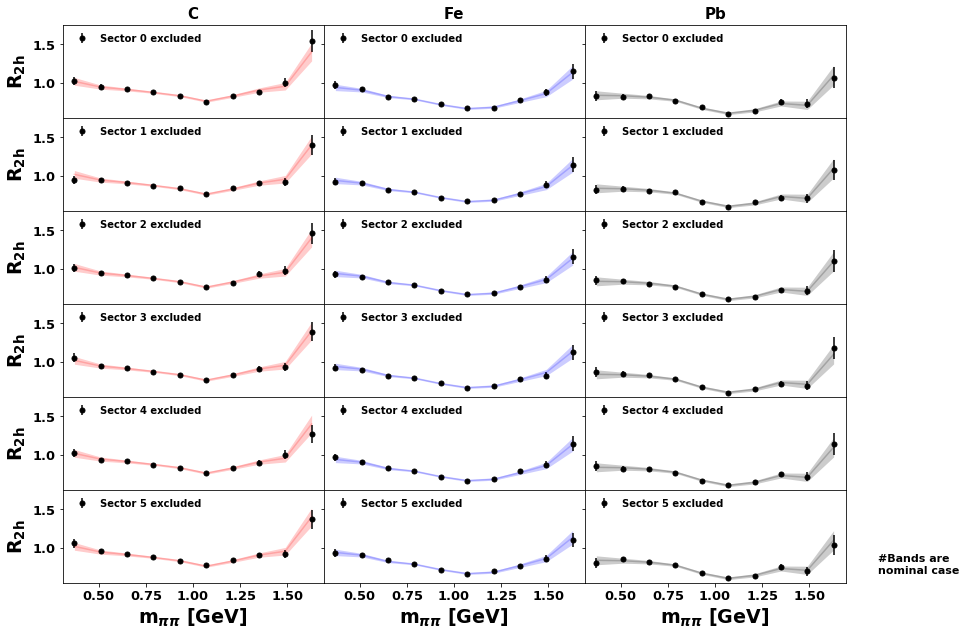

In [33]:
fig, axs = plt.subplots(6, 3,sharex=True, sharey=True,figsize=(15,10),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0 excluded','Sector 1 excluded','Sector 2 excluded','Sector 3 excluded','Sector 4 excluded','Sector 5 excluded']

pair_cut_var1='%s and h1_Sector!=0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector!=1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector!=2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector!=3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector!=4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector!=5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector!=0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector!=1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector!=2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector!=3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector!=4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector!=5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass',  
                                    pair_cut = '%s  '%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
                                    
    axs[0][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[1][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[2][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[3][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[4][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[5][i].errorbar(x_nom,r_nom,yerr=0,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    
    axs[0][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[1][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[2][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[3][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[4][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    axs[5][i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2,lw=0)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s  '%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
                                       
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
                                       
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s  '%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
                                       
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s  '%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)

    
    shift=0.001
    axs[0][i].errorbar(x_nom+shift*0,r_var1,yerr=err_var1,fmt='o',ms=5,label=tmp_label[0], color='black')  
    axs[1][i].errorbar(x_nom+shift*0,r_var2,yerr=err_var2,fmt='o',ms=5,label=tmp_label[1], color='black')
    axs[2][i].errorbar(x_nom+shift*0,r_var3,yerr=err_var3,fmt='o',ms=5,label=tmp_label[2], color='black')  
    axs[3][i].errorbar(x_nom+shift*0,r_var4,yerr=err_var4,fmt='o',ms=5,label=tmp_label[3], color='black')
    axs[4][i].errorbar(x_nom+shift*0,r_var5,yerr=err_var5,fmt='o',ms=5,label=tmp_label[4], color='black')  
    axs[5][i].errorbar(x_nom+shift*0,r_var6,yerr=err_var6,fmt='o',ms=5,label=tmp_label[5], color='black')    
    
    #axs[0][i].grid(axis="x",color='gainsboro', linestyle='dashed')
    #axs[0][i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
for i in range (3):
    for ii in range(6):
        axs[ii][i].legend(loc='upper left',ncol=1,frameon=False,fontsize=10, title='', title_fontsize=20)
for i,j in enumerate(['C','Fe','Pb']):
    axs[0][i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[5][i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
for j in range (6):    axs[j][0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=19,fontweight="bold")
axs[0][0].set_ylim(0.55,1.75)
fig.text(0.88, 0.15, '#Bands are \nnominal case', fontsize=11, va='center')

outname='sys_diH_Sectors_dpionMass_exclusion'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')



plt.show()




**Jackknife calculations**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==3
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==0
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==0
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_Sector==4
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700

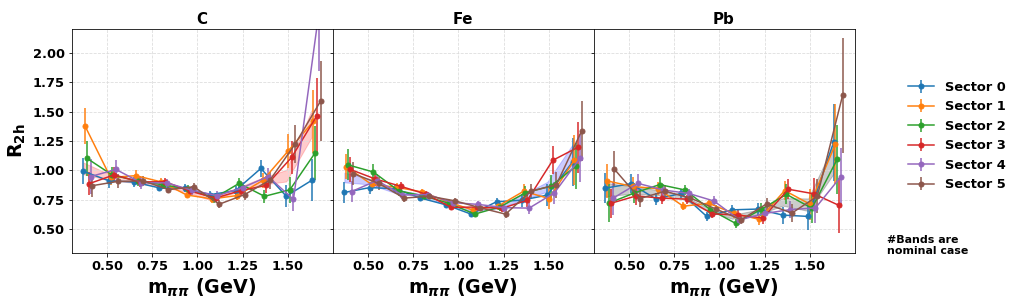

In [34]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']

pair_cut_var1='%s and h1_Sector==0'%pair_cut_nom
pair_cut_var2='%s and h1_Sector==1'%pair_cut_nom
pair_cut_var3='%s and h1_Sector==2'%pair_cut_nom
pair_cut_var4='%s and h1_Sector==3'%pair_cut_nom
pair_cut_var5='%s and h1_Sector==4'%pair_cut_nom
pair_cut_var6='%s and h1_Sector==5'%pair_cut_nom

trigger_cut_var1 = '%s and h1_Sector==0'%trigger_cut_nom
trigger_cut_var2 = '%s and h1_Sector==1'%trigger_cut_nom
trigger_cut_var3 = '%s and h1_Sector==2'%trigger_cut_nom
trigger_cut_var4 = '%s and h1_Sector==3'%trigger_cut_nom
trigger_cut_var5 = '%s and h1_Sector==4'%trigger_cut_nom
trigger_cut_var6 = '%s and h1_Sector==5'%trigger_cut_nom

#trigger_cut_var1 = '%s '%trigger_cut_nom
#trigger_cut_var2 = '%s '%trigger_cut_nom
#trigger_cut_var3 = '%s '%trigger_cut_nom
#trigger_cut_var4 = '%s '%trigger_cut_nom
#trigger_cut_var5 = '%s '%trigger_cut_nom
#trigger_cut_var6 = '%s '%trigger_cut_nom


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass', 
                                    pair_cut = '%s   and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].errorbar(x_nom,r_nom,yerr=err_nom,fmt='-o',ms=5)
    axs[i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)   
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var3,
                                       trig_cut=trigger_cut_var3)
    r_var4, err_var4,x_var4 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s  '%pair_cut_var4,
                                       trig_cut=trigger_cut_var4)
    
    r_var5, err_var5,x_var5 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s  '%pair_cut_var5,
                                       trig_cut=trigger_cut_var5)
    r_var6, err_var6,x_var6 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s  '%pair_cut_var6,
                                       trig_cut=trigger_cut_var6)
    
    
    shift=0.01
    axs[i].errorbar(x_nom+shift*0,r_var1,yerr=err_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*1,r_var2,yerr=err_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*2,r_var3,yerr=err_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*3,r_var4,yerr=err_var4,fmt='-o',ms=5,label=tmp_label[3]if i == 0 else "")
    axs[i].errorbar(x_nom+shift*4,r_var5,yerr=err_var5,fmt='-o',ms=5,label=tmp_label[4]if i == 0 else "")  
    axs[i].errorbar(x_nom+shift*5,r_var6,yerr=err_var6,fmt='-o',ms=5,label=tmp_label[5]if i == 0 else "")    
    
    for ii in range(dpionMassBinsEdges-1):
        print('sector[\'%s_0\'] =  np.array(['%(target)if ii==0 else "", r_var1[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    for ii in range(dpionMassBinsEdges-1):        
        print('sector[\'%s_1\'] =  np.array(['%(target)if ii==0 else "", r_var2[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    for ii in range(dpionMassBinsEdges-1):        
        print('sector[\'%s_2\'] =  np.array(['%(target)if ii==0 else "", r_var3[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    for ii in range(dpionMassBinsEdges-1):        
        print('sector[\'%s_3\'] =  np.array(['%(target)if ii==0 else "", r_var4[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    for ii in range(dpionMassBinsEdges-1):        
        print('sector[\'%s_4\'] =  np.array(['%(target)if ii==0 else "", r_var5[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    for ii in range(dpionMassBinsEdges-1):        
        print('sector[\'%s_5\'] =  np.array(['%(target)if ii==0 else "", r_var6[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    
    
    
    print('\n\n ERRORS \n\n')    
    
    for ii in range(dpionMassBinsEdges-1):
        print('sector_err[\'%s_0\'] =  np.array(['%(target)if ii==0 else "", err_var1[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    for ii in range(dpionMassBinsEdges-1):        
        print('sector_err[\'%s_1\'] =  np.array(['%(target)if ii==0 else "", err_var2[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    for ii in range(dpionMassBinsEdges-1):        
        print('sector_err[\'%s_2\'] =  np.array(['%(target)if ii==0 else "", err_var3[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    for ii in range(dpionMassBinsEdges-1):        
        print('sector_err[\'%s_3\'] =  np.array(['%(target)if ii==0 else "", err_var4[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    for ii in range(dpionMassBinsEdges-1):        
        print('sector_err[\'%s_4\'] =  np.array(['%(target)if ii==0 else "", err_var5[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    for ii in range(dpionMassBinsEdges-1):        
        print('sector_err[\'%s_5\'] =  np.array(['%(target)if ii==0 else "", err_var6[ii], ',', '])'if ii==dpionMassBinsEdges-2 else ""    )
    
   
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ (GeV)',fontsize=19,fontweight="bold")
axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
axs[0].set_ylim(0.3,2.2)
fig.text(0.88, 0.15, '#Bands are \nnominal case', fontsize=11, va='center')


plt.show()

For  C
variance associated with bin  0  is  0.0030394283610123223
variance associated with bin  1  is  0.00038559469497037076
variance associated with bin  2  is  0.00015960745731981156
variance associated with bin  3  is  0.00018556536706286735
variance associated with bin  4  is  7.147117074467535e-05
variance associated with bin  5  is  5.9764192448061765e-05
variance associated with bin  6  is  0.00020005186470837993
variance associated with bin  7  is  0.0011994104516984292
variance associated with bin  8  is  0.008570899033039672
variance associated with bin  9  is  0.03517473669759244
For  Fe
variance associated with bin  0  is  0.0010115273876589227
variance associated with bin  1  is  0.0002045431980382309
variance associated with bin  2  is  0.0002464188115903159
variance associated with bin  3  is  2.257158561927163e-05
variance associated with bin  4  is  7.495116062141405e-05
variance associated with bin  5  is  0.00010790851109561994
variance associated with bin  6  is  0

<ipython-input-35-295c1560d42f>:436: RuntimeWarning: invalid value encountered in sqrt
  sys=(np.sqrt(sys2)/r_nom)


Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

(-11, 14)

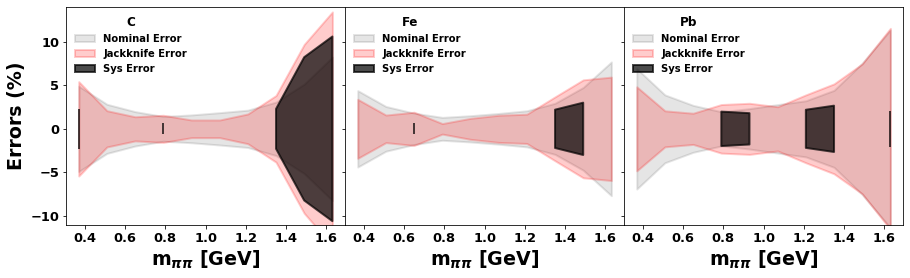

In [35]:
##%%script false --no-raise-error
## Jacknife calculations:
sector={}
sector_err={}
mean_bin={}
mean_subsample={}

sector['C_0'] =  np.array([ 0.9190227735125739 , 
 0.9306220125492324 , 
 0.9211042533908449 , 
 0.8400099029863161 , 
 0.8505519494224115 , 
 0.8120534609462831 , 
 0.8601140670903846 , 
 1.0499752071626447 , 
 0.939514050888903 , 
 1.0515330338795033 , ])
sector['C_1'] =  np.array([ 1.2440130870131925 , 
 0.9336552217453505 , 
 0.9751440103254762 , 
 0.9140406162464986 , 
 0.8095119537248149 , 
 0.778860367521303 , 
 0.839503638796457 , 
 1.0181175211096358 , 
 1.3727201348470006 , 
 1.3683324449182659 , ])
sector['C_2'] =  np.array([ 1.0319373622948445 , 
 0.9304329170500404 , 
 0.8873182290774967 , 
 0.8787308295358152 , 
 0.8453650784506505 , 
 0.7844341241584509 , 
 0.9071104990197606 , 
 0.8129680510240406 , 
 0.9230370194862074 , 
 1.209417282980679 , ])
sector['C_3'] =  np.array([ 0.9416800666326001 , 
 0.9767150501774321 , 
 0.9263537453290513 , 
 0.8967776596314235 , 
 0.8186285838392375 , 
 0.7732893974906357 , 
 0.8436379358579821 , 
 0.9415812191879052 , 
 1.224616049955698 , 
 1.5586022453981612 , ])
sector['C_4'] =  np.array([ 1.0056783542197418 , 
 1.0218494843201276 , 
 0.9111351676614885 , 
 0.8963847558373002 , 
 0.8059204552993748 , 
 0.7823666979170077 , 
 0.8993231420308747 , 
 0.9969828645738344 , 
 0.8688789210811072 , 
 2.306303719302379 , ])
sector['C_5'] =  np.array([ 0.8563685928974678 , 
 0.8808798049679577 , 
 0.8963308729276267 , 
 0.8316121404280375 , 
 0.8488940540567167 , 
 0.7535911555258884 , 
 0.8204385073239648 , 
 1.002821429911157 , 
 1.3398272854438007 , 
 1.8431486466422655 , ])


# ERRORS 


sector_err['C_0'] =  np.array([ 0.08064362405837587 , 
 0.05199423261965361 , 
 0.039946475925915485 , 
 0.02858444519958271 , 
 0.03314506199180122 , 
 0.03736222665165848 , 
 0.04490305059440867 , 
 0.07563889978689782 , 
 0.10648863092654966 , 
 0.19478560422834665 , ])
sector_err['C_1'] =  np.array([ 0.1076350868673428 , 
 0.05572921718021193 , 
 0.04454646430854252 , 
 0.03214077626785825 , 
 0.03208312910065775 , 
 0.034563678839958666 , 
 0.04262206476955292 , 
 0.0717159956298124 , 
 0.16012103310070117 , 
 0.2508785173738285 , ])
sector_err['C_2'] =  np.array([ 0.10654400303779021 , 
 0.05995440269029637 , 
 0.04401969488698851 , 
 0.03261232008360032 , 
 0.035319687619168684 , 
 0.03852638759878734 , 
 0.048952542493248305 , 
 0.06153073475848319 , 
 0.12200426728430416 , 
 0.23123917924866172 , ])
sector_err['C_3'] =  np.array([ 0.08249018332762766 , 
 0.05737700106219246 , 
 0.04262290057412808 , 
 0.03288720048887659 , 
 0.03450705379436073 , 
 0.03727973446254201 , 
 0.046882459699434845 , 
 0.07102350359198063 , 
 0.14540346721238762 , 
 0.3237072256114038 , ])
sector_err['C_4'] =  np.array([ 0.11670299857362845 , 
 0.06997242419710469 , 
 0.04941616765948937 , 
 0.03607631680499434 , 
 0.037724310253769155 , 
 0.03989885961890384 , 
 0.05343360154018974 , 
 0.08042044253972741 , 
 0.10411519825254088 , 
 0.4489540581523717 , ])
sector_err['C_5'] =  np.array([ 0.0776457470410029 , 
 0.05204569932330638 , 
 0.040866156806291645 , 
 0.02932501873344763 , 
 0.034363644668740645 , 
 0.03685568867584817 , 
 0.044986770951083645 , 
 0.07762067133126108 , 
 0.1674988585665998 , 
 0.3762311420312438 , ])

sector['Fe_0'] =  np.array([ 0.8122707166895473 , 
 0.8506203927365803 , 
 0.8625498750963514 , 
 0.7770782379938289 , 
 0.7090754676438051 , 
 0.6593494772292865 , 
 0.7560243159758598 , 
 0.8634714184238594 , 
 0.9115540304271292 , 
 1.2327795897740945 , ])
sector['Fe_1'] =  np.array([ 1.0104491723113562 , 
 0.8921577412808663 , 
 0.8599168276270716 , 
 0.8114395310330789 , 
 0.7210932729676497 , 
 0.6888861856192677 , 
 0.7061946187244147 , 
 0.9280391138135686 , 
 0.9001979403991616 , 
 1.1329722362003178 , ])
sector['Fe_2'] =  np.array([ 1.0066207702464411 , 
 0.9169931248043459 , 
 0.8266980906716727 , 
 0.7916682463209412 , 
 0.7363486978615114 , 
 0.6677795672190291 , 
 0.7130662963598753 , 
 0.9214105702348439 , 
 1.0537152029584764 , 
 1.1483212118928288 , ])
sector['Fe_3'] =  np.array([ 0.9498832820257667 , 
 0.8404480795888561 , 
 0.8886567788707481 , 
 0.7888265365129068 , 
 0.7105611891434903 , 
 0.7041899549777049 , 
 0.7006239019426558 , 
 0.8830487735313187 , 
 1.219988206789853 , 
 1.3837443134941303 , ])
sector['Fe_4'] =  np.array([ 0.8738674242147353 , 
 0.9087235878585366 , 
 0.8127939126336363 , 
 0.8004539779305582 , 
 0.717767020226611 , 
 0.7297353790108669 , 
 0.7282352858273201 , 
 0.7372642222015986 , 
 0.9660207162228348 , 
 1.2504677834463436 , ])
sector['Fe_5'] =  np.array([ 0.957418110304819 , 
 0.8410440797485338 , 
 0.783353234238072 , 
 0.7978225171498496 , 
 0.7650813886423603 , 
 0.6951909709206145 , 
 0.6719378826589907 , 
 0.8683472776487818 , 
 0.9837637427756979 , 
 1.5689878029770195 , ])


# ERRORS 


sector_err['Fe_0'] =  np.array([ 0.06762416984045608 , 
 0.04582186863823875 , 
 0.035478206557064754 , 
 0.025726181471218613 , 
 0.027682690262955226 , 
 0.02996973745811053 , 
 0.03829502903085922 , 
 0.06156152966342918 , 
 0.10495243253112048 , 
 0.21424426045008751 , ])
sector_err['Fe_1'] =  np.array([ 0.08169239354887105 , 
 0.050490610770594815 , 
 0.038098839835962676 , 
 0.02752490653748561 , 
 0.027857167744556783 , 
 0.030916525966682377 , 
 0.03609270074700251 , 
 0.06567269784040333 , 
 0.10348899735544105 , 
 0.21857858271003408 , ])
sector_err['Fe_2'] =  np.array([ 0.09580912288467391 , 
 0.05632539657187175 , 
 0.03872580760842665 , 
 0.027436443579540032 , 
 0.030025110679403354 , 
 0.032334622778538546 , 
 0.03810063748043607 , 
 0.06439917155485625 , 
 0.11534732424543709 , 
 0.19871772084191097 , ])
sector_err['Fe_3'] =  np.array([ 0.0742320627143733 , 
 0.04653420386703716 , 
 0.03698817798999736 , 
 0.02602790883693586 , 
 0.02740886053891476 , 
 0.030975616488139415 , 
 0.03581850695881903 , 
 0.0599919170091862 , 
 0.12759205082330047 , 
 0.2400987679110549 , ])
sector_err['Fe_4'] =  np.array([ 0.07194215353637384 , 
 0.04865300874409033 , 
 0.03333605215734736 , 
 0.026241395524806227 , 
 0.027748133975309643 , 
 0.03275198804465227 , 
 0.037801784627735015 , 
 0.05258629909647702 , 
 0.10404554206645988 , 
 0.22627691450226525 , ])
sector_err['Fe_5'] =  np.array([ 0.07575695882134038 , 
 0.04553124286655211 , 
 0.032908001486116285 , 
 0.02565024255206765 , 
 0.02899932206557673 , 
 0.030683870705897825 , 
 0.03592517463389941 , 
 0.06312641273766363 , 
 0.11996837747910448 , 
 0.2788742410753484 , ])

sector['Pb_0'] =  np.array([ 0.8136172542549546 , 
 0.8186543783376837 , 
 0.7590494167656215 , 
 0.789306935942656 , 
 0.6065458893918312 , 
 0.6981431092101338 , 
 0.7089393755170271 , 
 0.6916789002289816 , 
 0.669982890829938 , 
 1.2554021943838571 , ])
sector['Pb_1'] =  np.array([ 0.7540103050613067 , 
 0.8275197250847495 , 
 0.8313508349231047 , 
 0.6686118396588985 , 
 0.7300824127209189 , 
 0.6404730773966908 , 
 0.6064191427492334 , 
 0.8935649673125348 , 
 0.7871071740472461 , 
 1.3544974604621023 , ])
sector['Pb_2'] =  np.array([ 0.805460205663113 , 
 0.8281277150685317 , 
 0.8401212010665006 , 
 0.8181354070668582 , 
 0.6827819898352314 , 
 0.6212430296720362 , 
 0.6824733676165465 , 
 0.906232068128507 , 
 0.6878301397095367 , 
 1.3191985801870671 , ])
sector['Pb_3'] =  np.array([ 0.9195787872776565 , 
 0.7908276520387864 , 
 0.7607889751072636 , 
 0.7595363443492178 , 
 0.636039204888077 , 
 0.6704712717119294 , 
 0.6642988223837262 , 
 0.8763329322311536 , 
 1.0051909706262308 , 
 0.8520012520706827 , ])
sector['Pb_4'] =  np.array([ 0.7660289754993935 , 
 0.8643786049413593 , 
 0.796386986419257 , 
 0.7914210353814283 , 
 0.7190987622870927 , 
 0.6165228799435445 , 
 0.6097649350592599 , 
 0.7566442407306414 , 
 0.839847405800525 , 
 0.9993703260459322 , ])
sector['Pb_5'] =  np.array([ 1.0072146402200868 , 
 0.7402747941889717 , 
 0.8235964073693777 , 
 0.7389044138344694 , 
 0.6527715487025685 , 
 0.5969302778358376 , 
 0.7676516589716696 , 
 0.7371647588767061 , 
 0.9090935582296273 , 
 1.7429989274327442 , ])


# ERRORS 


sector_err['Pb_0'] =  np.array([ 0.09858717925693027 , 
 0.06629992875782 , 
 0.047295604965043515 , 
 0.03767553200036824 , 
 0.03710953478080913 , 
 0.0473716648435307 , 
 0.05533702152976075 , 
 0.07770754677586683 , 
 0.12599460035998702 , 
 0.32158540990397366 , ])
sector_err['Pb_1'] =  np.array([ 0.09876532281921907 , 
 0.07014912937168465 , 
 0.05371868445152464 , 
 0.03584818401324881 , 
 0.04175457993025373 , 
 0.04370807985881442 , 
 0.04894089597500345 , 
 0.08741880611753769 , 
 0.139134271090583 , 
 0.35959529777095744 , ])
sector_err['Pb_2'] =  np.array([ 0.12363942032336163 , 
 0.07819035054254228 , 
 0.05819592949120754 , 
 0.04253742756849758 , 
 0.043629422950457755 , 
 0.04694523292625929 , 
 0.05755897765342476 , 
 0.09628102843306703 , 
 0.12739355162277052 , 
 0.3302168490656239 , ])
sector_err['Pb_3'] =  np.array([ 0.11041589003290316 , 
 0.06724096427659708 , 
 0.050711456391766545 , 
 0.0386635730109266 , 
 0.03871001372150306 , 
 0.045778869112283335 , 
 0.05252640069796212 , 
 0.08814748752865881 , 
 0.15725120902646855 , 
 0.2554726712037298 , ])
sector_err['Pb_4'] =  np.array([ 0.10263239345809234 , 
 0.07061491066080683 , 
 0.05105194443663348 , 
 0.03917030109691029 , 
 0.04305006765145013 , 
 0.045677480121175174 , 
 0.05392717582599877 , 
 0.08270665041620476 , 
 0.14504124835625312 , 
 0.2441998514819903 , ])
sector_err['Pb_5'] =  np.array([ 0.12113259116765347 , 
 0.06191828297916138 , 
 0.050465880321235335 , 
 0.036008989262829 , 
 0.038430728595709424 , 
 0.04247242314345301 , 
 0.057991623077878106 , 
 0.08230028253390588 , 
 0.16026289187561035 , 
 0.4906215124320323 , ])


jackknife_var={}
for tar in ['C', 'Fe','Pb']:
    print('For ', tar)
    for i in range(dpionMassBinsEdges-1):
        mean=0
        for j in range(6):
            mean = mean + sector['%s_%d'%(tar,j)][i]
        #print('bin =', i , '; total mean:',mean/6.)
        mean_bin['%s_%d'%(tar,i)]=mean/6.
    
    for i in range(dpionMassBinsEdges-1):    
        for j in range(6):
            mean=0
            for jj in range (6):
                if jj==j:    mean = mean + 0
                else: mean = mean + sector['%s_%d'%(tar,jj)][i]
            if False:    print('bin =', i ,j, 'without value ',j , '; mean:',mean/5.)
            mean_subsample['%s_%d_%d'%(tar,i,j)] = mean/5.0
    
    tmp = np.empty(dpionMassBinsEdges-1)        
    for i in range(dpionMassBinsEdges-1):
        sum=0
        for j in range(6):
            sum = sum + (mean_subsample['%s_%d_%d'%(tar,i,j)] - mean_bin['%s_%d'%(tar,i)] )*(mean_subsample['%s_%d_%d'%(tar,i,j)] - mean_bin['%s_%d'%(tar,i)] )
            #if i==0:    print(mean_subsample['%s_%d_%d'%(tar,i,j)] , ' - ',mean_bin['%s_%d'%(tar,i)] )
        print('variance associated with bin ',i, ' is ', ((6-1)/6.)*sum )   
        #jackknife_var['%s_%d'%(tar,i)] = ((6-1)/6.)*sum
        tmp[i] = ( ((6.-1.)/6.)*sum )
    jackknife_var['%s'%(tar)] = tmp

        
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['black','black','black']
colorBands_jack=['red','red','red']
tmp_label=['Sector 0','Sector 1','Sector 2','Sector 3','Sector 4','Sector 5']
colorBandssys=['black','black','black']        
        
for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                       trig_cut=trigger_cut_nom)
  
    #axs[i].errorbar(x_nom,r_nom,yerr=err_nom,fmt='-',ms=5,color=colorBands[i],alpha=0.2)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],lw=2,alpha=0.1, label='Nominal Error')
    axs[i].fill_between(x_nom,(  np.sqrt(jackknife_var['%s'%(target)] )/r_nom  )*100,-(np.sqrt(jackknife_var['%s'%(target)])/r_nom )*100,color=colorBands_jack[i],alpha=0.2, label='Jackknife Error', lw=2)
            
    sys2= ( (jackknife_var['%s'%(target)] )  -  (err_nom*err_nom) )
    sys=(np.sqrt(sys2)/r_nom)
    axs[i].fill_between(x_nom,sys*100,-sys*100,color=colorBandssys[i],alpha=0.7, label='Sys Error', lw=2)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=10, title='%s'%target, title_fontsize=12)
        
for i,j in enumerate(['C','Fe','Pb']):
    #axs[0][i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Errors (%)',fontsize=19,fontweight="bold")
axs[0].set_ylim(-11,14)


#plt.savefig('sys_diH_Sectors_dpionMass_R2h_exclusion_jack_comparison.png', bbox_inches='tight')
#plt.savefig('sys_diH_Sectors_dpionMass_R2h_exclusion_jack_comparison.pdf', bbox_inches='tight')
        




# Sampling Fraction variation

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu

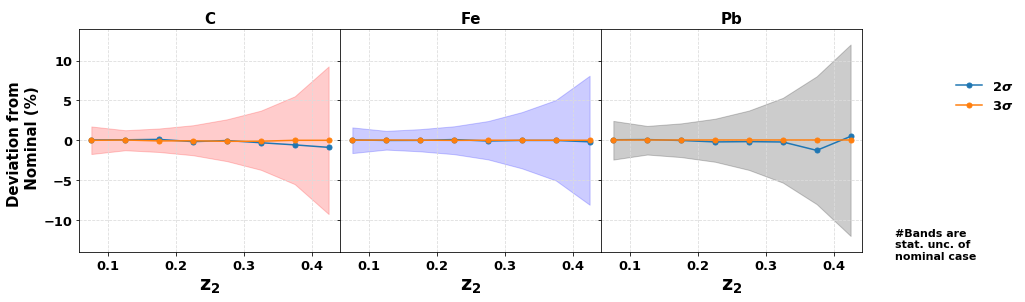

In [36]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']

# by default the cut is at 3 sigmas

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim(-0.5,0.5)

plt.show()



**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu

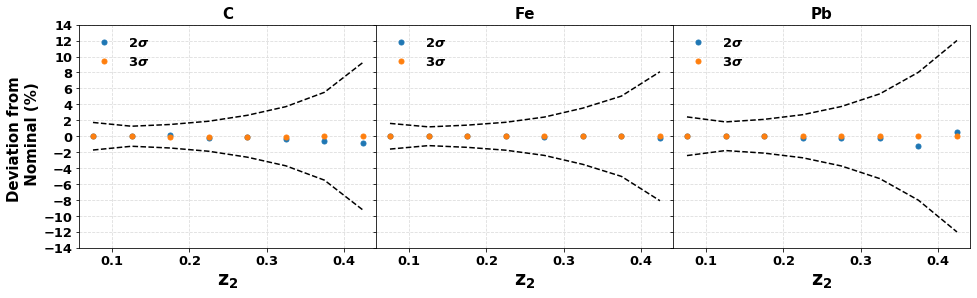

In [37]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']
sys_band=np.array([0,0,0,0,0,0,0,0])
# by default the cut is at 3 sigmas

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim(-0.5,0.5)

outname='sys_diH_SamplingFraction'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()


**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu

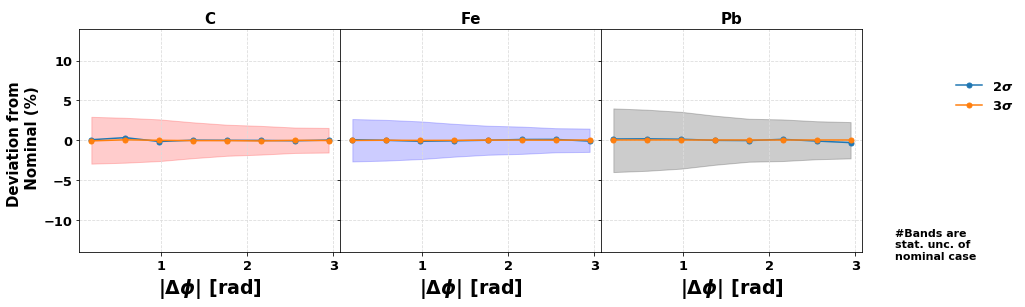

In [38]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']

# by default the cut is at 3 sigmas

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim(-0.5,0.5)

plt.show()



**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu

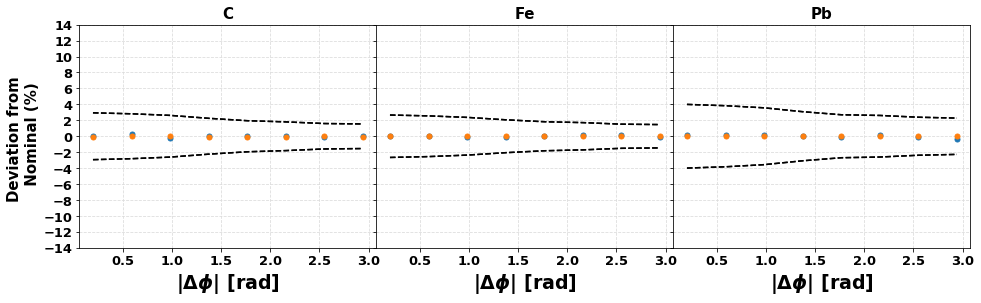

In [39]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']
sys_band=np.array([0,0,0,0,0,0,0,0])

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')      
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim(-0.5,0.5)


outname='sys_diH_SamplingFraction_dphi'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()


**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu

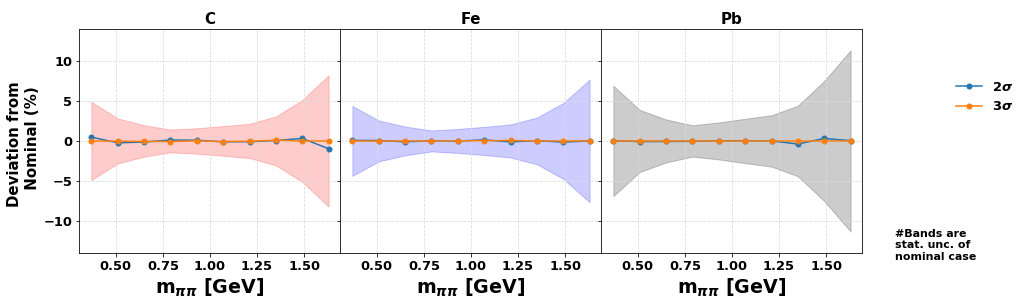

In [40]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']

# by default the cut is at 3 sigmas

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges, 
                                        variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges,  variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim(-0.5,0.5)

plt.show()


**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu

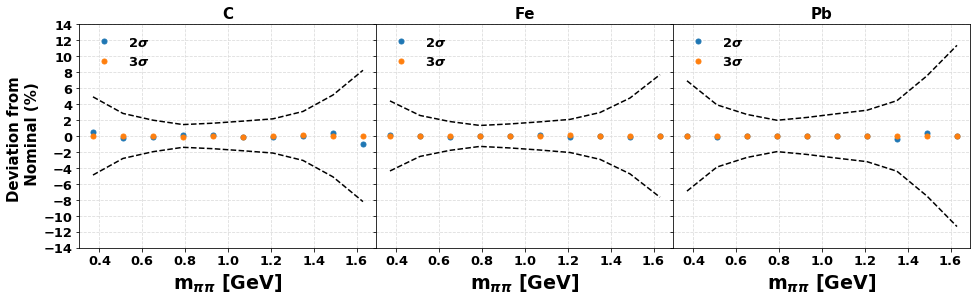

In [41]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['2$\sigma$','3$\sigma$']
sys_band=np.array([0,0,0,0,0,0,0,0,0,0])
# by default the cut is at 3 sigmas

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl20==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges, 
                                        variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges,  variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
#fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim(-0.5,0.5)

outname='sys_diH_SamplingFraction_dpionMass'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

del sys_band
plt.show()



# $z_{1}$ threshold value, for the trigger

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.1

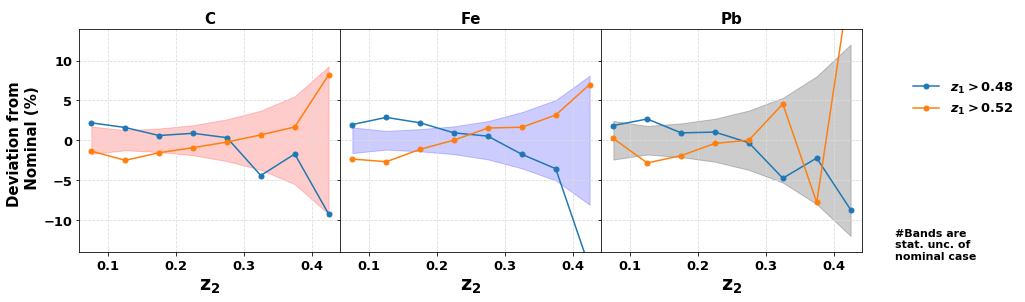

In [42]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}>0.48$','$z_{1}>0.52$']

pair_cut_var1  ='and h1_z>0.48 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.52 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.1

Print Trigger Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.1

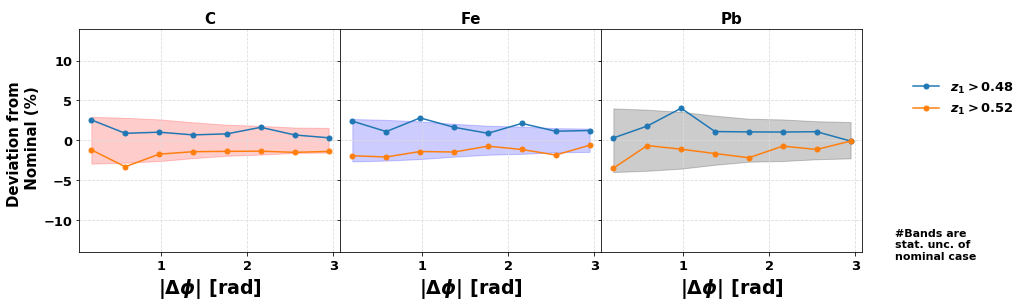

In [43]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}>0.48$','$z_{1}>0.52$']

pair_cut_var1  ='and h1_z>0.48 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.52 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.1

Print Trigger Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.1

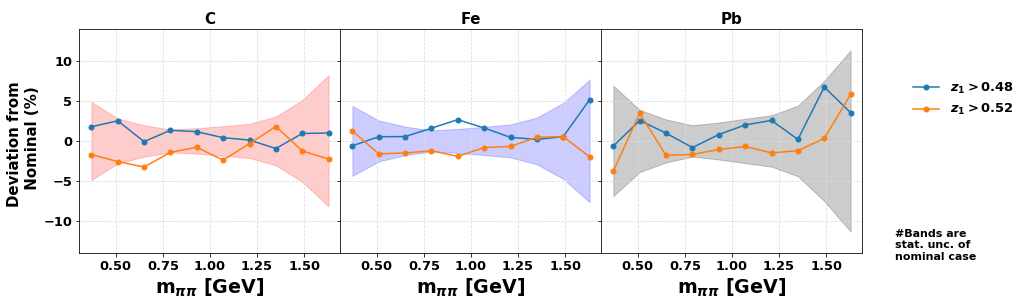

In [44]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}>0.48$','$z_{1}>0.52$']

pair_cut_var1  ='and h1_z>0.48 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.48 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_var2  ='and h1_z>0.52 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.52 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

plt.show()

# Nphe for $\pi^{+}$ selection

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

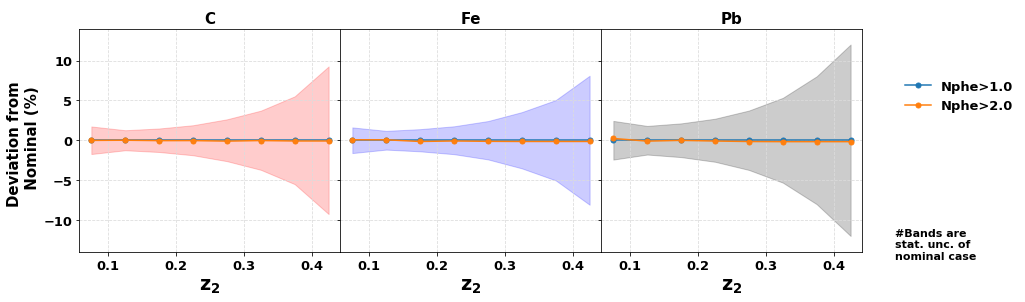

In [45]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']

Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)


Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-1.5,1.5])

plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

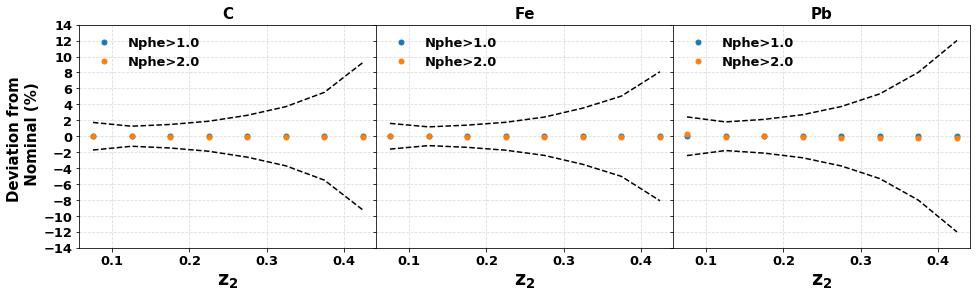

In [46]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']
sys_band=np.array([0,0,0,0,0,0,0,0])
Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)


Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)    
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim([-1.5,1.5])

outname='sys_diH_Nphethreshold_piPlus'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

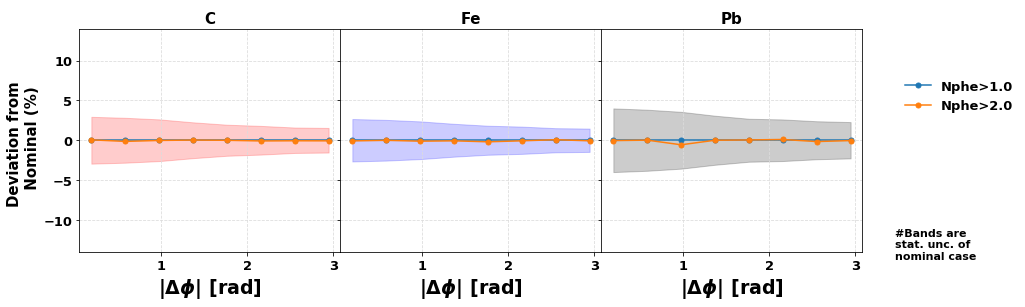

In [47]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']

Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)


Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-1.5,1.5])

#outname='sys_diH_Nphethreshold_piPlus_dphi'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

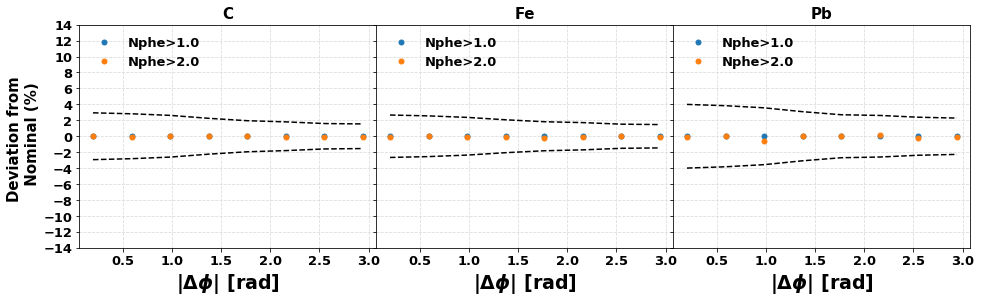

In [48]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']
sys_band=np.array([0,0,0,0,0,0,0,0])
Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)


Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi',  
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))      
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim([-1.5,1.5])

outname='sys_diH_Nphethreshold_piPlus_dphi'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

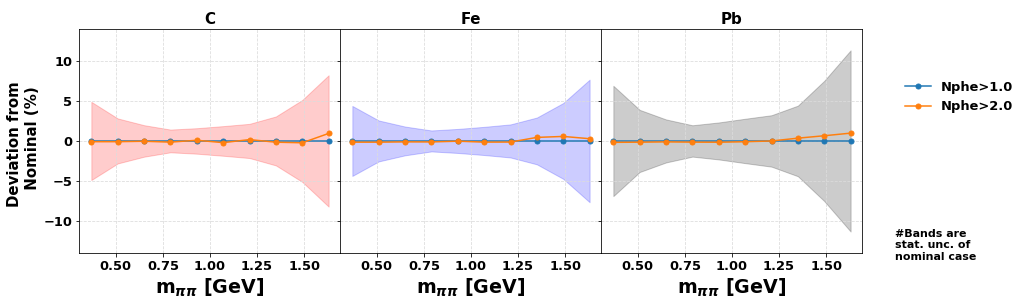

In [49]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']

Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)

Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass',  
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-1.5,1.5])

#outname='sys_diH_Nphethreshold_piPlus_dpionMass'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')



plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (10*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (20*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) a

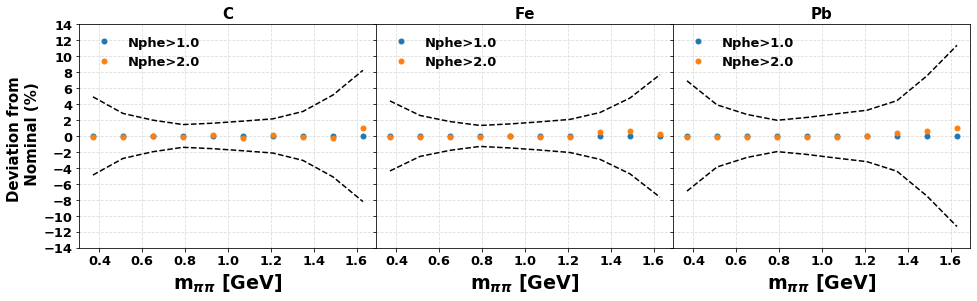

In [50]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Nphe>1.0','Nphe>2.0']
sys_band=np.array([0,0,0,0,0,0,0,0,0,0])
Nphe_thr_var1=10
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut,StatCC_h1_cut)

Nphe_thr_var2=20
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr,p_thr,p_thr,p_thr)                    

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass',  
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
    
    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim([-1.5,1.5])

outname='sys_diH_Nphethreshold_piPlus_dpionMass'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

del sys_band
plt.show()

# P theshold  for $\pi^{+}$ selection

In [51]:
%%time
path_data="/home/seba/di-hadron/P25"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df['P25%s'%target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['P25D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['P25%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['P25D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 4.95 s, sys: 306 ms, total: 5.26 s
Wall time: 5.61 s


In [52]:
%%time
path_data="/home/seba/di-hadron/P30"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df['P30%s'%target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['P30D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['P30%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['P30D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 5.37 s, sys: 371 ms, total: 5.74 s
Wall time: 6.13 s


In [53]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    df[key] = r2h.applyCuts(df[key],isMC=isMC)
    df[key] = r2h.applyCutsPair(df[key],isMC=isMC)

for key in df_trigger.keys():
    print (key)
    df_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True)
    print (' ')   


key:  C
Entries before cut  93947
Q2>1.0 and Q2<4.0 93947  (100.00  %)
0.2<h1_p<5.0  93947  (100.00  %)
inelasticity < 0.85 93947  (100.00  %)
h1_pid = pions (trigger) 93947  (100.00  %)
2.2 < nu <4.2 93947  (100.00  %)
10< h1_th<90 93947  (100.00  %)
Theta/P fiducial region selected for trigger 93947  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 93947  (100.00  %)
2.2 < nu < 4.2 93947  (100.00  %)
secondary hadrons are pions 93947  (100.00  %)
(h1_z+h2_z)<1.0 93947  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 93947  (100.00  %)
kinematic limits for h2_z 93947  (100.00  %)
kinematic limits for dphi 93947  (100.00  %)
kinematic limits for pair_mass 93947  (100.00  %)
leading hadrons are pions 93947  (100.00  %)
0.2<h2_p<5.0 93947  (100.00  %)
0.2<h1_p<5.0 93947  (100.00  %)
10<h2_th<90 93947  (100.00  %)
Theta/P fiducial region selected for secondary hadron 93947  (100.00  %)
10< h1_th<90 93947  (100.00  %)
Theta/P fiducial region selected for tr

inelasticity < 0.85 134140  (100.00  %)
h1_pid = pions (trigger) 134140  (100.00  %)
2.2 < nu <4.2 131895  (98.33  %)
10< h1_th<90 131879  (99.99  %)
Theta/P fiducial region selected for trigger 131879  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 131879  (100.00  %)
2.2 < nu < 4.2 131879  (100.00  %)
secondary hadrons are pions 131879  (100.00  %)
(h1_z+h2_z)<1.0 131326  (99.58  %)
(h1_pid*h2_pid)<0, opposite charge pions 96296  (73.33  %)
kinematic limits for h2_z 95178  (98.84  %)
kinematic limits for dphi 95113  (99.93  %)
kinematic limits for pair_mass 94781  (99.65  %)
leading hadrons are pions 94781  (100.00  %)
0.2<h2_p<5.0 94781  (100.00  %)
0.2<h1_p<5.0 94781  (100.00  %)
10<h2_th<90 94588  (99.80  %)
Theta/P fiducial region selected for secondary hadron 94588  (100.00  %)
10< h1_th<90 94588  (100.00  %)
Theta/P fiducial region selected for trigger hadron 94588  (100.00  %)

key:  P25D_Fe
Entries before cut  260900
Q2>1.0 and Q2<4.0 260900  (100

(h1_z+h2_z)<1.0 47308  (99.60  %)
(h1_pid*h2_pid)<0, opposite charge pions 35216  (74.44  %)
kinematic limits for h2_z 34840  (98.93  %)
kinematic limits for dphi 34815  (99.93  %)
kinematic limits for pair_mass 34685  (99.63  %)
leading hadrons are pions 34685  (100.00  %)
0.2<h2_p<5.0 34685  (100.00  %)
0.2<h1_p<5.0 34685  (100.00  %)
10<h2_th<90 34615  (99.80  %)
Theta/P fiducial region selected for secondary hadron 34615  (100.00  %)
10< h1_th<90 34615  (100.00  %)
Theta/P fiducial region selected for trigger hadron 34615  (100.00  %)

key:  P30D_Pb
Entries before cut  287161
Q2>1.0 and Q2<4.0 287161  (100.00  %)
0.2<h1_p<5.0  287156  (100.00  %)
inelasticity < 0.85 287156  (100.00  %)
h1_pid = pions (trigger) 287156  (100.00  %)
2.2 < nu <4.2 282406  (98.35  %)
10< h1_th<90 282403  (100.00  %)
Theta/P fiducial region selected for trigger 282403  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 282403  (100.00  %)
2.2 < nu < 4.2 282403  (100.00  %)
second

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.139

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

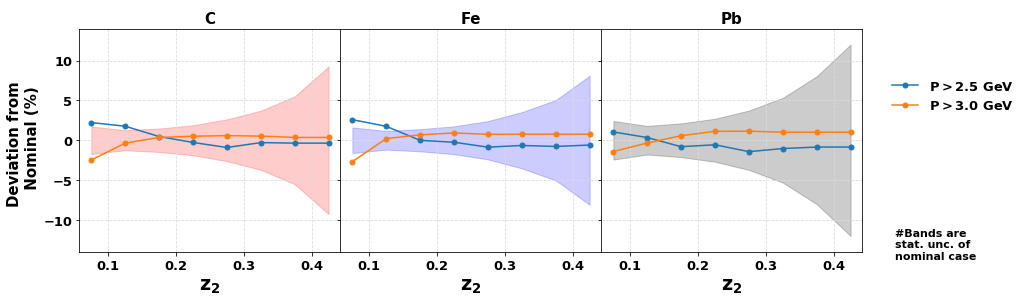

In [54]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['P$>2.5$ GeV','P$>3.0$ GeV']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom_tmp=700
Nphe_thr_nom_tmp=15
Nphe_h1_cut_tmp='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                    
Nphe_h2_cut_tmp='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                    
Chi2CC_h1_cut_tmp='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
Chi2CC_h2_cut_tmp='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h1_cut_tmp='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h2_cut_tmp='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)

pair_cut_nom_tmp  ='and h1_z>0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0   and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_tmp, Nphe_h2_cut_tmp,Chi2CC_h1_cut_tmp,Chi2CC_h2_cut_tmp,StatCC_h1_cut_tmp, StatCC_h2_cut_tmp)
trigger_cut_nom_tmp   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom_tmp,
                                    trig_cut = trigger_cut_nom_tmp)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])

#outname='sys_diH_Pthreshold_piPlus'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.139

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

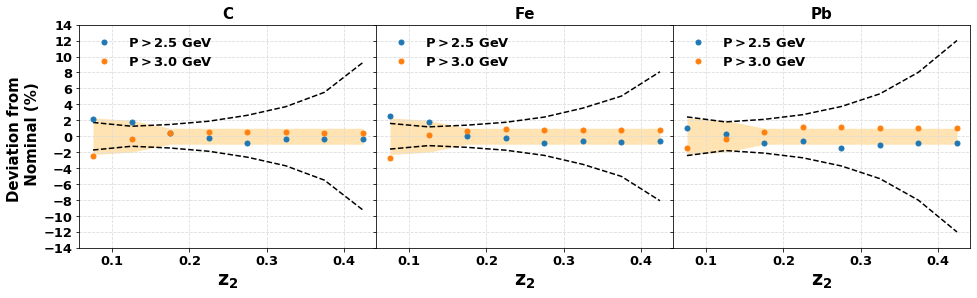

In [55]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['P$>2.5$ GeV','P$>3.0$ GeV']
sys_band=np.array([2.3,2,1,1,1,1,1,1])

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom_tmp=700
Nphe_thr_nom_tmp=15
Nphe_h1_cut_tmp='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                    
Nphe_h2_cut_tmp='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                    
Chi2CC_h1_cut_tmp='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
Chi2CC_h2_cut_tmp='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h1_cut_tmp='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h2_cut_tmp='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)

pair_cut_nom_tmp  ='and h1_z>0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0   and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_tmp, Nphe_h2_cut_tmp,Chi2CC_h1_cut_tmp,Chi2CC_h2_cut_tmp,StatCC_h1_cut_tmp, StatCC_h2_cut_tmp)
trigger_cut_nom_tmp   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom_tmp,
                                    trig_cut = trigger_cut_nom_tmp)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim([-0.5,0.5])

outname='sys_diH_Pthreshold_piPlus'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()



**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

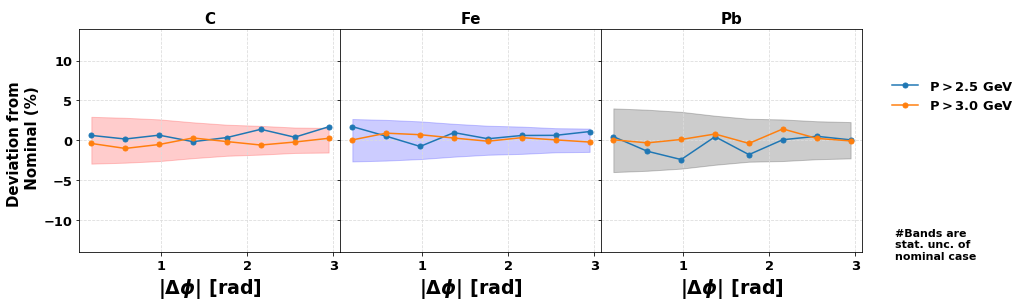

In [56]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['P$>2.5$ GeV','P$>3.0$ GeV']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom_tmp=700
Nphe_thr_nom_tmp=15
Nphe_h1_cut_tmp='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                    
Nphe_h2_cut_tmp='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                 
Chi2CC_h1_cut_tmp='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
Chi2CC_h2_cut_tmp='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h1_cut_tmp='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h2_cut_tmp='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)

pair_cut_nom_tmp  ='and h1_z>0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0   and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_tmp, Nphe_h2_cut_tmp,Chi2CC_h1_cut_tmp,Chi2CC_h2_cut_tmp,StatCC_h1_cut_tmp, StatCC_h2_cut_tmp)
trigger_cut_nom_tmp   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi',
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])


#outname='sys_diH_Pthreshold_piPlus_dphi'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')



plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

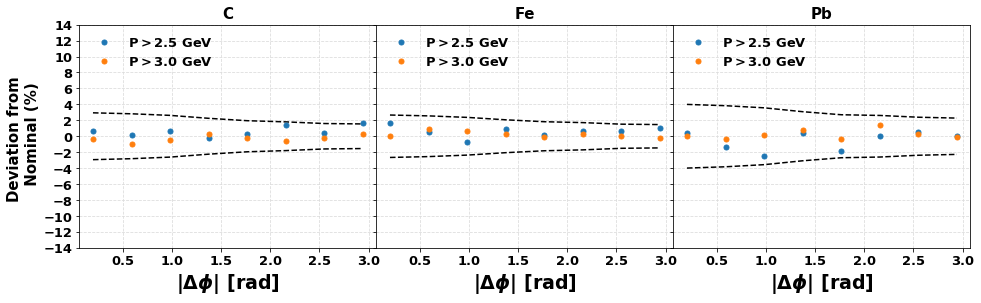

In [57]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['P$>2.5$ GeV','P$>3.0$ GeV']
sys_band=np.array([0,0,0,0,0,0,0,0])
## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom_tmp=700
Nphe_thr_nom_tmp=15
Nphe_h1_cut_tmp='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                    
Nphe_h2_cut_tmp='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                 
Chi2CC_h1_cut_tmp='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
Chi2CC_h2_cut_tmp='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h1_cut_tmp='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h2_cut_tmp='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)

pair_cut_nom_tmp  ='and h1_z>0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0   and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_tmp, Nphe_h2_cut_tmp,Chi2CC_h1_cut_tmp,Chi2CC_h2_cut_tmp,StatCC_h1_cut_tmp, StatCC_h2_cut_tmp)
trigger_cut_nom_tmp   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi',
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))      
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim([-0.5,0.5])


outname='sys_diH_Pthreshold_piPlus_dphi'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

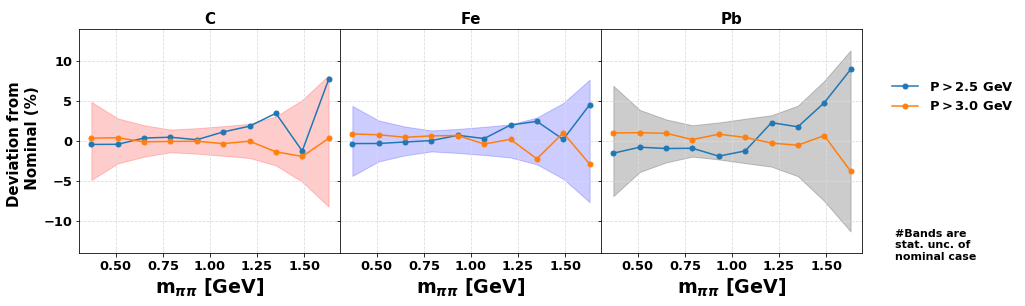

In [58]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['P$>2.5$ GeV','P$>3.0$ GeV']

## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom_tmp=700
Nphe_thr_nom_tmp=15
Nphe_h1_cut_tmp='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                    
Nphe_h2_cut_tmp='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                 
Chi2CC_h1_cut_tmp='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
Chi2CC_h2_cut_tmp='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h1_cut_tmp='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h2_cut_tmp='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)

pair_cut_nom_tmp  ='and h1_z>0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0   and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_tmp, Nphe_h2_cut_tmp,Chi2CC_h1_cut_tmp,Chi2CC_h2_cut_tmp,StatCC_h1_cut_tmp, StatCC_h2_cut_tmp)
trigger_cut_nom_tmp   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])

#outname='sys_diH_Pthreshold_piPlus_dpionMass'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(700.000000*700.000000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

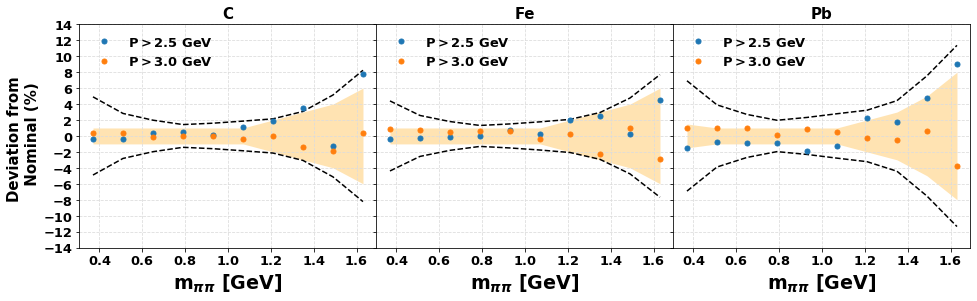

In [59]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['P$>2.5$ GeV','P$>3.0$ GeV']
sys_band=np.array([1,1,1,1,1,1,2,3,4,6])
sys_band_Pb=np.array([1.5,1,1,1,1,1,2,3,5,8])
## I put a crazy high value for P, basically it means 'do not apply the cuts'. 
#That is because they are already in the source files
p_thr_nom_tmp=700
Nphe_thr_nom_tmp=15
Nphe_h1_cut_tmp='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                    
Nphe_h2_cut_tmp='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)                 
Chi2CC_h1_cut_tmp='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
Chi2CC_h2_cut_tmp='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h1_cut_tmp='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)
StatCC_h2_cut_tmp='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_nom_tmp,p_thr_nom_tmp)

pair_cut_nom_tmp  ='and h1_z>0.5 and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0   and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(Nphe_h1_cut_tmp, Nphe_h2_cut_tmp,Chi2CC_h1_cut_tmp,Chi2CC_h2_cut_tmp,StatCC_h1_cut_tmp, StatCC_h2_cut_tmp)
trigger_cut_nom_tmp   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

p_thr_var1=700
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

p_thr_var2=700
Nphe_thr_var2=15
Nphe_h1_cut_var2='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Nphe_h2_cut_var2='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)                    
Chi2CC_h1_cut_var2='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
Chi2CC_h2_cut_var2='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var2,p_thr_var2,p_thr_var2,p_thr_var2)
StatCC_h1_cut_var2='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)
StatCC_h2_cut_var2='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var2,p_thr_var2)

pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var2, Nphe_h2_cut_var2,Chi2CC_h1_cut_var2,Chi2CC_h2_cut_var2,StatCC_h1_cut_var2, StatCC_h2_cut_var2)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var2, Chi2CC_h1_cut_var2,StatCC_h1_cut_var2)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['P25%s'%target], df['P25D_%s'%target], 
                        df_trigger['P25%s_trigger'%target], df_trigger['P25D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['P30%s'%target], df['P30D_%s'%target], 
                        df_trigger['P30%s_trigger'%target], df_trigger['P30D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut = trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    if target!= 'Pb':    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    else:    axs[i].fill_between(x_nom,sys_band_Pb ,-sys_band_Pb ,color='orange',alpha=0.3, lw=0) 
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim([-0.5,0.5])


outname='sys_diH_Pthreshold_piPlus_dpionMass'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

del sys_band
plt.show()

# CC Matching Mirror v/s Nphe for $\pi^{-}$ rejection from electron sample

In [60]:
%%time
path_data="/home/seba/di-hadron/CC_Matching"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df['CC%s'%target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['CCD_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['CC%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['CCD_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)


Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 22.3 s, sys: 1.45 s, total: 23.8 s
Wall time: 24.7 s


In [61]:
print(df_trigger.keys())

dict_keys(['C_trigger', 'D_C_trigger', 'Fe_trigger', 'D_Fe_trigger', 'Pb_trigger', 'D_Pb_trigger', 'P25C_trigger', 'P25D_C_trigger', 'P25Fe_trigger', 'P25D_Fe_trigger', 'P25Pb_trigger', 'P25D_Pb_trigger', 'P30C_trigger', 'P30D_C_trigger', 'P30Fe_trigger', 'P30D_Fe_trigger', 'P30Pb_trigger', 'P30D_Pb_trigger', 'CCC_trigger', 'CCD_C_trigger', 'CCFe_trigger', 'CCD_Fe_trigger', 'CCPb_trigger', 'CCD_Pb_trigger'])


In [62]:
%%time
for key in df.keys():
    isMC = False
    if 'CC' in key:
        print ('\nkey: ',key)
        df[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
        df[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
        df[key] = r2h.applyCuts(df[key],isMC=isMC)
        df[key] = r2h.applyCutsPair(df[key],isMC=isMC)

for key in df_trigger.keys():
    if 'CC' in key:
        print (key)
        df_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
        df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True)
        print (' ')   


key:  CCC
Entries before cut  1393282
Q2>1.0 and Q2<4.0 1393282  (100.00  %)
0.2<h1_p<5.0  1393255  (100.00  %)
inelasticity < 0.85 1393255  (100.00  %)
h1_pid = pions (trigger) 272615  (19.57  %)
2.2 < nu <4.2 267924  (98.28  %)
10< h1_th<90 267917  (100.00  %)
Theta/P fiducial region selected for trigger 267917  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 267917  (100.00  %)
2.2 < nu < 4.2 267917  (100.00  %)
secondary hadrons are pions 135839  (50.70  %)
(h1_z+h2_z)<1.0 135265  (99.58  %)
(h1_pid*h2_pid)<0, opposite charge pions 100884  (74.58  %)
kinematic limits for h2_z 99710  (98.84  %)
kinematic limits for dphi 99610  (99.90  %)
kinematic limits for pair_mass 99210  (99.60  %)
leading hadrons are pions 99210  (100.00  %)
0.2<h2_p<5.0 99210  (100.00  %)
0.2<h1_p<5.0 99210  (100.00  %)
10<h2_th<90 99045  (99.83  %)
Theta/P fiducial region selected for secondary hadron 99045  (100.00  %)
10< h1_th<90 99045  (100.00  %)
Theta/P fiducial region selec

10< h1_th<90 1449544  (100.00  %)
Theta/P fiducial region selected for trigger 1449544  (100.00  %)
 
CPU times: user 11 s, sys: 915 ms, total: 11.9 s
Wall time: 11 s


Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

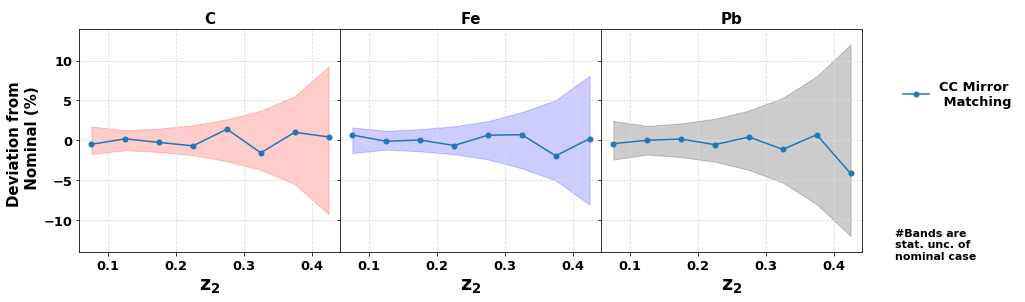

In [63]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror \n Matching']

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])

#outname='sys_diH_CCMatching'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

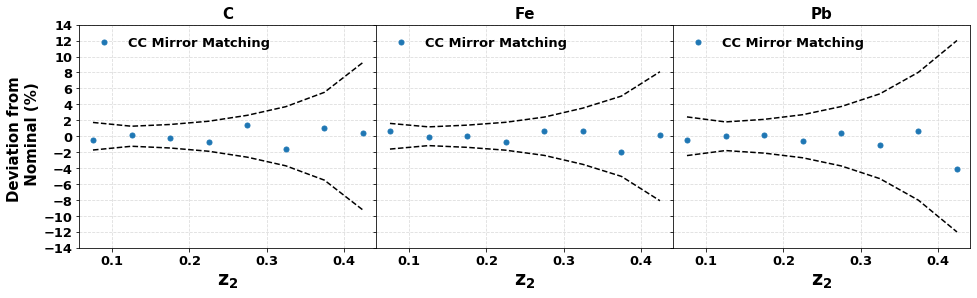

In [64]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror Matching']
sys_band=np.array([0,0,0,0,0,0,0,0])
p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))       
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim([-0.5,0.5])

outname='sys_diH_CCMatching'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()

**With respect to $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

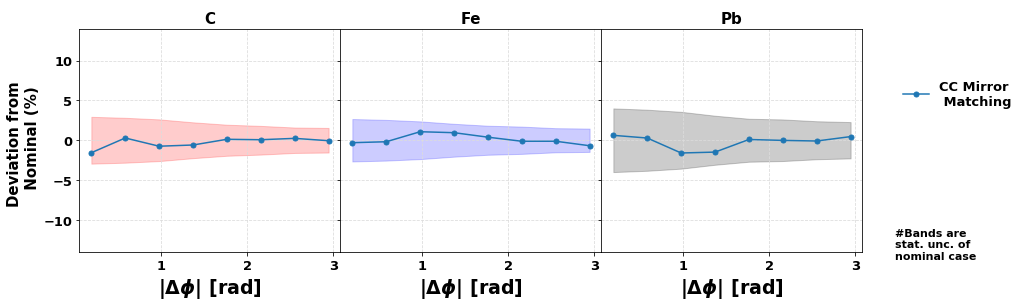

In [65]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror \n Matching']

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi',
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])


#outname='sys_diH_CCMatching_dphi'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

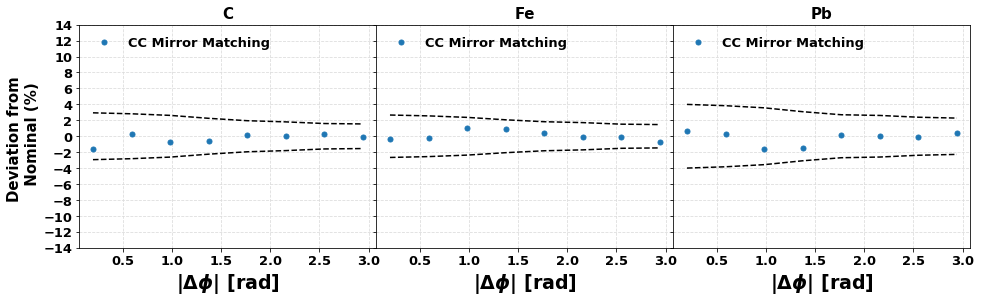

In [66]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror Matching']
sys_band=np.array([0,0,0,0,0,0,0,0])
p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi',
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges,  variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim([-0.5,0.5])


outname='sys_diH_CCMatching_dphi'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

del sys_band
plt.show()

**With respect to the Dipion mass (GeV)**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

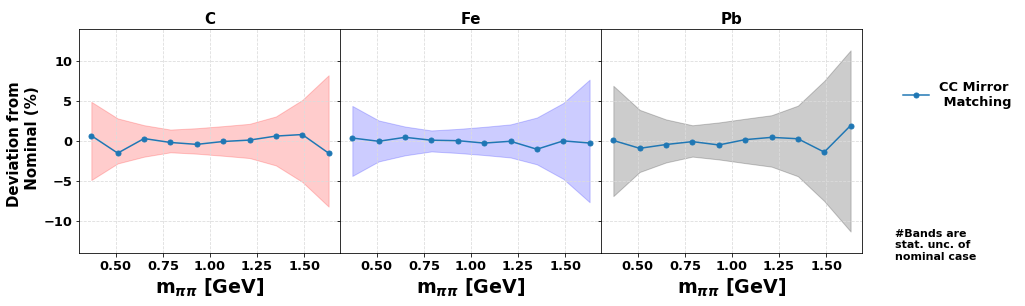

In [67]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror \n Matching']

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])

#outname='sys_diH_CCMatching_dpionMass'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()

**Alternative format**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

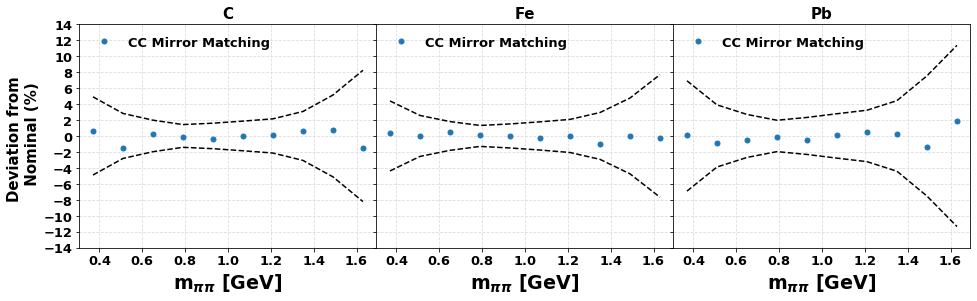

In [68]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['CC Mirror Matching']
sys_band=np.array([0,0,0,0,0,0,0,0,0,0])

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['CC%s'%target], df['CCD_%s'%target], 
                        df_trigger['CC%s_trigger'%target], df_trigger['CCD_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))      
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#axs[0].set_ylim([-0.5,0.5])

outname='sys_diH_CCMatching_dpionMass'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()

**Checking the sensitivity to pairs with z1+z2>0.8, exclusive rho events are dominant for z1+z2>0.8.** 

**Here we try a comparison of z1+z2<0.8 and the nominal case**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

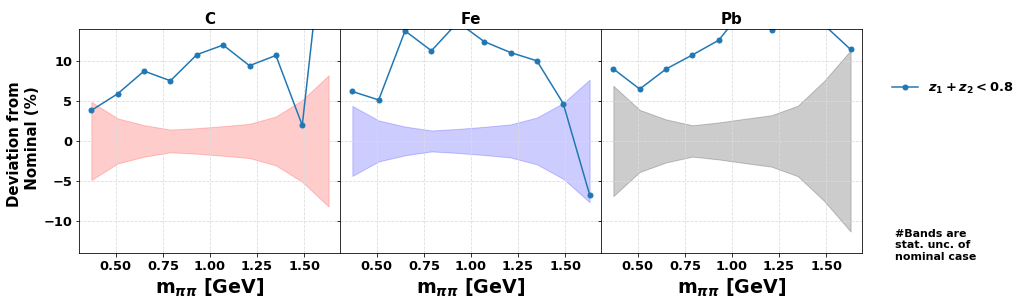

In [69]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}+z_{2}<0.8$']

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<0.8 and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass',  
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])

#plt.savefig('diH_CCMatching_dpionMass.pdf', bbox_inches='tight')

plt.show()

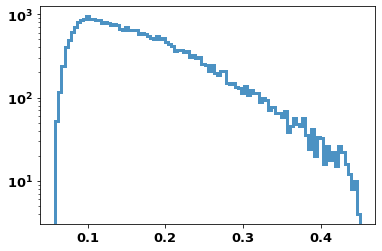

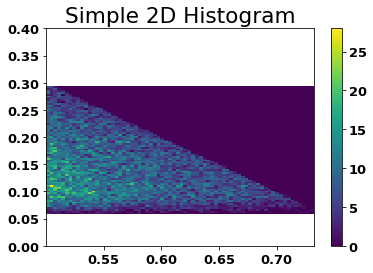

In [70]:
##%%script false --no-raise-error
df['C'].eval('z_total=h1_z+h2_z', inplace=True)
cut=' and h1_z+h2_z<0.8'
plt.hist(df['C'].query(trigger_cut_nom+pair_cut_nom)['h2_z'],alpha=0.8,lw=3,bins=100, histtype='step', label='D', density=False)
plt.yscale('log')
plt.show()
#print(df['C'].columns)

plt.hist2d(df['C'].query(trigger_cut_nom+pair_cut_nom+cut).h1_z, 
           df['C'].query(trigger_cut_nom+pair_cut_nom+cut).h2_z, bins=[70,70]) 
plt.title("Simple 2D Histogram")  
plt.colorbar()
plt.ylim([0.,0.4])
plt.show()

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

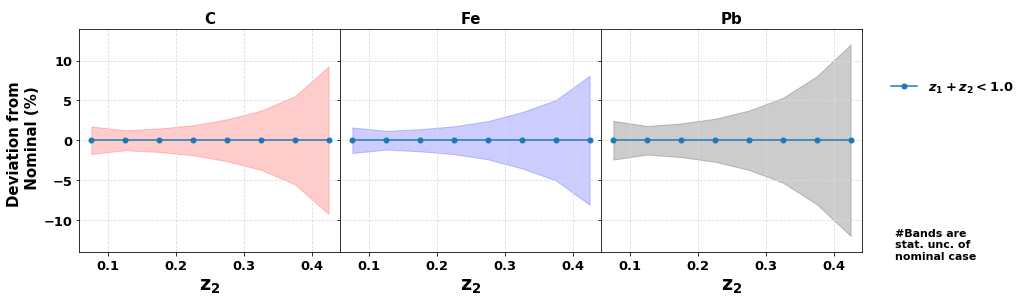

In [71]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$z_{1}+z_{2}<1.0$']


p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)


for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
#plt.savefig('R2h_comp_1.png', bbox_inches='tight')

plt.show()

**Using 'evnt' variable, this is like a time changing variation**

**Basic idea: we divide our sample in 3 chunks, based on evnt variable and compared the consistency between the three**

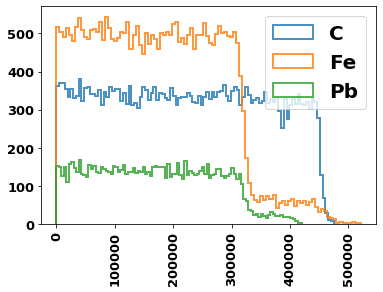

C :  1.0 -> 158313.0
C :  158314.0 -> 316626.0
C :  316627.0 -> 474939.0
Fe :  6.0 -> 173772.33333333334
Fe :  173778.33333333334 -> 347544.6666666667
Fe :  347550.6666666667 -> 521317.0
Pb :  8.0 -> 140486.33333333334
Pb :  140494.33333333334 -> 280972.6666666667
Pb :  280980.6666666667 -> 421459.0
Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and Samp

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>8 and evnt < 140486
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.1

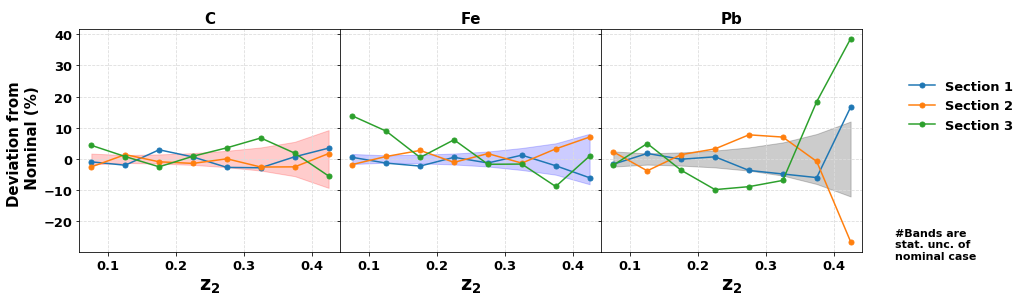

In [72]:
##%%script false --no-raise-error
maxValue={}
minValue={}
numberIntervals=3
for i,target in enumerate(['C','Fe','Pb']):
    y, x, _ = plt.hist(df[target].query(trigger_cut_nom+pair_cut_nom)['evnt'],alpha=0.8,lw=2,
                       bins=100,histtype='step',  label=target, density=False)
    maxValue[target]=x.max()/numberIntervals
    minValue[target]=x.min()
#plt.xlim(400000,550000)  
#plt.xscale('log')
plt.xticks(rotation='vertical')
plt.legend()    
plt.show()

for j,target in enumerate(['C','Fe','Pb']):
    for i,tmp in enumerate(['C','Fe','Pb']):
        print (target,': ', minValue[target]+i*maxValue[target] ,'->', maxValue[target]+i*maxValue[target])
#print(maxValue)




fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Section 1', 'Section 2','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut ='%s'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    j=0
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]    ) )
    j=1
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]    ) )
    j=2
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target]+j*maxValue[target],maxValue[target]+j*maxValue[target]    ) )

    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
                
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])
#plt.savefig('R2h_comp_1.png', bbox_inches='tight')

plt.show()

In [73]:
##%%script false --no-raise-error
maxValue={}
minValue={}
numberIntervals=3
#for i,target in enumerate(['C','Fe','Pb']):
#    y, x, _ = plt.hist(df[target].query(trigger_cut_nom+pair_cut_nom)['evnt'],alpha=0.8,lw=2,
#                       bins=100,histtype='step',  label=target, density=False)
#    maxValue[target]=x.max()/numberIntervals
#    minValue[target]=x.min()
    
#plt.xlim(400000,550000)    
#plt.legend()    
#plt.show()

maxValue['C']=[150000,300000,600000]
minValue['C']=[0 , 150000,300000]
maxValue['Fe']=[110000,220000,600000]
minValue['Fe']=[0 , 110000,220000]
maxValue['Pb']=[110000,220000,600000]
minValue['Pb']=[0 , 110000,220000]

for l,target in enumerate(['C','Fe','Pb']):
    for i,tmp in enumerate(['C','Fe','Pb']):
        cut_ad=' and evnt>%d and evnt< %d'%(minValue[target][i] , maxValue[target][i])
        print('target: ',target, df[target].query(trigger_cut_nom+pair_cut_nom+cut_ad).shape[0] / df[target].query(trigger_cut_nom+pair_cut_nom).shape[0])
        


target:  C 0.33918110334889257
target:  C 0.33247705272391215
target:  C 0.3283418439271953
target:  Fe 0.32951342645646853
target:  Fe 0.3223898163347477
target:  Fe 0.34809675720878375
target:  Pb 0.33501942010658475
target:  Pb 0.3280643121669226
target:  Pb 0.33691626772649264


**Now, considering only the density between ranges is the same, same % of events in each section**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

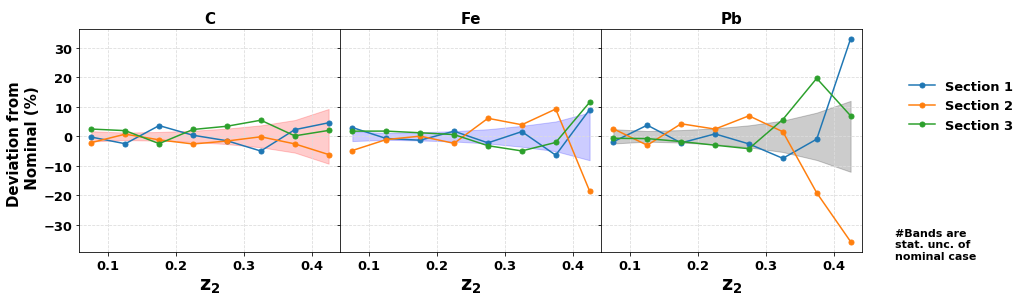

In [74]:
##%%script false --no-raise-error
maxValue={}
minValue={}
maxValue['C']=[150000,300000,600000]
minValue['C']=[0 , 150000,300000]
maxValue['Fe']=[110000,220000,600000]
minValue['Fe']=[0 , 110000,220000]
maxValue['Pb']=[110000,220000,600000]
minValue['Pb']=[0 , 110000,220000]


fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['Section 1', 'Section 2','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut ='%s'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)

    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]    ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )
    
    r_var3, err_var3,x_var3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom, minValue[target][2] , maxValue[target][2]  ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom, minValue[target][2] , maxValue[target][2]    ) )

    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    y_dev_nom_var3 =  ((r_var3 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var3,fmt='-o',ms=5,label=tmp_label[2]if i == 0 else "")  
                
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])
#plt.savefig('R2h_comp_1.png', bbox_inches='tight')

plt.show()

**trying only two section, i.e divide the sample in two chunks**

In [75]:
##%%script false --no-raise-error
## this piece of code is just to select the ranges

maxValue={}
minValue={}
numberIntervals=3


maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]

for l,target in enumerate(['C','Fe','Pb']):
    for i,tmp in enumerate(['tmp','tmp']):
        cut_ad=' and evnt>%d and evnt< %d'%(minValue[target][i] , maxValue[target][i])
        print('target: ',target, df[target].query(trigger_cut_nom+pair_cut_nom+cut_ad).shape[0] / df[target].query(trigger_cut_nom+pair_cut_nom).shape[0])
        
        
   
        

target:  C 0.49475267065568124
target:  C 0.5052473293443188
target:  Fe 0.5049710409762443
target:  Fe 0.4950289590237557
target:  Pb 0.4979676632643844
target:  Pb 0.5020323367356155


Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>0 and evnt < 170000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.1

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>165000 and evnt < 600000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.1395

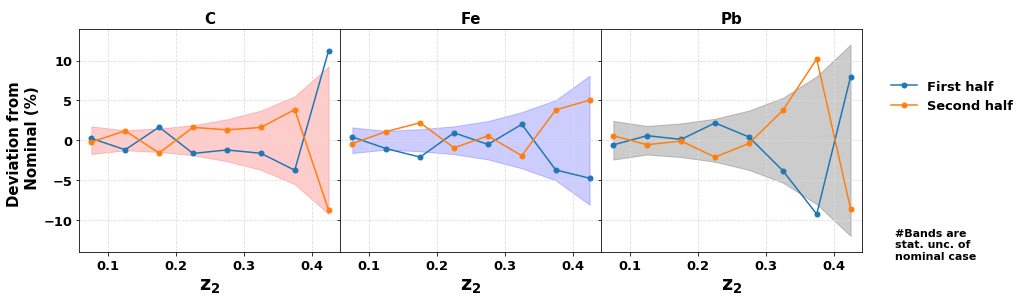

In [76]:
##%%script false --no-raise-error
maxValue={}
minValue={}

maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]


fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First half', 'Second half','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]


p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  =' and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut ='%s'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)

    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]    ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  

    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])
#plt.savefig('sys_R2h_compEvnt.pdf', bbox_inches='tight')
#plt.savefig('sys_R2h_compEvnt.png', bbox_inches='tight')

plt.show()

**Ploting the ratios r2h themselves, not the deviation from nominal**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>0 and evnt < 170000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.1

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>165000 and evnt < 600000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.1395

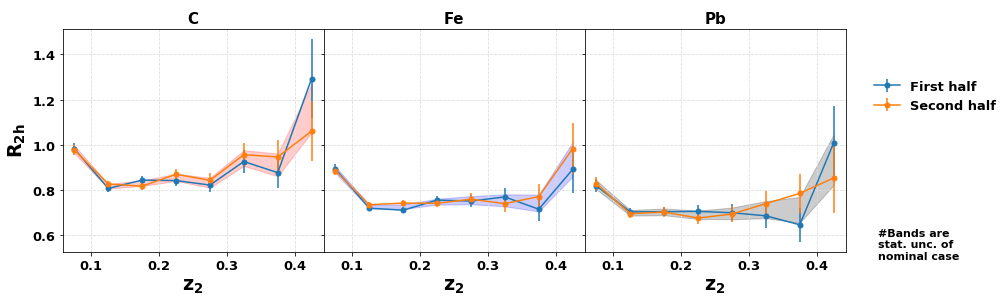

In [77]:
##%%script false --no-raise-error
maxValue={}
minValue={}

maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]


fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First half', 'Second half','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  =' and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut ='%s'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    
    #axs[i].fill_between(x_nom, r_nom ,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    #axs[i].errorbar(x_nom,err_nom,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "") 
    #axs[i].errorbar(x_nom+0.005*i,r_nom,yerr=err_nom,label='Nominal'if i == 0 else "",ms=8,fmt='o',alpha=0.8)
    axs[i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2)
    
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]    ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )

    #y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,r_var1,yerr=err_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    #y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    #axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].errorbar(x_nom,r_var2,yerr=err_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  

    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])

#outname='sys_R2h_compEvnt_R2h'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')



plt.show()

**As a function of $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>0 and evnt < 170000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.1

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>165000 and evnt < 600000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.1395

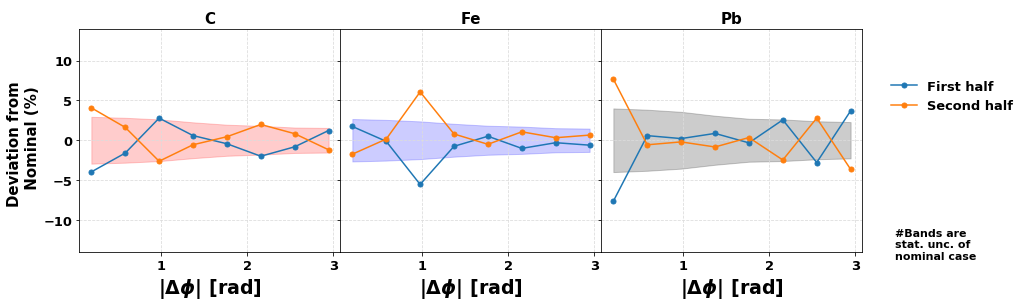

In [78]:
##%%script false --no-raise-error
maxValue={}
minValue={}

maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]

varDep='dphi'
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First half', 'Second half','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]


p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable=varDep, 
                                    pair_cut ='%s and Q2>1.0'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)

    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable=varDep, 
                                       pair_cut = '%s and Q2>1.0 and  evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable=varDep, 
                                       pair_cut = '%s and Q2>1.0 and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]    ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  

    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])
#plt.savefig('sys_R2h_compEvnt_diphi.pdf', bbox_inches='tight')
#plt.savefig('sys_R2h_compEvnt_diphi.png', bbox_inches='tight')

plt.show()

**Ploting the ratios r2h themselves, not the deviation from nominal**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>0 and evnt < 170000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.1

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>165000 and evnt < 600000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.1395

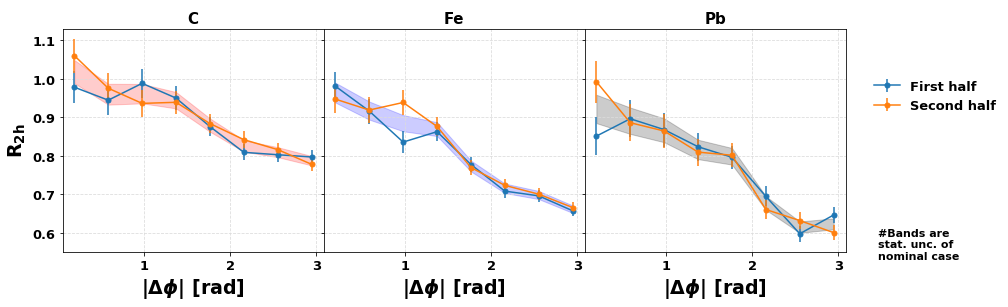

In [79]:
##%%script false --no-raise-error
maxValue={}
minValue={}

maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]

varDep='dphi'
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First half', 'Second half','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]


p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable=varDep, 
                                    pair_cut ='%s and Q2>1.0'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].fill_between(x_nom, r_nom - err_nom , r_nom + err_nom ,color=colorBands[i],alpha=0.2)
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable=varDep, 
                                       pair_cut = '%s and Q2>1.0 and  evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable=varDep, 
                                       pair_cut = '%s and Q2>1.0 and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]    ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )

    #y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,r_var1, yerr=err_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    #y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,r_var2,yerr=err_var2, fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  

    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])

#outname='sys_R2h_compEvnt_diphi_R2h'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

del varDep

plt.show()

**As a function of pair Inv mass**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>0 and evnt < 170000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.1

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>165000 and evnt < 600000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.1395

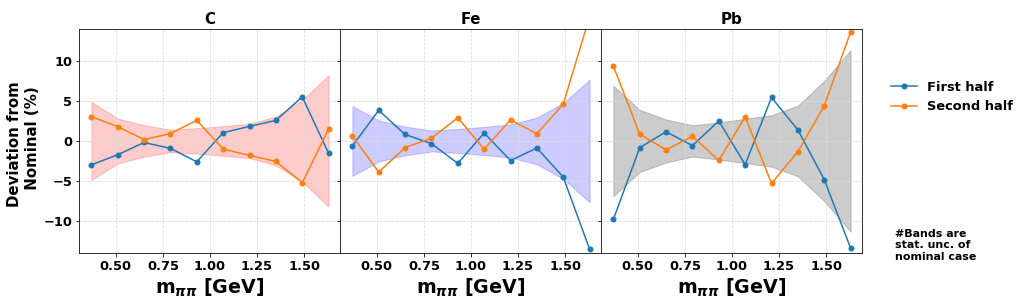

In [80]:
##%%script false --no-raise-error
maxValue={}
minValue={}
maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]

varDep='pair_mass'
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First half', 'Second half','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]


p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable=varDep, 
                                    pair_cut ='%s'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)

    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable=varDep, 
                                       pair_cut = '%s and  evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable=varDep, 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]    ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  

    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])
#plt.savefig('sys_R2h_compEvnt_dipionMass.pdf', bbox_inches='tight')
#plt.savefig('sys_R2h_compEvnt_dipionMass.png', bbox_inches='tight')
del varDep
plt.show()

**Ploting the ratios r2h themselves, not the deviation from nominal**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>0 and evnt < 170000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.1

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>165000 and evnt < 600000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.1395

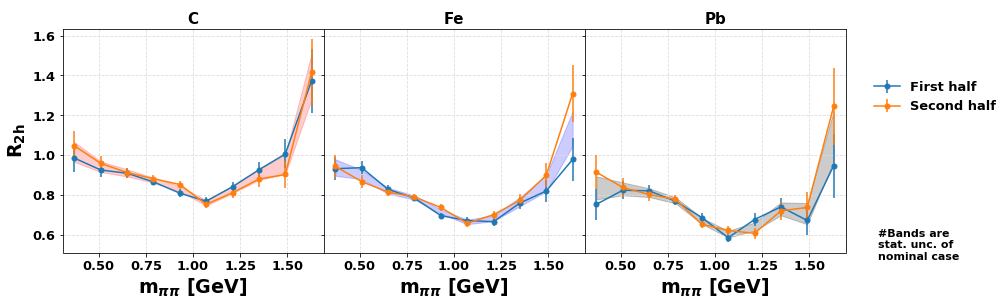

In [81]:
##%%script false --no-raise-error
maxValue={}
minValue={}
maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]

varDep='pair_mass'
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First half', 'Second half','Section 3']
entries={}
entries['C']=df['C'].shape[0]
entries['Fe']=df['Fe'].shape[0]
entries['Pb']=df['Pb'].shape[0]
entries['C_trigger']=df_trigger['C_trigger'].shape[0]
entries['Fe_trigger']=df_trigger['Fe_trigger'].shape[0]
entries['Pb_trigger']=df_trigger['Pb_trigger'].shape[0]

p_thr_var1=2.7
Nphe_thr_var1=15
Nphe_h1_cut_var1='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Nphe_h2_cut_var1='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)                    
Chi2CC_h1_cut_var1='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)
Chi2CC_h2_cut_var1='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr_var1,p_thr_var1,p_thr_var1,p_thr_var1)

StatCC_h1_cut_var1='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)
StatCC_h2_cut_var1='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr_var1,p_thr_var1)

pair_cut_var1  ='and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut_var1, Nphe_h2_cut_var1,Chi2CC_h1_cut_var1,Chi2CC_h2_cut_var1,StatCC_h1_cut_var1, StatCC_h2_cut_var1)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut_var1, Chi2CC_h1_cut_var1,StatCC_h1_cut_var1)

for i,target in enumerate(['C','Fe','Pb']):
    
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable=varDep, 
                                    pair_cut ='%s'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom)
    axs[i].fill_between(x_nom, r_nom-err_nom,r_nom + err_nom,color=colorBands[i],alpha=0.2)

    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable=varDep, 
                                       pair_cut = '%s and  evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable=varDep, 
                                       pair_cut = '%s and evnt>%d and evnt < %d'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]    ),
                                       trig_cut = '%s and evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )

    #y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,r_var1,yerr=err_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    #y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,r_var2,yerr=err_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  

    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

#axs[0].set_ylim([-0.5,0.5])

#outname='sys_R2h_compEvnt_dipionMass_R2h'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


del varDep
plt.show()

**since we observe outlyers in the distributions, the idea here is to prove that , since we are using half the statistics in each case, those large uncertainties are related to the statistical uncertainty of the variation. I have to check that due to the fact that in the usual sys unc plots the stst uncertainty of the variation is not plotted**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) an

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>0 and evnt < 170000 
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and evnt>165000 and evnt < 600000 
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.139

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and  evnt>0 and evnt < 220000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and  evnt>170000 and evnt < 600000
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.139

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) an

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and  evnt>220000 and evnt < 600000 
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13

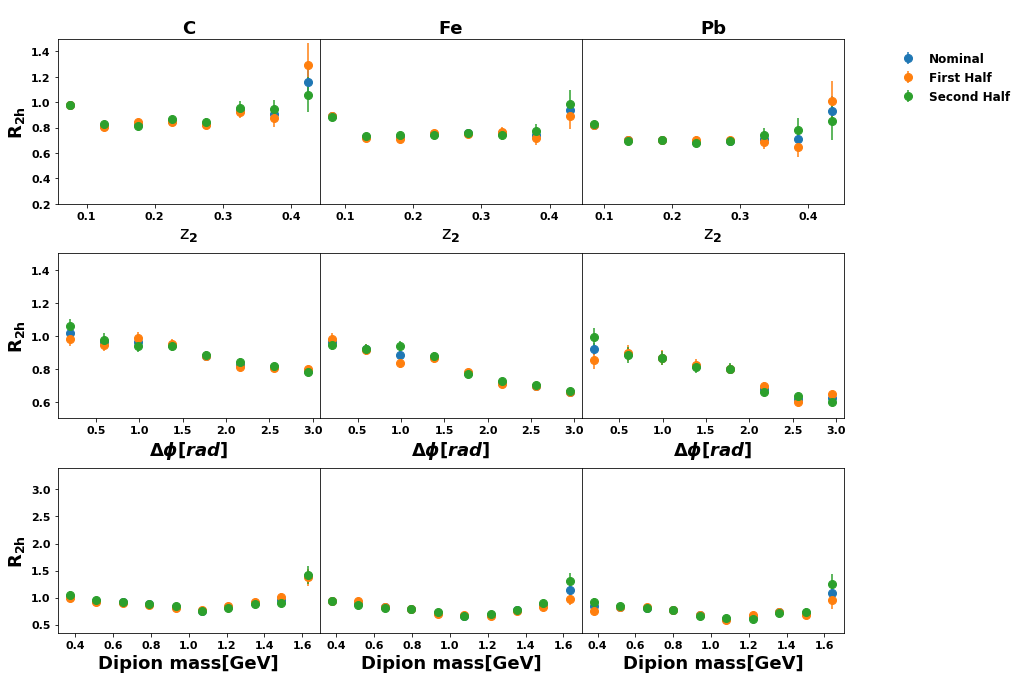

In [82]:
##%%script false --no-raise-error
fig, axs = plt.subplots(3, 3,sharex=False, sharey=False,figsize=(14,10),gridspec_kw={'hspace': 0.3, 'wspace':0.})
maxValue={}
minValue={}
numberIntervals=3

maxValue['C']=[220000,600000]
minValue['C']=[0 , 220000]
maxValue['Fe']=[170000,600000]
minValue['Fe']=[0 , 170000]
maxValue['Pb']=[165000,600000]
minValue['Pb']=[0 , 165000]


for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                               pair_cut ='%s '%pair_cut_nom,
                               trig_cut ='%s '%trigger_cut_nom )
    axs[0][i].errorbar(x2+0.005*i,r2,yerr=err2,label='Nominal'if i == 0 else "",fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                               pair_cut = '%s and  evnt>%d and evnt < %d '%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                               trig_cut ='%s and evnt>%d and evnt < %d '%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    axs[0][i].errorbar(x3+0.005*i,r3,yerr=err3,label='First Half'if i == 0 else "",fmt='o',ms=8) 

for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                               pair_cut = '%s and  evnt>%d and evnt < %d '%(pair_cut_nom,minValue[target][1] , maxValue[target][1]   ),
                               trig_cut ='%s and evnt>%d and evnt < %d '%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )
    axs[0][i].errorbar(x3+0.005*i,r3,yerr=err3,label='Second Half'if i == 0 else "",fmt='o',ms=8) 
    

### Dphi
 


for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                               pair_cut ='%s  and Q2>1.0  and h2_z<0.5'%pair_cut_nom,
                               trig_cut ='%s '%trigger_cut_nom  )
    axs[1][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                               pair_cut = '%s and  evnt>%d and evnt < %d and Q2>1.0  and h2_z<0.5'%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                               trig_cut ='%s and  evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    axs[1][i].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 

for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                               pair_cut = '%s and  evnt>%d and evnt < %d and Q2>1.0  and h2_z<0.5'%(pair_cut_nom,minValue[target][1] , maxValue[target][1]   ),
                               trig_cut ='%s and  evnt>%d and evnt < %d'%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )
    axs[1][i].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    
    
    
### Inv Mass


for i,target in enumerate(['C','Fe','Pb']):    
    r2, err2,x2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges,variable='pair_mass',
                               pair_cut ='%s '%pair_cut_nom,
                               trig_cut ='%s '%trigger_cut_nom)
    axs[2][i].errorbar(x2+0.005*i,r2,yerr=err2,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges,variable='pair_mass', 
                               pair_cut = '%s and  evnt>%d and evnt < %d '%(pair_cut_nom,minValue[target][0] , maxValue[target][0]   ),
                               trig_cut ='%s and  evnt>%d and evnt < %d '%(trigger_cut_nom,minValue[target][0] , maxValue[target][0]      ) )
    axs[2][i].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    
for i,target in enumerate(['C','Fe','Pb']):    
    r3, err3,x3 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges,variable='pair_mass', 
                               pair_cut = '%s and  evnt>%d and evnt < %d '%(pair_cut_nom,minValue[target][1] , maxValue[target][1]   ),
                               trig_cut ='%s and  evnt>%d and evnt < %d '%(trigger_cut_nom,minValue[target][1] , maxValue[target][1]      ) )
    axs[2][i].errorbar(x3+0.005*i,r3,yerr=err3,fmt='o',ms=8) 
    


            
for i in range(3):    
    axs[0][i].set_xlabel('z$_{2}$',fontsize=18)
    axs[1][i].set_xlabel('$\Delta \phi [rad]$',fontsize=18)
    axs[2][i].set_xlabel('Dipion mass[GeV]',fontsize=18,fontweight='bold')

    
axs[0][0].set_title('C',fontsize=18,fontweight='bold')
axs[0][1].set_title('Fe',fontsize=18,fontweight='bold')
axs[0][2].set_title('Pb',fontsize=18,fontweight='bold')
#axs[0][0].set_ylabel('C \n R$_{\mathrm{2h}}$',fontsize=18,fontweight='bold')
#axs[1][0].set_ylabel('Fe \n R$_{\mathrm{2h}}$',fontsize=18,fontweight='bold')
#axs[2][0].set_ylabel('Pb \n R$_{\mathrm{2h}}$',fontsize=18,fontweight='bold')

    
axs[0][0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=18,fontweight='bold')
axs[1][0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=18,fontweight='bold')
axs[2][0].set_ylabel('R$_{\mathrm{2h}}$',fontsize=18,fontweight='bold')
for i in range(3): 
    axs[0][i].set_ylim([0.2,1.5])
    axs[1][i].set_ylim([0.5,1.5])
    axs[2][i].set_ylim([0.35,3.4])

#for i in range(3):    
#    axs[i][1].set_ylim([0.5,1.5])
#    axs[i][0].set_ylim([0.2,1.5])
#    axs[i][2].set_ylim([0.35,3.4])
    
#axs[0].set_xlim([0.00,0.5])
for i in range(0,3):    
    #axs[i][0].axhline(y=1.0,color='black',linestyle='--')
    #axs[i].legend(loc='best',frameon=False,fontsize=13.5,ncol=2 )
    #axs[i][0].grid(True, axis='x',color='gainsboro', linestyle='dashed')
    #axs[i][0].grid(True, axis='y',color='gainsboro', linestyle='dashed')
    
    #axs[i][0].tick_params(axis='y', which='major', labelsize=11)
    axs[i][0].tick_params(axis='both', which='major', labelsize=11)    
    axs[i][1].tick_params(axis='both', which='major', labelsize=11)
    axs[i][2].tick_params(axis='both', which='major', labelsize=11)
for i in range(1,3):
    axs[0][i].yaxis.set_visible(False)    
    axs[1][i].yaxis.set_visible(False)    
    axs[2][i].yaxis.set_visible(False)      

plt.subplots_adjust(right=0.83, top=0.95, left=0.05)
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=12, borderaxespad=0.3, title='\n')
#plt.savefig('ComparisonWithHermes_Linear.png')
#plt.yscale('log')
#plt.savefig('test_TimeDependenceR2hThreevariables.png', bbox_inches='tight')
plt.show()

**Variation regarding the deuterium target. The nominal is to take the Deuterium for each target, one possible source of systematics is to take all the deuterium data for each target i.e. D=D_C+D_Fe+D_Pb and used this for the three ratios**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

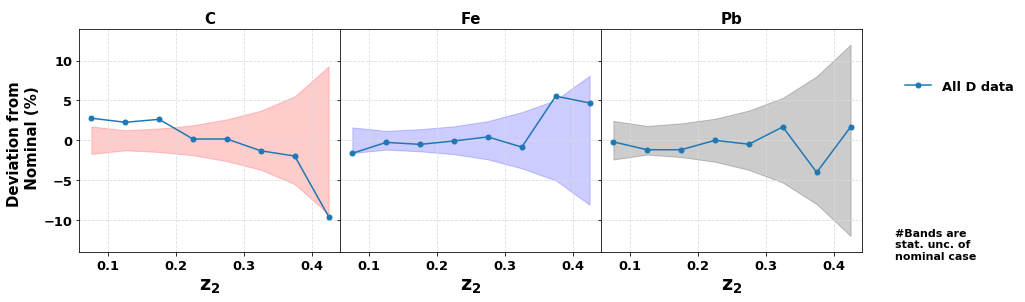

In [83]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['All D data']

deuFrames=[df['D_C'],df['D_Fe'],df['D_Pb']]
df['D']=pd.concat(deuFrames)
deuFrames_trigger=[df_trigger['D_C_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_Pb_trigger']]
df_trigger['D_trigger']=pd.concat(deuFrames_trigger)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D'], 
                        df_trigger['%s_trigger'%target], df_trigger['D_trigger'],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_nom,
                                       trig_cut = trigger_cut_nom)
    

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#plt.savefig('sys_diH_AllDeu_z2.pdf', bbox_inches='tight')

plt.show()




**R2h themselves**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

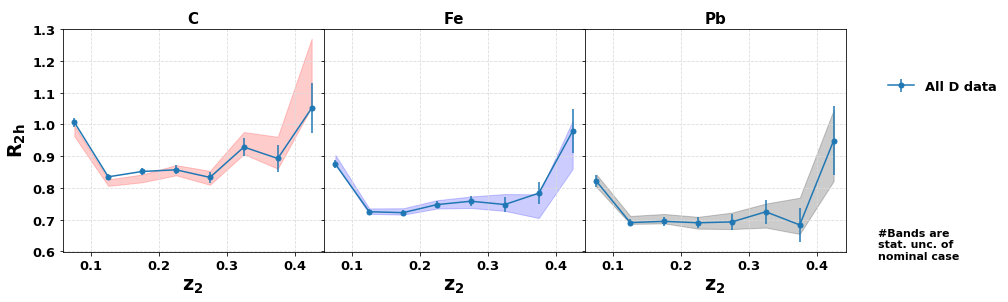

In [84]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['All D data']

deuFrames=[df['D_C'],df['D_Fe'],df['D_Pb']]
df['D']=pd.concat(deuFrames)
deuFrames_trigger=[df_trigger['D_C_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_Pb_trigger']]
df_trigger['D_trigger']=pd.concat(deuFrames_trigger)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, r_nom+err_nom,r_nom-err_nom,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D'], 
                        df_trigger['%s_trigger'%target], df_trigger['D_trigger'],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_nom,
                                       trig_cut = trigger_cut_nom)
    

    #y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,r_var1,yerr=err_var1 ,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

outname='sys_diH_AllDeu_z2_R2h'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

plt.show()


**as a function of $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

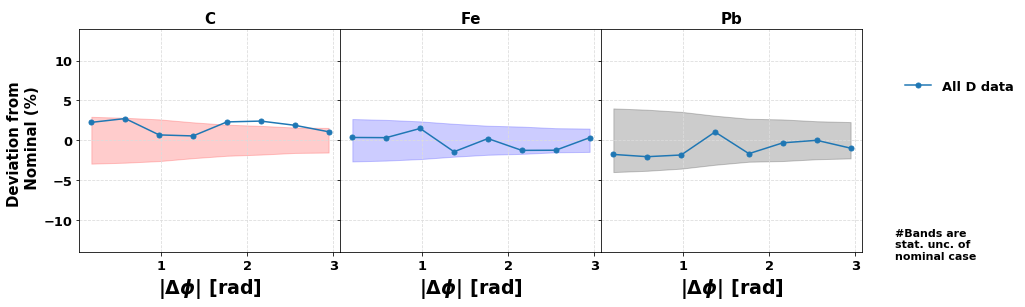

In [85]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['All D data']

deuFrames=[df['D_C'],df['D_Fe'],df['D_Pb']]
df['D']=pd.concat(deuFrames)
deuFrames_trigger=[df_trigger['D_C_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_Pb_trigger']]
df_trigger['D_trigger']=pd.concat(deuFrames_trigger)

varDep='dphi'



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable=varDep, 
                                    pair_cut ='%s and Q2>1.0'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D'], 
                        df_trigger['%s_trigger'%target], df_trigger['D_trigger'],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable=varDep, 
                                       pair_cut ='%s and Q2>1.0'%pair_cut_nom,
                                       trig_cut = trigger_cut_nom)
    

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
   
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#plt.savefig('sys_diH_AllDeu_diphi.pdf', bbox_inches='tight')

plt.show()

del varDep


Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

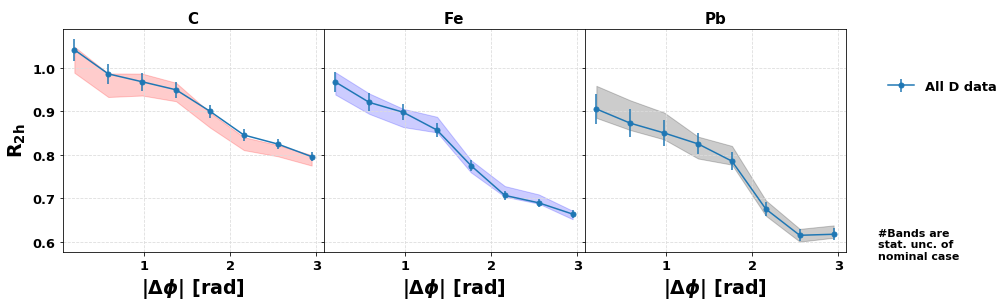

In [86]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['All D data']

deuFrames=[df['D_C'],df['D_Fe'],df['D_Pb']]
df['D']=pd.concat(deuFrames)
deuFrames_trigger=[df_trigger['D_C_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_Pb_trigger']]
df_trigger['D_trigger']=pd.concat(deuFrames_trigger)

varDep='dphi'



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable=varDep, 
                                    pair_cut ='%s and Q2>1.0'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, err_nom+r_nom,-err_nom+r_nom,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D'], 
                        df_trigger['%s_trigger'%target], df_trigger['D_trigger'],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable=varDep, 
                                       pair_cut ='%s and Q2>1.0'%pair_cut_nom,
                                       trig_cut = trigger_cut_nom)
    

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,r_var1, yerr=err_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
   
axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')


outname='sys_diH_AllDeu_diphi_R2h'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

del varDep
plt.show()




**As a function of the invariant mass**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

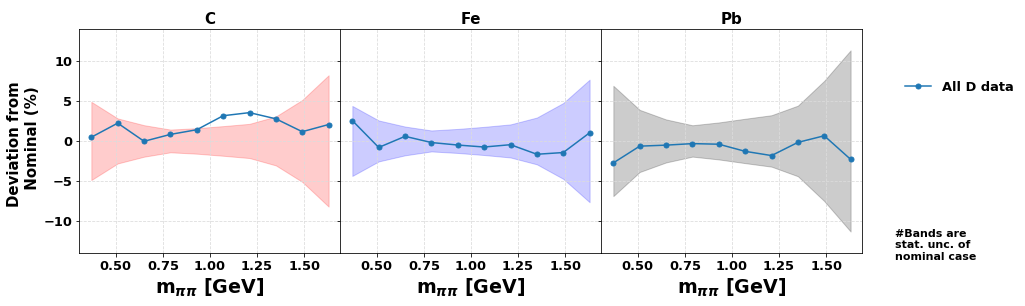

In [87]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['All D data']

deuFrames=[df['D_C'],df['D_Fe'],df['D_Pb']]
df['D']=pd.concat(deuFrames)
deuFrames_trigger=[df_trigger['D_C_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_Pb_trigger']]
df_trigger['D_trigger']=pd.concat(deuFrames_trigger)

varDep='pair_mass'

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable=varDep, 
                                    pair_cut ='%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D'], 
                        df_trigger['%s_trigger'%target], df_trigger['D_trigger'],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable=varDep, 
                                       pair_cut ='%s'%pair_cut_nom,
                                       trig_cut = trigger_cut_nom)
    

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
  

axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#plt.savefig('sys_diH_AllDeu_dipionMass.pdf', bbox_inches='tight')
del varDep
plt.show()




Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

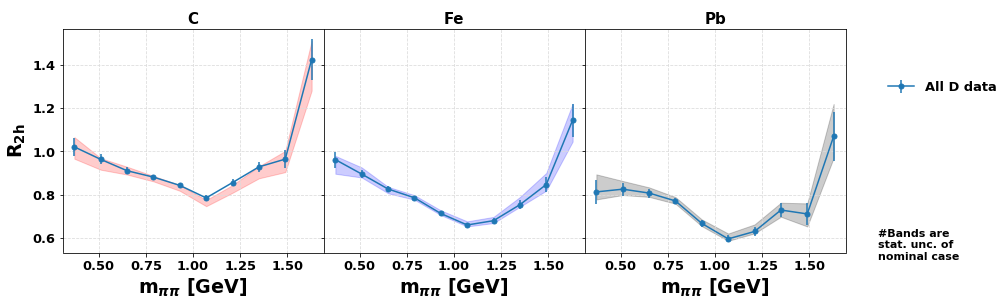

In [88]:
##%%script false --no-raise-error
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['All D data']

deuFrames=[df['D_C'],df['D_Fe'],df['D_Pb']]
df['D']=pd.concat(deuFrames)
deuFrames_trigger=[df_trigger['D_C_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_Pb_trigger']]
df_trigger['D_trigger']=pd.concat(deuFrames_trigger)

varDep='pair_mass'

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,variable=varDep, 
                                    pair_cut ='%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, err_nom+r_nom,-err_nom+r_nom,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D'], 
                        df_trigger['%s_trigger'%target], df_trigger['D_trigger'],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable=varDep, 
                                       pair_cut ='%s'%pair_cut_nom,
                                       trig_cut = trigger_cut_nom)
    

    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,r_var1, yerr=err_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ [GeV]',fontsize=19,fontweight="bold")
  

axs[0].set_ylabel('R$_{2\mathrm{h}}$',fontsize=19,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')


outname='sys_diH_AllDeu_dipionMass_R2h'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

del varDep
plt.show()




# Time Changing Variation

**The idea here is to check some time dependent variation according to the run numbers. For this I divided the total sample in two chunks, the first have of runs and then the second half, the idea is to compared those with the nominal**

In [89]:
%%time
path_data="/home/seba/di-hadron/Pairs_RN_time_check/firstHalf"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df['FirstHalf%s'%target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['FirstHalfD_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['FirstHalf%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['FirstHalfD_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)


Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 2.9 s, sys: 41 ms, total: 2.94 s
Wall time: 3.18 s


In [90]:
%%time
path_data="/home/seba/di-hadron/Pairs_RN_time_check/secondHalf"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df['SecondHalf%s'%target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['SecondHalfD_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['SecondHalf%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['SecondHalfD_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 2.9 s, sys: 99 ms, total: 3 s
Wall time: 3.24 s


In [91]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key] = r2h.applyCuts(df[key],isMC=isMC)
    df[key] = r2h.applyCutsPair(df[key],isMC=isMC)

for key in df_trigger.keys():
    print (key)
    df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True)
    print (' ')   




key:  C
Entries before cut  93947
Q2>1.0 and Q2<4.0 93947  (100.00  %)
0.2<h1_p<5.0  93947  (100.00  %)
inelasticity < 0.85 93947  (100.00  %)
h1_pid = pions (trigger) 93947  (100.00  %)
2.2 < nu <4.2 93947  (100.00  %)
10< h1_th<90 93947  (100.00  %)
Theta/P fiducial region selected for trigger 93947  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 93947  (100.00  %)
2.2 < nu < 4.2 93947  (100.00  %)
secondary hadrons are pions 93947  (100.00  %)
(h1_z+h2_z)<1.0 93947  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 93947  (100.00  %)
kinematic limits for h2_z 93947  (100.00  %)
kinematic limits for dphi 93947  (100.00  %)
kinematic limits for pair_mass 93947  (100.00  %)
leading hadrons are pions 93947  (100.00  %)
0.2<h2_p<5.0 93947  (100.00  %)
0.2<h1_p<5.0 93947  (100.00  %)
10<h2_th<90 93947  (100.00  %)
Theta/P fiducial region selected for secondary hadron 93947  (100.00  %)
10< h1_th<90 93947  (100.00  %)
Theta/P fiducial region selected for tr

2.2 < nu <4.2 94588  (100.00  %)
10< h1_th<90 94588  (100.00  %)
Theta/P fiducial region selected for trigger 94588  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 94588  (100.00  %)
2.2 < nu < 4.2 94588  (100.00  %)
secondary hadrons are pions 94588  (100.00  %)
(h1_z+h2_z)<1.0 94588  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 94588  (100.00  %)
kinematic limits for h2_z 94588  (100.00  %)
kinematic limits for dphi 94588  (100.00  %)
kinematic limits for pair_mass 94588  (100.00  %)
leading hadrons are pions 94588  (100.00  %)
0.2<h2_p<5.0 94588  (100.00  %)
0.2<h1_p<5.0 94588  (100.00  %)
10<h2_th<90 94588  (100.00  %)
Theta/P fiducial region selected for secondary hadron 94588  (100.00  %)
10< h1_th<90 94588  (100.00  %)
Theta/P fiducial region selected for trigger hadron 94588  (100.00  %)

key:  P25D_Fe
Entries before cut  197460
Q2>1.0 and Q2<4.0 197460  (100.00  %)
0.2<h1_p<5.0  197460  (100.00  %)
inelasticity < 0.85 197460  (100.00  %)
h1

kinematic limits for dphi 34615  (100.00  %)
kinematic limits for pair_mass 34615  (100.00  %)
leading hadrons are pions 34615  (100.00  %)
0.2<h2_p<5.0 34615  (100.00  %)
0.2<h1_p<5.0 34615  (100.00  %)
10<h2_th<90 34615  (100.00  %)
Theta/P fiducial region selected for secondary hadron 34615  (100.00  %)
10< h1_th<90 34615  (100.00  %)
Theta/P fiducial region selected for trigger hadron 34615  (100.00  %)

key:  P30D_Pb
Entries before cut  218134
Q2>1.0 and Q2<4.0 218134  (100.00  %)
0.2<h1_p<5.0  218134  (100.00  %)
inelasticity < 0.85 218134  (100.00  %)
h1_pid = pions (trigger) 218134  (100.00  %)
2.2 < nu <4.2 218134  (100.00  %)
10< h1_th<90 218134  (100.00  %)
Theta/P fiducial region selected for trigger 218134  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 218134  (100.00  %)
2.2 < nu < 4.2 218134  (100.00  %)
secondary hadrons are pions 218134  (100.00  %)
(h1_z+h2_z)<1.0 218134  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 218134  (100.0

(h1_z+h2_z)<1.0 557669  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 557669  (100.00  %)
kinematic limits for h2_z 557669  (100.00  %)
kinematic limits for dphi 557669  (100.00  %)
kinematic limits for pair_mass 557669  (100.00  %)
leading hadrons are pions 557669  (100.00  %)
0.2<h2_p<5.0 557669  (100.00  %)
0.2<h1_p<5.0 557669  (100.00  %)
10<h2_th<90 557669  (100.00  %)
Theta/P fiducial region selected for secondary hadron 557669  (100.00  %)
10< h1_th<90 557669  (100.00  %)
Theta/P fiducial region selected for trigger hadron 557669  (100.00  %)

key:  FirstHalfC
Entries before cut  46129
Q2>1.0 and Q2<4.0 46129  (100.00  %)
0.2<h1_p<5.0  46129  (100.00  %)
inelasticity < 0.85 46129  (100.00  %)
h1_pid = pions (trigger) 46129  (100.00  %)
2.2 < nu <4.2 46129  (100.00  %)
10< h1_th<90 46129  (100.00  %)
Theta/P fiducial region selected for trigger 46129  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 46129  (100.00  %)
2.2 < nu < 4.2 46129  (100.0

10<h2_th<90 52806  (99.94  %)
Theta/P fiducial region selected for secondary hadron 52806  (100.00  %)
10< h1_th<90 52806  (100.00  %)
Theta/P fiducial region selected for trigger hadron 52806  (100.00  %)

key:  SecondHalfFe
Entries before cut  48310
Q2>1.0 and Q2<4.0 48310  (100.00  %)
0.2<h1_p<5.0  48310  (100.00  %)
inelasticity < 0.85 48310  (100.00  %)
h1_pid = pions (trigger) 48310  (100.00  %)
2.2 < nu <4.2 48310  (100.00  %)
10< h1_th<90 48306  (99.99  %)
Theta/P fiducial region selected for trigger 48306  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 48306  (100.00  %)
2.2 < nu < 4.2 48306  (100.00  %)
secondary hadrons are pions 48306  (100.00  %)
(h1_z+h2_z)<1.0 48155  (99.69  %)
(h1_pid*h2_pid)<0, opposite charge pions 35850  (74.45  %)
kinematic limits for h2_z 35464  (98.92  %)
kinematic limits for dphi 35446  (99.95  %)
kinematic limits for pair_mass 35326  (99.66  %)
leading hadrons are pions 35326  (100.00  %)
0.2<h2_p<5.0 35326  (100.00 

2.2 < nu <4.2 1255373  (100.00  %)
10< h1_th<90 1255373  (100.00  %)
Theta/P fiducial region selected for trigger 1255373  (100.00  %)
 
P30C_trigger
Entries before cut  674641
Q2>1.0 and Q2<4.0 674641  (100.00  %)
0.2<h1_p<5.0  674641  (100.00  %)
inelasticity < 0.85 674641  (100.00  %)
h1_pid = pions (trigger) 674641  (100.00  %)
2.2 < nu <4.2 674641  (100.00  %)
10< h1_th<90 674641  (100.00  %)
Theta/P fiducial region selected for trigger 674641  (100.00  %)
 
P30D_C_trigger
Entries before cut  909258
Q2>1.0 and Q2<4.0 909258  (100.00  %)
0.2<h1_p<5.0  909258  (100.00  %)
inelasticity < 0.85 909258  (100.00  %)
h1_pid = pions (trigger) 909258  (100.00  %)
2.2 < nu <4.2 909258  (100.00  %)
10< h1_th<90 909258  (100.00  %)
Theta/P fiducial region selected for trigger 909258  (100.00  %)
 
P30Fe_trigger
Entries before cut  787716
Q2>1.0 and Q2<4.0 787716  (100.00  %)
0.2<h1_p<5.0  787716  (100.00  %)
inelasticity < 0.85 787716  (100.00  %)
h1_pid = pions (trigger) 787716  (100.00  %)
2

0.2<h1_p<5.0  567987  (100.00  %)
inelasticity < 0.85 567987  (100.00  %)
h1_pid = pions (trigger) 567987  (100.00  %)
2.2 < nu <4.2 567987  (100.00  %)
10< h1_th<90 567986  (100.00  %)
Theta/P fiducial region selected for trigger 567986  (100.00  %)
 
CPU times: user 20.8 s, sys: 2.04 s, total: 22.8 s
Wall time: 20.4 s


**as a function of $z_2$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

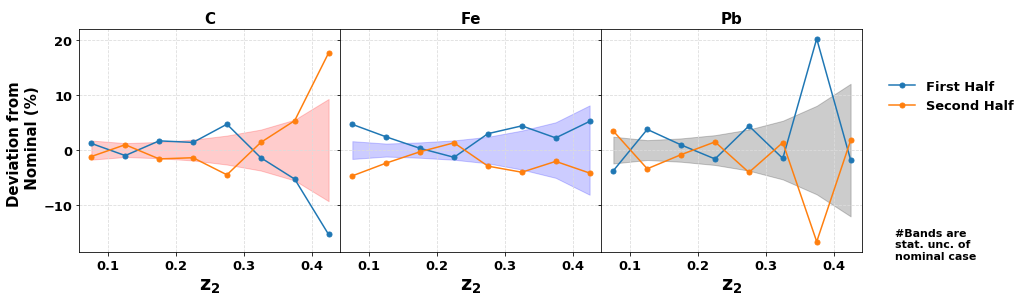

In [92]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First Half', 'Second Half']

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['FirstHalf%s'%target], df['FirstHalfD_%s'%target], 
                        df_trigger['FirstHalf%s_trigger'%target], df_trigger['FirstHalfD_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    r_var2, err_var2,x_var2 = r2h.getRatio(df['SecondHalf%s'%target], df['SecondHalfD_%s'%target], 
                        df_trigger['SecondHalf%s_trigger'%target], df_trigger['SecondHalfD_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([-0.5,0.5])
#plt.savefig('sys_diH_RN_TimeCheck_z2.pdf', bbox_inches='tight')

plt.show()

**looking the ratio themselves**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and

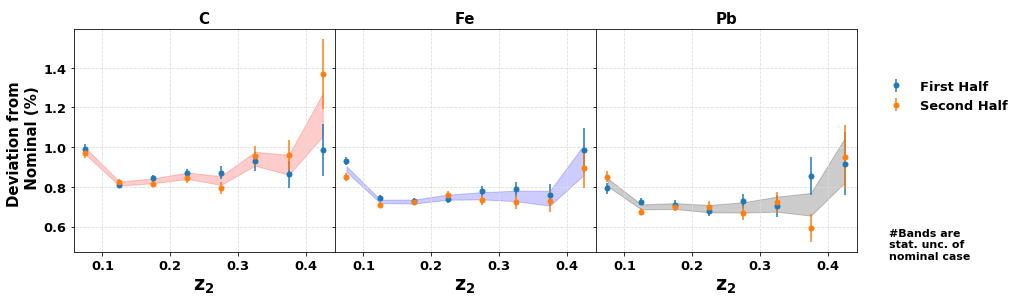

In [93]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First Half', 'Second Half']

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom+r_nom),-err_nom+r_nom,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['FirstHalf%s'%target], df['FirstHalfD_%s'%target], 
                        df_trigger['FirstHalf%s_trigger'%target], df_trigger['FirstHalfD_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    r_var2, err_var2,x_var2 = r2h.getRatio(df['SecondHalf%s'%target], df['SecondHalfD_%s'%target], 
                        df_trigger['SecondHalf%s_trigger'%target], df_trigger['SecondHalfD_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    
    axs[i].errorbar(x_nom,r_var1,yerr=err_var1 ,fmt='o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,r_var2,yerr=err_var2,fmt='o',ms=5,label=tmp_label[1]if i == 0 else "")  
    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([0.5,1.5])


outname='sys_diH_RN_TimeCheck_z2'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')



plt.show()

**as a function of $\Delta \phi$**

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_cm_pt**2>0.005
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(

Print Trigger Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_cm_pt**2>0.005
Total Cut  h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (15*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(

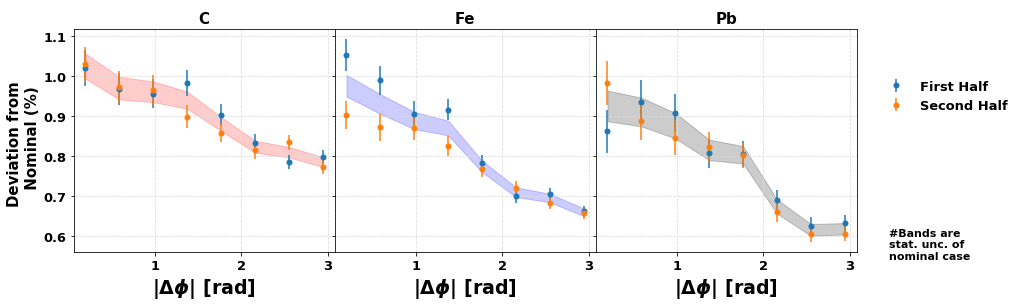

In [95]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First Half', 'Second Half']

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                    pair_cut = pair_cut_nom+ ' and h1_cm_pt**2>0.005 and h2_cm_pt**2>0.005 ',
                                    trig_cut = trigger_cut_nom+ ' and h1_cm_pt**2>0.005')
    axs[i].fill_between(x_nom, (err_nom+r_nom),-err_nom+r_nom,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['FirstHalf%s'%target], df['FirstHalfD_%s'%target], 
                        df_trigger['FirstHalf%s_trigger'%target], df_trigger['FirstHalfD_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                    pair_cut = pair_cut_nom+ ' and h1_cm_pt**2>0.005  and h2_cm_pt**2>0.005 ',
                                    trig_cut = trigger_cut_nom+ ' and h1_cm_pt**2>0.005')
    r_var2, err_var2,x_var2 = r2h.getRatio(df['SecondHalf%s'%target], df['SecondHalfD_%s'%target], 
                        df_trigger['SecondHalf%s_trigger'%target], df_trigger['SecondHalfD_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                    pair_cut = pair_cut_nom+ ' and h1_cm_pt**2>0.005 and h2_cm_pt**2>0.005 ',
                                    trig_cut = trigger_cut_nom+ ' and h1_cm_pt**2>0.005')
    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    
    axs[i].errorbar(x_nom,r_var1,yerr=err_var1 ,fmt='o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,r_var2,yerr=err_var2,fmt='o',ms=5,label=tmp_label[1]if i == 0 else "")  
    
    
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([0.5,1.5])

outname='sys_diH_RN_TimeCheck_dphi'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
#aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

plt.show()

**as a function of Inv Mass**

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['First Half', 'Second Half']

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom+r_nom),-err_nom+r_nom,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['FirstHalf%s'%target], df['FirstHalfD_%s'%target], 
                        df_trigger['FirstHalf%s_trigger'%target], df_trigger['FirstHalfD_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    r_var2, err_var2,x_var2 = r2h.getRatio(df['SecondHalf%s'%target], df['SecondHalfD_%s'%target], 
                        df_trigger['SecondHalf%s_trigger'%target], df_trigger['SecondHalfD_%s_trigger'%target],
                        minz=minmass,maxz=maxmass,nbins=dpionMassBinsEdges, variable='pair_mass', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    
    axs[i].errorbar(x_nom,r_var1,yerr=err_var1 ,fmt='o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,r_var2,yerr=err_var2,fmt='o',ms=5,label=tmp_label[1]if i == 0 else "")  

   
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ (GeV)',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')
#axs[0].set_ylim([0.5,1.5])

outname='sys_diH_RN_TimeCheck_dpion_Mass'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()

# Variation in the fiducial cuts to select pion ($\theta_{LAB}$,P)

**as a function of $z_{2}$**

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['91','89']

pair_cut_var1  ='and h1_z>0.5 and h1_th<91 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<2.5 and abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<91 and h1_th>10 and  abs(h1_deltaZ)<2.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<89 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.5 and abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<89 and h1_th>10 and  abs(h1_deltaZ)<3.5 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)



for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='-o',ms=5,label=tmp_label[0]if i == 0 else "")  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='-o',ms=5,label=tmp_label[1]if i == 0 else "")  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
axs[0].set_ylim(y_axis_min , y_axis_max ) 
plt.subplots_adjust(right=0.85, top=0.9)    
fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')


#outname='sys_diH_DeltaZ'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')


plt.show()

**as a function of $\Delta \phi$**

**as a function of Inv Mass**

# Extracting the number of pairs from the sample

In [ ]:
for i,target in enumerate(['C','Fe','Pb', 'D_C', 'D_Fe', 'D_Pb']):                      
    print('%s'%target)            
    print(df['%s'%target].query('h1_pid==211 and h2_pid==211 %s'%(pair_cut_nom)).shape[0])
    print(df['%s'%target].query('h1_pid==211 and h2_pid==-211 %s'%(pair_cut_nom)).shape[0])
    print(df['%s'%target].query('h1_pid==-211 and h2_pid==211 %s'%(pair_cut_nom)).shape[0])
    print(df['%s'%target].query('h1_pid==-211 and h2_pid==-211 %s'%(pair_cut_nom)).shape[0])

    #print( 'shape[0] method:', df['%s'%target].query('Q2>1 %s'%pair_cut_nom).shape[0])
    #print( 'len method:', len(df['%s'%target].query('Q2>1 %s'%pair_cut_nom) ))


**now the number of triggers**

In [ ]:
for i,target in enumerate(['C','Fe','Pb', 'D_C', 'D_Fe', 'D_Pb']):                      
    print('%s'%target)            
    #print(df_trigger['%s_trigger'%target].query('h1_pid==211 and %s'%(trigger_cut_nom)).shape[0])
    #print(df_trigger['%s_trigger'%target].query('h1_pid==-211 and %s'%(trigger_cut_nom)).shape[0])
    print(df_trigger['%s_trigger'%target].query('%s'%(trigger_cut_nom)).shape[0])

    #print( 'shape[0] method:', df['%s'%target].query('Q2>1 %s'%pair_cut_nom).shape[0])
    #print( 'len method:', len(df['%s'%target].query('Q2>1 %s'%pair_cut_nom) ))


# VERTEX SELECTION variation

**here I'm using the files with the ZC variable included to do this studies**

In [ ]:
%%time
df3 = {}
df3_trigger = {}
#path_data="/home/seba/CreatePairTuples"
path_data3="/home/seba/di-hadron/P27NEW"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df3[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data3,target), target)
    df3['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data3,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df3_trigger['%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data3,target), 
                                                      '%s_trigger'%target)
    df3_trigger['D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data3,target), 
                                                        'D_%s_trigger'%target)


for key in df3.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df3[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df3[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    df3[key] = r2h.applyCuts(df3[key],isMC=isMC)
    df3[key] = r2h.applyCutsPair(df3[key],isMC=isMC)

for key in df3_trigger.keys():
    print (key)
    df3_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df3_trigger[key] = r2h.applyCuts(df3_trigger[key],isTrigger=True)
    print (' ')    



In [ ]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    print('for target ',target, ' : ',(err_nom/r_nom)*100)
    plt.errorbar(x_nom,r_nom,yerr = err_nom  ,  fmt='-o',ms=5, label='This work, %s'%target)  
plt.grid(axis="x",color='gainsboro', linestyle='dashed')
plt.grid(axis="y",color='gainsboro', linestyle='dashed')

plt.subplots_adjust(right=1.0, top=1.0)    
fig.legend(loc='upper center',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
plt.ylim([0.,1.5])
plt.ylabel('R$_{\mathrm{2h}}$',fontsize=15,fontweight="bold")
plt.xlabel('z$_{2}$',fontsize=15,fontweight="bold")

#print('for target ',target, ' : ',(err_nom/r_nom)*100)

plt.show()

**Vertex variations, the idea is to vary the edges of the cuts by an a fix ammount (drop the HH and RD options)**

In [ ]:
fig = plt.figure(figsize=(15,5))
for i,target in enumerate(['Pb','D_Pb']):
    
    y, x, _ = plt.hist(df3[target].query('Q2>1 ')['ZC'],alpha=0.8,lw=2,
                       bins=500,histtype='step',   density=True,color='#1f77b4')
plt.vlines([-25.54, -24.36], 0, 1, colors='gray', ls='dashed')
plt.vlines([-25.54-0.05, -24.36+0.05], 0, 1, colors='red')
plt.vlines([-25.54+0.05, -24.36-0.05], 0, 1, colors='black')
plt.xlim(-34,-21)
plt.vlines([-31.8, -28.4], 0, 1, colors='gray', ls='dashed', label='nominal')
plt.vlines([-31.8-0.05, -28.4+0.05], 0, 1, colors='red', label='var 1')
plt.vlines([-31.8+0.05, -28.4-0.05], 0, 1, colors='black', label='var 2')

#plt.xlim(10,30)  
plt.yscale('log')
#plt.xticks(rotation='vertical')
plt.legend(    ncol=1, fontsize='x-small')
plt.xlabel('electron z-vertex (cm)', fontsize=22,fontweight='bold')
plt.ylabel('normalized counts', fontsize=22,fontweight='bold')
plt.show()



**as a function of $z_{2}$**

**Alternative format**

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['variation 1','variation 2']
sys_band=np.array([0,0,0,0,0,0,0,0])
pair_cut_var1  ='and ((ZC>-31.8-0.05 and ZC<-28.4+0.05) or  (ZC> -25.54-0.05 and ZC< -24.36+0.05))   and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0  and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   =' ((ZC>-31.8-0.05 and ZC<-28.4+0.05) or  (ZC> -25.54-0.05 and ZC< -24.36+0.05))  and h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and ((ZC>-31.8+0.05 and ZC<-28.4-0.05) or  (ZC> -25.54+0.05 and ZC< -24.36-0.05))  and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   =' ((ZC>-31.8+0.05 and ZC<-28.4-0.05) or  (ZC> -25.54+0.05 and ZC< -24.36-0.05))  and h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
    
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")

#outname='sys_diH_VertexCuts'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()


**as a function of $\Delta\phi$**

**Alternative format**

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['variation 1','variation 2']
sys_band=np.array([0,0,0,0,0,0,0,0])
pair_cut_var1  ='and ((ZC>-31.8-0.05 and ZC<-28.4+0.05) or  (ZC> -25.54-0.05 and ZC< -24.36+0.05))   and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0  and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   =' ((ZC>-31.8-0.05 and ZC<-28.4+0.05) or  (ZC> -25.54-0.05 and ZC< -24.36+0.05))  and h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and ((ZC>-31.8+0.05 and ZC<-28.4-0.05) or  (ZC> -25.54+0.05 and ZC< -24.36-0.05))  and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   =' ((ZC>-31.8+0.05 and ZC<-28.4-0.05) or  (ZC> -25.54+0.05 and ZC< -24.36-0.05))  and h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)  
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
    
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")

#outname='sys_diH_VertexCuts_dphi'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()


**as a function of $m_{\pi\pi}$**

**Alternative format**

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['variation 1','variation 2']
sys_band=np.array([0,0,0,0,0,0,0,0,0,0])
pair_cut_var1  ='and ((ZC>-31.8-0.05 and ZC<-28.4+0.05) or  (ZC> -25.54-0.05 and ZC< -24.36+0.05))   and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0  and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   =' ((ZC>-31.8-0.05 and ZC<-28.4+0.05) or  (ZC> -25.54-0.05 and ZC< -24.36+0.05))  and h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and ((ZC>-31.8+0.05 and ZC<-28.4-0.05) or  (ZC> -25.54+0.05 and ZC< -24.36-0.05))  and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   =' ((ZC>-31.8+0.05 and ZC<-28.4-0.05) or  (ZC> -25.54+0.05 and ZC< -24.36-0.05))  and h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                        variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                           variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                           variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)  
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
    
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ (GeV)',fontsize=17,fontweight="bold")

axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")

#outname='sys_diH_VertexCuts_dpionMass'
#if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
#plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
#plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()


**Now, we have the vertex variation. We select a loose cut as the variation (Hayks)**

In [ ]:
pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)


fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['variation 1','loosened selection']
sys_band=np.array([0,0,0,0,0,0,0,0,0,0])

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                        variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                           variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                           variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)  
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    #axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
    
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ (GeV)',fontsize=17,fontweight="bold")

axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")

outname='sys_diH_VertexCuts_dpionMass'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()






In [ ]:
pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['variation 1','loosened selection']
sys_band=np.array([0,0,0,0,0,0,0,0])

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)  
    #y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    #axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
    
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")

outname='sys_diH_VertexCuts_dphi'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()



In [ ]:
pair_cut_var1  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargTypeSM!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass,Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['variation 1','loosened selection']
sys_band=np.array([0,0,0,0,0,0,0,0])

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut = pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')  
    
    r_var1, err_var1,x_var1 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df3['%s'%target], df3['D_%s'%target], 
                        df3_trigger['%s_trigger'%target], df3_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    #axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
    
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")

outname='sys_diH_VertexCuts'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()


**YC variation**

**For this we need the 'new' files that contains the YC, ZC and so on variables**

In [ ]:
%%time
df_YC = {}
df_YC_trigger = {}
#path_data="/home/seba/CreatePairTuples"
path_data="/home/seba/CreatePairTuples/allRunsYCZCcoordinates"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df_YC[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df_YC['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_YC_trigger['%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_YC_trigger['D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)


for key in df_YC.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df_YC[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df_YC[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    df_YC[key] = r2h.applyCuts(df_YC[key],isMC=isMC)
    df_YC[key] = r2h.applyCutsPair(df_YC[key],isMC=isMC)

for key in df_YC_trigger.keys():
    print (key)
    df_YC_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df_YC_trigger[key] = r2h.applyCuts(df_YC_trigger[key],isTrigger=True)
    print (' ')    




**As a function of $z_{2}$**

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\mathrm{YC}|<1.0$ cm','$|\mathrm{YC}|<2.0$ cm']
sys_band=np.array([0,0,0,0,0,0,0,0])
pair_cut_var1  ='and h1_z>0.5 and abs(YC)<1.0 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(YC)<1.0 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(YC)<2.0 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(YC)<2.0 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df_YC['%s'%target], df_YC['D_%s'%target], 
                        df_YC_trigger['%s_trigger'%target], df_YC_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                    pair_cut ='%s and abs(YC)<1.4 and TargType!=0 and abs(h1_deltaZ)<3.0 and abs(h2_deltaZ)<3.0'%pair_cut_nom,
                                    trig_cut = '%s and abs(YC)<1.4 and TargType!=0 and abs(h1_deltaZ)<3.0'%trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.2)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    r_var1, err_var1,x_var1 = r2h.getRatio(df_YC['%s'%target], df_YC['D_%s'%target], 
                        df_YC_trigger['%s_trigger'%target], df_YC_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df_YC['%s'%target], df_YC['D_%s'%target], 
                        df_YC_trigger['%s_trigger'%target], df_YC_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2,nbins=dpionz2BinsEdges, variable='h2_z', 
                                       pair_cut = pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))
axs[0].set_ylim(y_axis_min , y_axis_max ) 
plt.subplots_adjust(right=0.95, top=0.9)    
#fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('z$_{2}$',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')


outname='sys_diH_YC_z2'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')

del sys_band
plt.show()

**As a function of $\Delta\phi$**

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\mathrm{YC}|<1.0$ cm','$|\mathrm{YC}|<2.0$ cm']
sys_band=np.array([0,0,0,0,0,0,0,0])
pair_cut_var1  ='and h1_z>0.5 and abs(YC)<1.0 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(YC)<1.0 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(YC)<2.0 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(YC)<2.0 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df_YC['%s'%target], df_YC['D_%s'%target], 
                        df_YC_trigger['%s_trigger'%target], df_YC_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                    pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)
    #axs[i].fill_between(x_nom, (err_nom/r_nom)*100,-(err_nom/r_nom)*100,color=colorBands[i],alpha=0.01, lw=5)
    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    r_var1, err_var1,x_var1 = r2h.getRatio(df_YC['%s'%target], df_YC['D_%s'%target], 
                        df_YC_trigger['%s_trigger'%target], df_YC_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df_YC['%s'%target], df_YC['D_%s'%target], 
                        df_YC_trigger['%s_trigger'%target], df_YC_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBinsEdges, variable='dphi', 
                                       pair_cut = '%s and Q2>1.0 and h2_z<0.5'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))
axs[0].set_xticks(np.arange(mindphi,maxdphi,0.5))
print(np.arange(y_axis_min,y_axis_max+4,2))
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
#fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('$|\Delta\phi|$ [rad]',fontsize=19,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#fig.text(0.88, 0.15, '#Dashed lines\nare stat. unc. of \nnominal case', fontsize=10, va='center')
#fig.text(0.88, 0.30, '#Shaded band\nare systematic \nunc. applied', fontsize=10, va='center')

outname='sys_diH_YC_dphi'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band
plt.show()

**As a function of $m_{\pi\pi}$**

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(15,4),gridspec_kw={'hspace': 0., 'wspace':0.})
colorBands=['red','blue','black']
tmp_label=['$|\mathrm{YC}|<1.0$ cm','$|\mathrm{YC}|<2.0$ cm']
sys_band=np.array([0,0,0,0,0,0,0,0,0,0])
pair_cut_var1  ='and h1_z>0.5 and abs(YC)<1.0 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and  abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var1   ='h1_z>0.5 and abs(YC)<1.0 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)
pair_cut_var2  ='and h1_z>0.5 and abs(YC)<2.0 and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s  and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxmass ,minmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_var2   ='h1_z>0.5 and abs(YC)<2.0 and h1_th<90 and h1_th>10 and  abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

for i,target in enumerate(['C','Fe','Pb']):
    r_nom, err_nom,x_nom = r2h.getRatio(df_YC['%s'%target], df_YC['D_%s'%target], 
                        df_YC_trigger['%s_trigger'%target], df_YC_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                        variable='pair_mass', 
                                    pair_cut = '%s'%pair_cut_nom,
                                    trig_cut = trigger_cut_nom)

    axs[i].errorbar(x_nom,(err_nom/r_nom)*100,fmt='--',ms=5, color='black')
    axs[i].errorbar(x_nom,-(err_nom/r_nom)*100,fmt='--',ms=5, color='black')    
    r_var1, err_var1,x_var1 = r2h.getRatio(df_YC['%s'%target], df_YC['D_%s'%target], 
                        df_YC_trigger['%s_trigger'%target], df_YC_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                           variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var1,
                                       trig_cut = trigger_cut_var1)
    
    r_var2, err_var2,x_var2 = r2h.getRatio(df_YC['%s'%target], df_YC['D_%s'%target], 
                        df_YC_trigger['%s_trigger'%target], df_YC_trigger['D_%s_trigger'%target],
                        minz=minmass,maxz=maxmass, nbins=dpionMassBinsEdges,
                                           variable='pair_mass', 
                                       pair_cut = '%s'%pair_cut_var2,
                                       trig_cut=trigger_cut_var2)    
    y_dev_nom_var1 =  ((r_var1 - r_nom)/ r_nom )*100.
    y_dev_nom_var2 =  ((r_var2 - r_nom)/ r_nom )*100.
    axs[i].errorbar(x_nom,y_dev_nom_var1,fmt='o',ms=5,label=tmp_label[0])  
    axs[i].errorbar(x_nom,y_dev_nom_var2,fmt='o',ms=5,label=tmp_label[1])  
    axs[i].grid(axis="x",color='gainsboro', linestyle='dashed')
    axs[i].grid(axis="y",color='gainsboro', linestyle='dashed')
    axs[i].fill_between(x_nom,sys_band ,-sys_band ,color='orange',alpha=0.3, lw=0)
    axs[i].legend(loc='upper left',ncol=1,frameon=False,fontsize=13, title='', title_fontsize=30)    
axs[0].set_yticks(np.arange(y_axis_min,y_axis_max,2))    
axs[0].set_ylim(y_axis_min , y_axis_max )
plt.subplots_adjust(right=0.95, top=0.9)    
#fig.legend(loc='upper right',ncol=1,frameon=False,fontsize=13, title='\n', title_fontsize=30)
for i,j in enumerate(['C','Fe','Pb']):
    axs[i].set_title('%s'%j,fontsize=15,fontweight="bold")    
    axs[i].set_xlabel('m$_{\pi\pi}$ (GeV)',fontsize=17,fontweight="bold")
axs[0].set_ylabel('Deviation from \n Nominal (%)',fontsize=15,fontweight="bold")
#fig.text(0.88, 0.15, '#Bands are \nstat. unc. of \nnominal case', fontsize=11, va='center')

outname='sys_diH_YC_dpionMass'
if not os.path.isdir(outdir_sys):    os.mkdir(outdir_sys)
plt.savefig(outdir_sys+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir_sys+outname+'.png', bbox_inches='tight')
del sys_band

plt.show()